In [1]:
# General Imports
import numpy as np
import pandas as pd
import csv
import time
import os
from datetime import datetime as dtime
import re


# Plotting
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
# TeX Label Config
import matplotlib as mpl
mpl.rcParams.update({
    'text.usetex': False,
    'font.family': 'serif',
    'font.serif': 'cmr10',
    'mathtext.fontset': 'cm',
    'font.family': 'STIXGeneral',
    'font.size': 14,
    'axes.unicode_minus': True,
    'figure.autolayout': True,
    'legend.fontsize': 'large'
    })

# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Sklearn, scipy
from sklearn.model_selection import train_test_split
from scipy.stats import unitary_group

# tqdm for progress bar
from tqdm import trange, tqdm

# ipython config
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Global definitions

In [2]:
# Number of qubits in considered system
# Dimension of Hilbert space is 2 ** NQ
# Total independent parameters in state density matrix is 4**NQ -1

NQ = 2
state_gen_method = 'random_uniform_vector'

assert state_gen_method in ['unitary_column', 'random_uniform_vector']

In [3]:
# State Visualization

def plot_dm(astate, title='', save_path=False, fixed_scale=False):

    # Make square matrix
    if len(astate.shape) == 1:
        dim = int(np.sqrt(len(astate)))
        astate = astate.reshape(dim, dim)
    else:
        dim = len(astate)

    # Init arrays
    dz = astate.ravel()
    xpos, ypos = np.meshgrid(np.arange(dim), np.arange(dim))
    xpos = xpos.ravel()
    ypos = ypos.ravel()


    fig = plt.figure(dpi=80)

    # Optionally setting scale
    if fixed_scale:
        vmin, vmax = fixed_scale
    else:
        vmin=min(dz)
        vmax=max(dz)

    # Init colorbar
    cmap = cm.get_cmap('plasma')
    norm = Normalize(vmin=vmin, vmax=vmax)
    colors = cmap(norm(dz))

    # 2D color plot
    ax = fig.add_subplot(5,7,(12,28))
    ax.imshow(astate, vmin=vmin, vmax=vmax, cmap=cmap)
    a=ax.set_xticks(xpos)
    a=ax.set_yticks(ypos)
    a=sc = cm.ScalarMappable(cmap=cmap,norm=norm)
    a=sc.set_array([])
    a=plt.colorbar(sc)


    # Classical 3D density matrix plot
    ax = fig.add_subplot(5,7,(1,32), projection='3d')
    a=ax.bar3d(x=xpos-.25, y=ypos-.25, z=0, dx=0.5, dy=0.5, dz=dz, color=colors)
    a=ax.set_xticks(xpos)
    a=ax.set_yticks(ypos)
    a=ax.set_zticks([])
    a=ax.set_zlim(-max(dz), max(dz))
    a=ax.grid(False)
    #Plot grid on z=0
    for i in range(dim):
        a=ax.plot(i*np.ones(dim), np.arange(dim), 0, color='k', lw=.5)
        a=ax.plot(np.arange(dim), i*np.ones(dim), 0, color='k', lw=.5)

    if title != '':
        fig.suptitle(title)

    if save_path: plt.savefig(save_path, dpi=120)

    plt.show()

# State Generator

## Pure states

In [4]:
if state_gen_method == 'unitary_column':
    # Adapted for vector from unitary group
    def create_pure_rho(nqubits):
        dim = 2**nqubits
        psi = unitary_group.rvs(dim)[0]
        # psi =   np.random.uniform(low=-1, high=1, size=dim) + 1j * np.random.uniform(low=-1, high=1, size=dim) 
        rho = np.outer(psi, psi.T.conjugate())
        
        #Positive-definiteness given due to outer product above
        # Trace condition
        rho /= np.trace(rho)
        
        return rho

if state_gen_method == 'random_uniform_vector':
    ### Random number states
    def create_pure_rho(nqubits):
        dim = 2**nqubits
        psi =   np.random.uniform(low=-1, high=1, size=dim) +\
                1j * np.random.uniform(low=-1, high=1, size=dim) 
        rho = np.outer(psi, psi.T.conjugate())

        # Trace condition
        rho /= np.trace(rho)

        # Positive semi-definiteness condition
        if not np.all(np.linalg.eigvals(rho) >= -1e-10):
            # print('recursive')
            return create_pure_rho(nqubits)
        return rho

In [5]:
# Test Trace nqubits = NQ
n = 100
print('Traces of 100 test 1qubit states squared = 1?')
traces = np.array([create_pure_rho(nqubits=NQ) for _ in range(n)])
traces = np.array([np.trace(np.real(rho.dot(rho))) for rho in traces])
np.all( (traces-1) < 1e-10 )

Traces of 100 test 1qubit states squared = 1?


True

## Mixed States

### Partial trace method

In [6]:
def partial_trace(rho):
    dim = 2**NQ
    reduced = np.zeros((dim,dim), dtype=np.complex128)
    for bvec in np.eye(dim):
        bra = np.kron(np.eye(dim), bvec)
        reduced += bra.dot(rho.dot(bra.T))
    return reduced

# Wrapper function
def random_rho(pure):
    if pure:
        return create_pure_rho(nqubits=NQ)
    else:
        return partial_trace(create_pure_rho(nqubits=NQ*2))

(1+0j)

(0.44+0j)

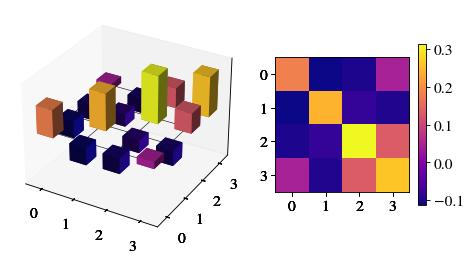

In [7]:
#Test
astate = random_rho(pure=False)
# Tr(rho)
np.round(np.trace(astate),2)
# Tr(rho^2)
np.round(np.trace(astate.dot(astate)),2)
plot_dm(np.real(astate))

### Bloch vector method

In [8]:
# # Pauli matrices
# s1 = np.array([[0,1],[1,0]])
# s2 = np.array([[0,-1j],[1j,0]])
# s3 = np.array([[1,0],[0,-1]])

# pauli_matrices = np.array([s1, s2, s3])

# def random_bloch(pure):
#     if pure:
#         r = 1
#     else:
#         r = np.random.uniform(low=0, high=1)
#     phi, theta = np.random.uniform(low=0, high=1, size=2)
#     phi *= 2*np.pi
#     theta *= np.pi
#     return r * np.array([   np.cos(phi)*np.sin(theta),
#                             np.sin(phi)*np.sin(theta),
#                             np.cos(theta)
#                         ])

# def bloch2mat(vec):
#     assert vec.shape[0] == 3
#     r_sig = vec[0] * s1 + vec[1] * s2 + vec[2] * s3
#     return np.array((np.eye(2) + r_sig) /2)

# def mat2bloch(rho):
#     x = np.trace(rho.dot(s1))
#     y = np.trace(rho.dot(s2))
#     z = np.trace(rho.dot(s3))
#     return np.real(np.array([x, y, z]))


# # Testing
# print("Pure state")
# test_1q = random_bloch(pure=True)
# test_1q
# np.linalg.norm(test_1q)
# plot_dm(np.real(bloch2mat(test_1q)))

# print("Mixed state")
# test_1q = random_bloch(pure=False)
# test_1q
# np.linalg.norm(test_1q)
# plot_dm(np.real(bloch2mat(test_1q)))

# print('bloch2mat2bloch')
# test_1q
# mat2bloch(bloch2mat(test_1q))

## Trace Distributions

### Mixed states from partial trace

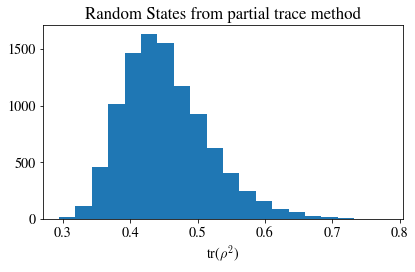

In [9]:
n = 10000
traces = np.array([random_rho(pure=False) for _ in range(n)])
traces = np.array([np.trace(rho.dot(rho)) for rho in traces])
a=plt.hist(np.real(traces), bins=20)
a=plt.xlabel('tr($\\rho^2$)')
a=plt.title('Random States from partial trace method')

# if NQ == 1:
#     n = 10000
#     traces = np.array([bloch2mat(random_bloch(pure=False)) for _ in range(n)])
#     traces = np.array([np.trace(rho.dot(rho)) for rho in traces])
#     a=plt.hist(np.real(traces), bins=20)
#     a=plt.xlabel('tr($\\rho^2$)')
#     a=plt.title('Random States from bloch vector method')

In [10]:
# Retrieve independent values from density matrix

## Treat complex numbers as 2 independent floating numbers for processing in network
## Processing complex units is not yet implemented to pytorch

def rho2torch(rho):
    dim = 2**NQ
    rho = rho.reshape(dim, dim)
    diags = np.array([np.real(rho[i,i]) for i in range(dim-1)])
    ur = np.array([])
    for i in range(dim-1):
        ur = np.hstack((ur, rho[i][i+1:dim]))
    ur = np.hstack((np.real(ur), np.imag(ur)))
    return np.hstack((diags, ur))

def torch2rho(tensor):
    dim = 2**NQ
    diag_coeff = np.array(tensor[:dim-1])
    norm_coeff = 1 - np.sum(diag_coeff)
    diags = np.hstack((diag_coeff, norm_coeff))
    diags = np.diag(diags)

    num_ur_entries = np.sum(np.arange(dim))
    ur_real = tensor[dim-1:dim-1+num_ur_entries]
    ur_imag = tensor[dim-1+num_ur_entries:]

    ur = np.zeros((dim,dim), dtype='complex64')
    for i in range(num_ur_entries):
        for j in range(i+1, dim):
            ur[i,j] = ur_real[0] + 1.j* ur_imag[0]
            ur_real = np.delete(ur_real, 0)
            ur_imag = np.delete(ur_imag, 0)
    return diags + ur + ur.T.conjugate()

# Test
astate = np.round(random_rho(pure=False), NQ)
bstate = torch2rho(rho2torch(astate))

print("Do rho and rho2torch2rho coincide?")
np.all((astate - bstate) < 1e10)

Do rho and rho2torch2rho coincide?


True

# Measurement
using random states generated by partial trace method

## Create random set of observables

Goal: overcomplete measurements that allow full determination of rho from random observables

In [27]:
def create_random_obs(pure, n=100):
    return np.array([random_rho(pure=pure) for _ in range(n)])

def perform_measurements(rho, observables):
    return np.real( np.trace(observables.dot(rho), axis1=1, axis2=2) )

mean = 0.2504295372971632
std = 0.05030806061648604


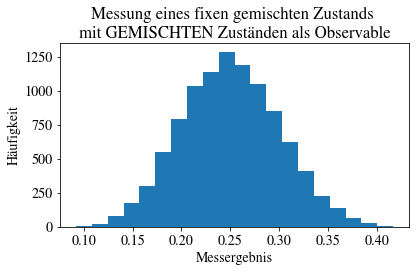

In [28]:
base_state = random_rho(pure=False)
observables = create_random_obs(pure=False, n=10000)

meas = perform_measurements(base_state, observables)
print('mean =', meas.mean())
print('std =', meas.std())

a=plt.hist(meas, bins=20)
a=plt.title('Messung eines fixen gemischten Zustands \nmit GEMISCHTEN Zuständen als Observable')
a=plt.xlabel('Messergebnis')
a=plt.ylabel('Häufigkeit')
#a=plt.xlim(0,1)

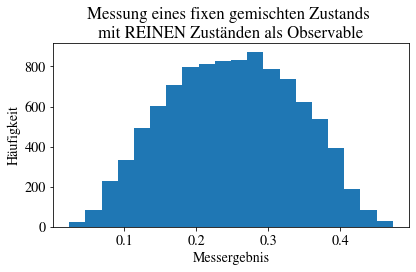

In [29]:
base_state = random_rho(pure=False)
observables = create_random_obs(pure=True, n=10000)

meas = perform_measurements(base_state, observables)


a=plt.hist(meas, bins=20)
a=plt.title('Messung eines fixen gemischten Zustands \nmit REINEN Zuständen als Observable')
a=plt.xlabel('Messergebnis')
a=plt.ylabel('Häufigkeit')

## Create Dataset

with same observables!

In [30]:
# Set parameters for new dataset
n_states = int(1e4)
exp_title = 'tomo0607'
obs_arr = [100]

In [31]:
# # Generate folders
# experiment_name = exp_title + f'_{NQ}qubit_'+ state_gen_method
# if not os.path.isdir('./data/' + experiment_name):
#     os.mkdir('./data/' + experiment_name)

# for nobs in tqdm(obs_arr):
#   for _ in range(10):
#     n_observables = nobs
#     observables = create_random_obs(pure=True, n=n_observables)
#     states = np.array([random_rho(pure=False) for _ in range(n_states)])
#     states_freeparams = np.array([rho2torch(rho) for rho in states])    # Reduce rho to free parameters


#     # Write out dataset

#     timestamp = dtime.now().strftime("%Y%m%d_%H%M%S")
#     PARENTPATH = f"./data/"+ experiment_name + f'/states{n_states}_obs{n_observables}/'
#     DATAPATH = PARENTPATH+f"run_{timestamp}/"
#     if not os.path.isdir(PARENTPATH):
#       os.mkdir(PARENTPATH)
#     os.mkdir(DATAPATH)

#     # Write out states
#     with open(DATAPATH + 'states_freeparams.csv', 'w') as f:
#       writer = csv.writer(f)
#       for state in tqdm(states_freeparams):
#         a=writer.writerow(state)
        
#     # Write out observables
#     with open(DATAPATH + 'observables.csv', 'w') as f:
#       writer = csv.writer(f)
#       for obs in tqdm(observables):
#         a=writer.writerow(obs.reshape(4**(NQ)))

#     # Write out measurements 
#     with open(DATAPATH + 'measurements.csv', 'w') as f:
#       writer = csv.writer(f)
#       for state in tqdm(states):
#         a=writer.writerow(perform_measurements(state, observables))

#     # Wait a sec so the next dataset gets a new name
#     time.sleep(1)



# FFN Tomography

### Prepare dataset

In [32]:
class QuantumMeasurementDataset(Dataset):
    def __init__(self, root_dir):
        self.measurements_frame = pd.read_csv(root_dir + 'measurements.csv', header=None)
        self.states_frame = pd.read_csv(root_dir + 'states_freeparams.csv', header=None)

    def __len__(self):
        return len(self.states_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        measurement = self.measurements_frame.iloc[idx]
        measurement = np.array(measurement).astype('float')
        measurement = torch.Tensor(measurement)

        state = self.states_frame.iloc[idx]
        state = np.array(state).astype('float')
        state = torch.Tensor(state)

        return measurement, state


In [33]:
def load_dataset(datadir, nstat, BATCH_SIZE = 64, splits = np.array([0.8, 0.1, 0.1])):
    # Train_valid_treasure split
    assert np.sum(splits) == 1

    tomography_dataset = QuantumMeasurementDataset(root_dir=datadir)
    tomography_train_dataset, tomography_valid_dataset, tomography_treasure_dataset = torch.utils.data.random_split(\
        tomography_dataset, (nstat*splits).astype(int), generator=torch.Generator().manual_seed(42))

    # Create data loaders from the datasets for the current task
    # Setting drop_last=True does not consider the last batch in which there are less than BATCH_SIZE examples
    tomography_train_dataloader = DataLoader(tomography_train_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
    tomography_valid_dataloader = DataLoader(tomography_valid_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
    tomography_treasure_dataloader = DataLoader(tomography_treasure_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
    return tomography_train_dataloader, tomography_valid_dataloader, tomography_treasure_dataloader 

## Feed Forward Network

Measurement outcomes --> bloch representation of state

In [34]:
# Check if the GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [35]:
class FeedForwardNet(nn.Module):

  def __init__(self, n_obs):
    super().__init__()

    self.dof = 4**NQ - 1
    self.layer_sizes = [n_obs, 64, 32]
    
    self.layers = nn.Sequential(
    nn.Linear(self.layer_sizes[0], self.layer_sizes[1]),
    nn.ReLU(),
    nn.Linear(self.layer_sizes[1], self.layer_sizes[2]),
    nn.ReLU(),
    nn.Linear(self.layer_sizes[2], self.dof),
    )

  def forward(self, x):
    return self.layers(x)

## Training

In [36]:
def evaluate_mse_ffn(net, dataloader, criterion, device):
    batch_loss = np.array([])
    for batch in dataloader:
        measurements, target = batch[0].to(device), batch[1].to(device)
        outputs = net(measurements)
        loss = criterion(outputs, target).clone().detach().cpu().numpy()
        batch_loss = np.append(batch_loss, loss)
    return np.mean(batch_loss)

In [37]:
# Function for training the network
def train(net, train_epochs, train_dataloader, valid_dataloader, optimizer, criterion):

    train_losses = np.array([])
    valid_losses = np.array([])

    for epoch in trange(train_epochs):
        net.train()
        for batch_idx, samples in enumerate(train_dataloader):
            data, target = samples[0].to(device), samples[1].to(device)
            # Optimize parameters
            net.zero_grad()
            outputs = net(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            train_losses = np.append(train_losses, loss.clone().detach().cpu().numpy())

            # Check loss on validation set
            valid_losses = np.append(valid_losses, evaluate_mse_ffn(net, valid_dataloader, criterion, device))
    return train_losses, valid_losses

In [38]:
def plot_train_stats(train_losses, valid_losses, it_per_epoch, path):
    a=plt.figure(figsize=(10,4))
    a=plt.plot(train_losses, lw=2, label='Training Loss on current batch')
    a=plt.xlabel('Iterations')
    a=plt.ylabel('Loss')
    a=plt.yscale('log')
    a=plt.legend()
    a=plt.title(f'Loss on training set \t (MSE, 1 epoch = {it_per_epoch} iterations)')
    a=plt.savefig(path + '/train_losses.png', dpi=150)
    plt.show()

    a=plt.figure(figsize=(10,4))
    a=plt.plot(valid_losses, lw=2, label='Validation Loss on full validation set')
    a=plt.xlabel('Iterations')
    a=plt.ylabel('Loss')
    a=plt.yscale('log')
    a=plt.legend()
    a=plt.title(f'Loss on Validation set  \t (MSE, 1 epoch = {it_per_epoch} iterations)')
    a=plt.savefig(path + '/valid_losses.png', dpi=150)
    plt.show()

In [39]:
def ffn_wrapper(data_dir, model_title, nstat, nobs, nepochs, learning_rate, batch_size, splits = np.array([0.8, 0.1, 0.1])):
    run_name = re.search('([^\/]+$)', data_dir[:-1]).group(0)
    tomography_train_dataloader, tomography_valid_dataloader, _ = load_dataset(data_dir, nstat, batch_size, splits)

    # Create the network on the CPU/GPU
    net = FeedForwardNet(n_obs=nobs).to(device)
    print(net)

    # Loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    # Perform Training
    train_losses, valid_losses = train(net, nepochs, tomography_train_dataloader, tomography_valid_dataloader, optimizer, criterion)

    # Save Model
    path = f'./models/FFN_states{int(nstat)}_obs{nobs}_epochs{nepochs}_lr{learning_rate}_{model_title}_{run_name}'
    if not os.path.isdir(path): os.mkdir(path)
    torch.save(net.state_dict(), path + '/model.model')

    # Plot training statistics
    plot_train_stats(train_losses, valid_losses, it_per_epoch = len(tomography_train_dataloader), path=path)


In [40]:
def train_multiple_runs(dataexp_path, model_title, nstat, obs_arr, bs, lr, nepochs):
    hyperparameter_dir = [f'states{int(nstat)}_obs{n_obs}' for n_obs in obs_arr]
    for nobs, hdir in zip(obs_arr, hyperparameter_dir):
        hpath = dataexp_path + '/' + hdir
        run_directories = [f for f in os.listdir(hpath) if os.path.isdir(os.path.join(hpath, f))]
        for rdir in run_directories:
            run_path = hpath + '/' + rdir + '/'
            ffn_wrapper(data_dir = run_path,
                        model_title=model_title,
                        nstat=nstat,
                        nobs=nobs,
                        nepochs=nepochs,
                        learning_rate=lr, 
                        batch_size=bs, 
                        splits = np.array([0.8, 0.1, 0.1]))

In [41]:
# train_multiple_runs(dataexp_path='./data/tomo0607_2qubit_random_uniform_vector',
#                     model_title='ConstLatentDimension',
#                     nstat=int(1e4), 
#                     obs_arr=np.array([12, 15, 20]), 
#                     bs=64,
#                     lr=1e-3,
#                     nepochs=15)

## Evaluation

performance on unseen data (treasure set)

comparison between untrained and trained net

### Single Model


In [42]:
nstat = int(1e4)
nobs = 3
model_path = './models/FFN_states10000_obs3_epochs1_lr0.001_ConstLatentDimension_run_20220604_092932'
data_path = './data/tomo0604_1qubit_random_uniform_vector/states10000_obs3/run_20220604_092923'

In [43]:
load_net = FeedForwardNet(n_obs=nobs).to(device)
load_net.load_state_dict(torch.load(model_path+'/model.model'))
_, _, tomography_treasure_dataloader = load_dataset(datadir=data_path+'/', nstat=nstat)

print('Mean Square Error of on unseen data')
untrained_net = FeedForwardNet(n_obs=nobs).to(device)
print('Untrained Net: ', evaluate_mse_ffn(
    untrained_net, tomography_treasure_dataloader,nn.MSELoss(),device))
print('Trained Net: ', evaluate_mse_ffn(
    load_net, tomography_treasure_dataloader, nn.MSELoss(), device))

FileNotFoundError: [Errno 2] No such file or directory: './models/FFN_states10000_obs3_epochs1_lr0.001_ConstLatentDimension_run_20220604_092932/model.model'

### Evaluate Multiple
Load trained models for different numbers of observables and evaluate their error on the ```tomography_treasure_dataloader```

model_performance -> run performance -> performances

In [44]:
def treasure_evaluation(nobservables, model_path, dataloader):
    load_net = FeedForwardNet(n_obs=nobservables).to(device)
    load_net.load_state_dict(torch.load(model_path+'/model.model'))

    return evaluate_mse_ffn(load_net, dataloader, nn.MSELoss(), device)

def evaluate_multiple(dataexp_path, model_title, nstat, obs_arr, num_runs, return_run_names=False):

    performances = np.zeros((0, num_runs))
    run_names = np.array([])
    all_model_names = [f for f in os.listdir('./models') if model_title in f]
    for nobs in obs_arr:
        run_perf = np.array([])
        obs_model_names = [f for f in all_model_names if (f'obs{nobs}_' in f)]
        for mn in obs_model_names:
            model_path = './models/' + mn
            run_name = re.search('([^(run)]+$)', model_path).group(0)
            run_names = np.append(run_names, 'run'+run_name)
            data_path = dataexp_path + f'/states{int(nstat)}_obs{nobs}/run{run_name}/'
            try:
                _,_,treasure_dataloader = load_dataset(datadir=data_path, nstat=nstat)
                model_perf = treasure_evaluation(nobs, model_path, treasure_dataloader)
                run_perf = np.append(run_perf, model_perf)
            except:
                None
        performances = np.vstack((performances, run_perf))

    if return_run_names:
        return performances, run_names
    return performances

In [45]:
# Test
evaluate_multiple(dataexp_path='./data/tomo0604_1qubit_random_uniform_vector',
                    model_title='ConstLatentDimension',
                    nstat=1e4, 
                    obs_arr=[3,25],
                    num_runs=10)

## reproducible with single evaluation?
load_net = FeedForwardNet(n_obs=25).to(device)
modelpath = './models/FFN_states10000_obs25_epochs15_lr0.001_ConstLatentDimension_run_20220604_092917/model.model'
load_net.load_state_dict(torch.load(modelpath))

datapath = '/Users/canrager/thesis/data/tomo0604_1qubit_random_uniform_vector/states10000_obs25/run_20220604_092917/'
_,_,tomography_treasure_dataloader = load_dataset(datadir=datapath, nstat=10000)

print('Trained Net: ', evaluate_mse_ffn(
    load_net, tomography_treasure_dataloader, nn.MSELoss(), device))

#OK

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 10 and the array at index 1 has size 0

In [46]:
# obs_arr = [3, 25, 50, 75, 100]

# performances = evaluate_multiple(dataexp_path='./data/tomo0604_1qubit_random_uniform_vector',
#                     model_title='ConstLatentDimension',
#                     nstat=1e4, 
#                     obs_arr=obs_arr,
#                     num_runs=10)
# performances
# perf_means = np.mean(performances, axis=1)
# perf_merr = np.std(performances, axis=1)/np.sqrt(10)

# plt.errorbar(obs_arr, perf_means, yerr=perf_merr)
# plt.xlabel('Number of PVMs')
# plt.ylabel('Mean squared error')
# plt.yscale('log')
# plt.grid()

### Evaluation for custom Projectors

In [47]:
def custom_obs_dataset(dataexp_title, n_states, observables, n_runs):
    for _ in range(n_runs):
        experiment_name = dataexp_title + f'_{NQ}qubit_'+ state_gen_method
        if not os.path.isdir('./data/' + experiment_name):
            os.mkdir('./data/' + experiment_name)
        states = np.array([random_rho(pure=False) for _ in range(n_states)])
        states_freeparams = np.array([rho2torch(rho) for rho in states])    # Reduce rho to free parameters

        # Write out dataset

        timestamp = dtime.now().strftime("%Y%m%d_%H%M%S")
        PARENTPATH = f"./data/"+ experiment_name + f'/states{n_states}_obs{len(observables)}/'
        DATAPATH = PARENTPATH+f"run_{timestamp}/"
        if not os.path.isdir(PARENTPATH):
            os.mkdir(PARENTPATH)
        os.mkdir(DATAPATH)

        # Write out states
        with open(DATAPATH + 'states_freeparams.csv', 'w') as f:
            writer = csv.writer(f)
            for state in tqdm(states_freeparams):
                a=writer.writerow(state)
            
        # Write out observables
        with open(DATAPATH + 'observables.csv', 'w') as f:
            writer = csv.writer(f)
            for obs in tqdm(observables):
                a=writer.writerow(obs.reshape(4**(NQ)))

        # Write out measurements 
        with open(DATAPATH + 'measurements.csv', 'w') as f:
            writer = csv.writer(f)
            for state in tqdm(states):
                a=writer.writerow(perform_measurements(state, observables))

        # Wait a sec so the next dataset gets a new name
        time.sleep(1)


In [48]:
# Pauli matrices
s1 = np.array([[0,1],[1,0]])
s2 = np.array([[0,-1j],[1j,0]])
s3 = np.array([[1,0],[0,-1]])

n_states = int(1e4)
observables = (np.eye(2) + np.array([s1,s2,s3]))/2
observables

# custom_obs_dataset( dataexp_title='tomo_PAULI_projectors',
#                     n_states=n_states,
#                     observables=observables,
#                     n_runs=10)

array([[[0.5+0.j , 0.5+0.j ],
        [0.5+0.j , 0.5+0.j ]],

       [[0.5+0.j , 0. -0.5j],
        [0. +0.5j, 0.5+0.j ]],

       [[1. +0.j , 0. +0.j ],
        [0. +0.j , 0. +0.j ]]])

In [49]:
# obs_arr=[3]

# train_multiple_runs(dataexp_path='./data/tomo_PAULI_projectors_1qubit_random_uniform_vector',
#                     model_title='PAULI_projectors',
#                     nstat=int(1e4), 
#                     obs_arr=obs_arr, 
#                     bs=64,
#                     lr=1e-3,
#                     nepochs=15)

In [50]:
arr = np.array([[7.98335289e-06, 6.53353397e-06, 5.29218610e-06, 6.94540422e-06,
        6.46792390e-06, 8.35120563e-06, 6.64965549e-06, 8.96846310e-06,
        6.51081403e-06, 1.02456272e-05]])

np.mean(arr)
np.std(arr)/np.sqrt(len(arr))

7.394816653e-06

1.3937442126118205e-06

In [51]:
performances = evaluate_multiple(dataexp_path='./data/tomo_PAULI_projectors_1qubit_random_uniform_vector',
                    model_title='PAULI_projectors',
                    nstat=1e4, 
                    obs_arr=[3],
                    num_runs=10)
performances
perf_means = np.mean(performances, axis=1)
perf_merr = np.std(performances, axis=1)/np.sqrt(10)

perf_means
perf_merr

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 10 and the array at index 1 has size 0

### Comparison Plot

In [52]:
obs_arr = [3, 25, 50, 75, 100] + [1, 2, 4, 5, 7, 10, 15, 20, 30, 40, 60, 70, 80, 90]
len(obs_arr)

performances = evaluate_multiple(dataexp_path='./data/tomo0604_1qubit_random_uniform_vector',
                    model_title='ConstLatentDimension',
                    nstat=1e4, 
                    obs_arr=obs_arr,
                    num_runs=10)            
perf_means = np.mean(performances, axis=1)
perf_merr = np.std(performances, axis=1)/np.sqrt(10)

pauli_performances = evaluate_multiple(dataexp_path='./data/tomo_PAULI_projectors_1qubit_random_uniform_vector',
                    model_title='PAULI_projectors',
                    nstat=1e4, 
                    obs_arr=[3],
                    num_runs=10)
pauli_performances
pauli_mean = np.mean(pauli_performances) * np.ones(len(obs_arr))
pauli_merr = np.std(pauli_performances) / len(pauli_performances)

19

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 10 and the array at index 1 has size 0

In [54]:
plt.figure(dpi=150)
plt.errorbar(obs_arr, perf_means, yerr=perf_merr, fmt = 'o', markersize = 2, capsize = 4,\
    label='zufällig generierte PVMs', zorder = 10)
plt.plot(np.linspace(0,120,len(obs_arr)), pauli_mean, c='k', label='Pauli PVMs (Vergleich)')
plt.fill_between(np.linspace(0,120,len(obs_arr)), pauli_mean-pauli_merr, pauli_mean + pauli_merr, color='grey', alpha=.3)
plt.xlabel('Anzahl PVMs')
plt.ylabel('Mittlerer quadratischer Fehler')
plt.yscale('log')
plt.xscale('log')
plt.xlim(0,120)

plt.legend()#loc='center left', bbox_to_anchor=(1,0.5))

<Figure size 900x600 with 0 Axes>

NameError: name 'perf_means' is not defined

<Figure size 900x600 with 0 Axes>

In [55]:
xspace = np.arange(1,len(performances[0])+1)
pauli_mean = np.mean(pauli_performances) * np.ones(len(performances[0]))

plt.figure(dpi=150)
plt.scatter(xspace, performances[0], label='3 zufällige PVMs (einzeln)')
plt.plot(xspace, pauli_mean, c='k', label='3 normale PVMs (gemittelt)')
plt.fill_between(xspace, pauli_mean-pauli_merr, pauli_mean + pauli_merr, color='grey', alpha=.3)
plt.xlabel('Messung Nr.')
plt.ylabel('Mittlerer quadratischer Fehler')
plt.yscale('log')
plt.legend(loc='center left')
plt.xlim(.75, 10.25)
plt.grid()

NameError: name 'performances' is not defined

In [56]:
# Printe observablen der nPVM = 3 messungen

performances, run_names = evaluate_multiple(dataexp_path='./data/tomo0604_1qubit_random_uniform_vector',
                    model_title='ConstLatentDimension',
                    nstat=1e4, 
                    obs_arr=[3],
                    num_runs=10,
                    return_run_names=True) 

def retrieve_observables(data_path, run_directories):
    observables = np.empty((0,3,2,2))
    for rdir in run_directories:
        run_path = data_path + '/' + rdir + '/'
        dim = 2**NQ
        data_obs = np.zeros((0,dim,dim))
        with open(run_path+'/observables.csv', 'r') as f:
            reader = csv.reader(f)
            for line in reader:
                data_obs = np.vstack((data_obs, np.array([np.array(line).reshape(dim,dim).astype('complex128')])))
        observables = np.vstack((observables, [data_obs]))
    return observables, run_directories



observables, run_directories =retrieve_observables('/Users/canrager/thesis/data/tomo0604_1qubit_random_uniform_vector/states10000_obs3',
    run_names)
fidelities = np.array([np.array([np.trace(a.dot(b)), np.trace(c.dot(b)), np.trace(a.dot(c))]) for a,b,c in observables])
np.sum(np.imag(fidelities))
fidelities = np.real(fidelities)

#Colorbar
fig, ax = plt.subplots(dpi=150)
cmap = cm.get_cmap('inferno')
norm = Normalize(vmin=np.min(fidelities), vmax=np.max(fidelities))
colors = cmap(norm(1))
a=sc = cm.ScalarMappable(cmap=cmap,norm=norm)
a=sc.set_array([])
a=plt.colorbar(sc)

ax.imshow(fidelities.T,cmap=cmap)
ax.set_xticks(np.arange(10), run_directories, rotation='vertical')
plt.show()

np.vstack((performances.flatten(),run_names)).T

pauli_fidelities = np.real(np.array([[np.trace(s1.dot(s2)), np.trace(s1.dot(s3)), np.trace(s2.dot(s3))]]))

plt.imshow(pauli_fidelities, cmap=cmap)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 10 and the array at index 1 has size 0

In [57]:
a,b,c = observables[0]
np.trace(a.dot(b.dot(c)))
c


ValueError: not enough values to unpack (expected 3, got 2)

## Inference

In [44]:
nobs = 3
model_path = './models/FFN_states10000_obs3_epochs15_lr0.001_ConstLatentDimension_run_20220604_092923'
data_path = './data/tomo0604_1qubit_random_uniform_vector/states10000_obs3/run_20220604_092923'

In [45]:
# Load Model
load_net = FeedForwardNet(n_obs=nobs).to(device)
load_net.load_state_dict(torch.load(model_path+'/model.model'))

# Import Observables
dim = 2**NQ
data_obs = np.zeros((0,dim,dim))
with open(data_path+'/observables.csv', 'r') as f:
  reader = csv.reader(f)
  for line in tqdm(reader):
    data_obs = np.vstack((data_obs, np.array([np.array(line).reshape(dim,dim).astype('complex128')])))

<All keys matched successfully>

3it [00:00, 1550.38it/s]


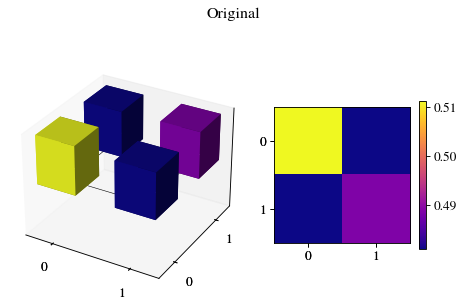

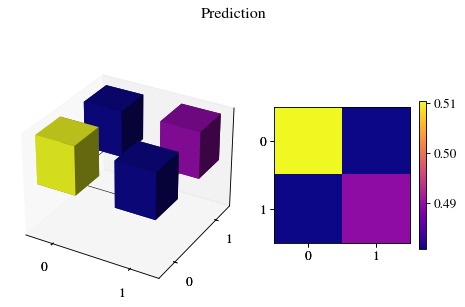

In [53]:
rho_infer = random_rho(pure=False)
m_infer = torch.Tensor(perform_measurements(rho_infer, data_obs))
freeparam_pred = load_net.forward(m_infer.to(device)).detach().cpu().numpy()
rho_pred = torch2rho(freeparam_pred)

plot_dm(np.real(rho_infer), title='Original')
plot_dm(np.real(rho_pred), title='Prediction')

# AE Compact State Representations

## Autoencoder

In [16]:
class AutoencoderNet(nn.Module):

  def __init__(self, latent_dim, measurement_dim):
    super().__init__()

    self.layer1_size = 64
    self.layer2_size = 32

    self.encoder = nn.Sequential(
    nn.Linear(measurement_dim, self.layer1_size),
    nn.ReLU(),
    nn.Linear(self.layer1_size, self.layer2_size),
    nn.ReLU(),
    nn.Linear(self.layer2_size, latent_dim),
    )

    self.decoder = nn.Sequential(
    nn.Linear(latent_dim, self.layer2_size),
    nn.ReLU(),
    nn.Linear(self.layer2_size, self.layer1_size),
    nn.ReLU(),
    nn.Linear(self.layer1_size, measurement_dim),
    )

  def forward(self, x):
    minrep = self.encoder(x)
    output = self.decoder(minrep)
    return output
  
  def encode(self, x):
    return self.encoder(x)

## Training

In [58]:
def evaluate_mse_ae(net, dataloader, criterion, device):
    batch_loss = np.array([])
    for batch in dataloader:
        measurements = batch[0].to(device)
        outputs = net(measurements)
        loss = criterion(outputs, measurements).clone().detach().cpu().numpy()
        batch_loss = np.append(batch_loss, loss)
    return np.mean(batch_loss)

In [59]:
# Function for training the network
def ae_train(net, train_epochs, train_dataloader, valid_dataloader, optimizer, criterion):

    train_losses = np.array([])
    valid_losses = np.array([])

    for epoch in trange(train_epochs):
        net.train()
        for batch_idx, samples in enumerate(train_dataloader):
            data, target = samples[0].to(device), samples[1].to(device)
            # Optimize parameters
            net.zero_grad()
            outputs = net(data)

            loss = criterion(outputs, data)
            

            loss.backward()
            optimizer.step()
            train_losses = np.append(train_losses, loss.clone().detach().cpu().numpy())

            # Check loss on validation set
            valid_losses = np.append(valid_losses, evaluate_mse_ae(net, valid_dataloader, criterion, device))

    return train_losses, valid_losses

In [60]:
def ae_train_eval(data_dir,
                  model_title,
                  nstat,
                  nobs,
                  latent_size, 
                  learning_rate, 
                  nepochs):

    print(data_dir,
                  model_title,
                  nstat,
                  nobs,
                  latent_size, 
                  learning_rate, 
                  nepochs)

    run_name = re.search('([^\/]+$)', data_dir[:-1]).group(0)
    train_dataloader, valid_dataloader, treasure_dataloader = load_dataset(data_dir+'/', nstat)

    # Create the network on the CPU/GPU
    ae_net = AutoencoderNet(measurement_dim=nobs, latent_dim=latent_size).to(device)
    print(ae_net)

    # Loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(ae_net.parameters(), lr=learning_rate)

    #Do training
    train_losses, valid_losses = ae_train(  ae_net, 
                                            nepochs, 
                                            train_dataloader, 
                                            valid_dataloader, 
                                            optimizer, 
                                            criterion)


    print(train_losses)
    # Log the loss on the unseen set                  
    treasure_loss = evaluate_mse_ae(ae_net, treasure_dataloader, criterion, device)

    # Save Model
    path = f'./models/AE_states{int(nstat)}_obs{nobs}_latentdim{latent_size}_epochs{nepochs}_lr{learning_rate}_{model_title}_{run_name}'
    if not os.path.isdir(path): os.mkdir(path)
    torch.save(ae_net.state_dict(), path + '/model.model')

    # Plot training statistics
    plot_train_stats(train_losses, valid_losses, it_per_epoch = len(train_dataloader), path=path)

    return treasure_loss


In [61]:
def ae_train_multiple_runs(data_path, model_title, latent_dims, nstat, nobs, lr, nepochs):
    performances = np.array([])

    run_directories = [f for f in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, f))]
    for rdir in run_directories:
        run_path = data_path + '/' + rdir + '/'
        run_perf = np.array([])
        for ldim in latent_dims:
            perf = ae_train_eval(data_dir=run_path,
                            model_title=model_title,
                            nstat=nstat,
                            nobs=nobs,
                            latent_size=ldim, 
                            learning_rate=lr, 
                            nepochs=nepochs)
            print(perf)
            run_perf = np.append(run_perf, perf)
        performances = np.append(performances, run_perf)
    return performances

In [62]:
# ae_perf = ae_train_multiple_runs(data_path='./data/tomo0604_1qubit_random_uniform_vector/states10000_obs100',
#                                     model_title='FindMinDim', 
#                                     latent_dims=[0,1,2,3,4,5,7,9,11], 
#                                     nstat=1e4, 
#                                     nobs=100, 
#                                     lr=1e-3, 
#                                     nepochs=20)

### 2 Qubit training

In [63]:
1500/125

12.0

./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120754/ 2qubit_FindMinDim 10000.0 100 1 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [02:27<00:00, 12.33s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.09069624 0.08446398 0.07968445 ... 0.00977535 0.00906262 0.01031302]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


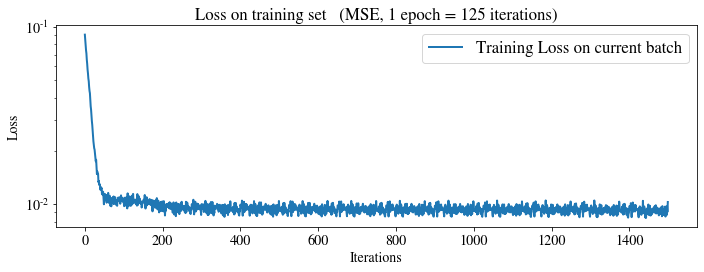

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


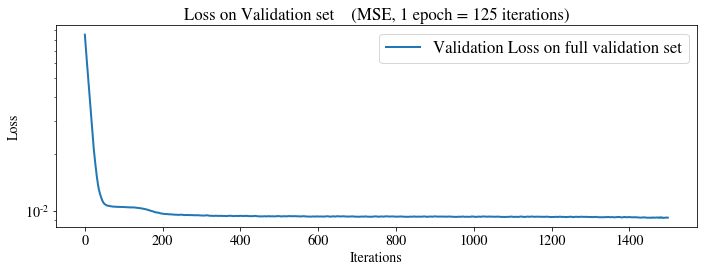

0.008978347666561604
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120754/ 2qubit_FindMinDim 10000.0 100 5 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=5, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=5, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [02:28<00:00, 12.42s/it]


[0.08589018 0.08290529 0.08057731 ... 0.00559666 0.00477979 0.00565494]


/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


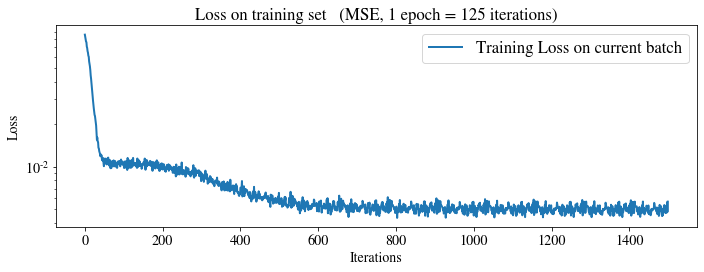

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


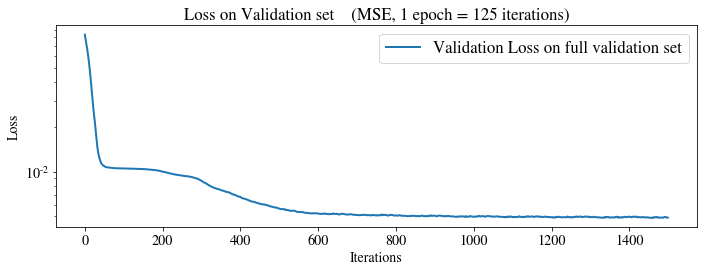

0.004852137000610431
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120754/ 2qubit_FindMinDim 10000.0 100 10 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [02:27<00:00, 12.28s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08046347 0.07800385 0.07565855 ... 0.00246347 0.00220512 0.00249909]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


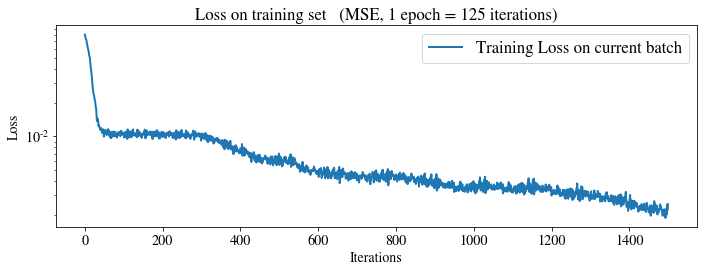

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


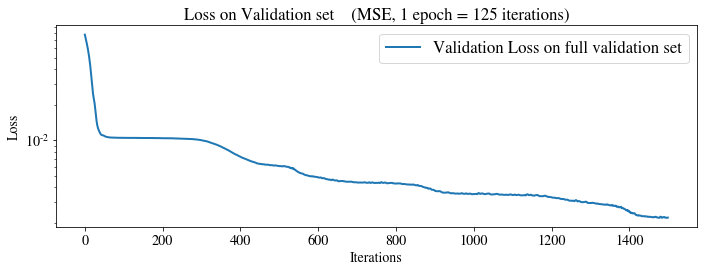

0.002164852673498293
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120754/ 2qubit_FindMinDim 10000.0 100 12 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=12, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=12, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [02:28<00:00, 12.41s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08200458 0.07972298 0.07776476 ... 0.00227067 0.00214169 0.00235094]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


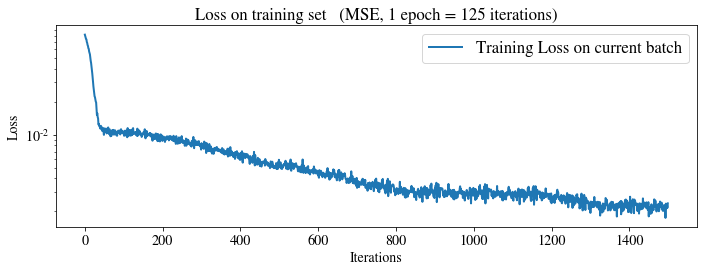

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


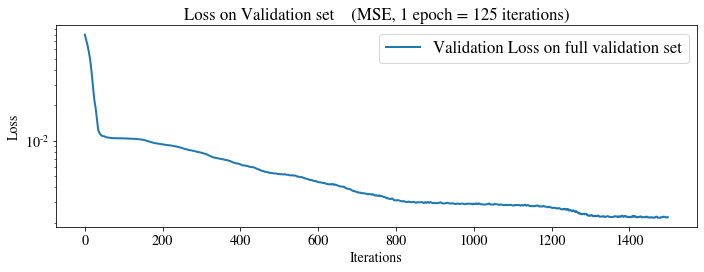

0.002125944624034067
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120754/ 2qubit_FindMinDim 10000.0 100 14 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=14, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=14, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [02:28<00:00, 12.33s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08442045 0.08145076 0.0794697  ... 0.00191766 0.00167274 0.00181528]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


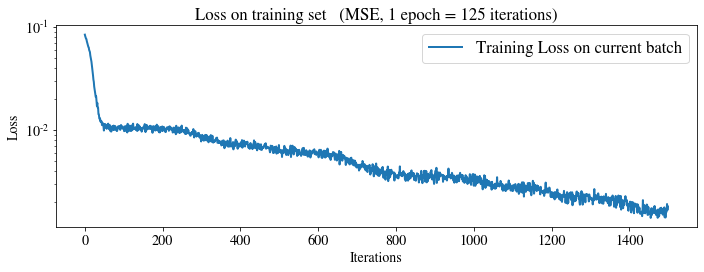

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


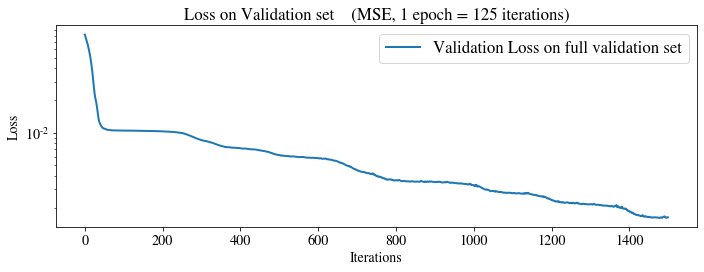

0.0016052318116029105
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120754/ 2qubit_FindMinDim 10000.0 100 15 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=15, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=15, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [02:28<00:00, 12.35s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08255394 0.07917614 0.0770369  ... 0.00230544 0.00224831 0.00241614]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


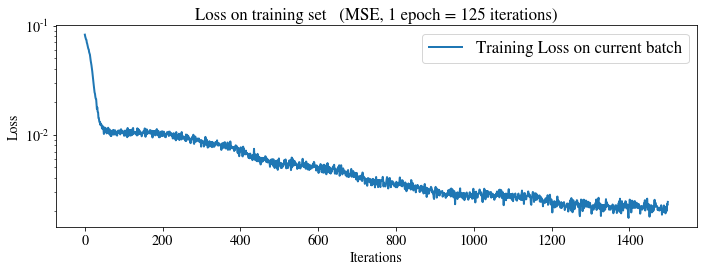

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


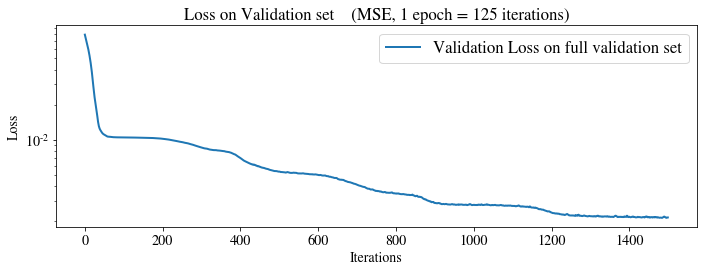

0.002079314971342683
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120754/ 2qubit_FindMinDim 10000.0 100 16 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [02:29<00:00, 12.43s/it]


[0.07598772 0.07308646 0.07097108 ... 0.0010761  0.00117056 0.00116448]


/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


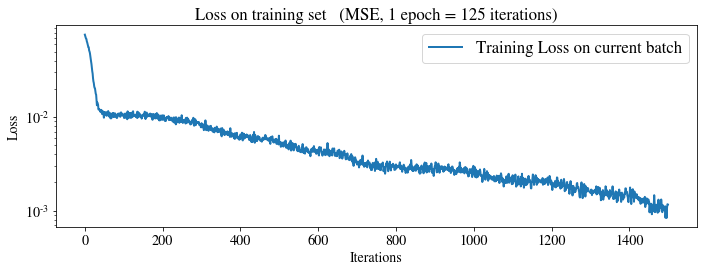

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


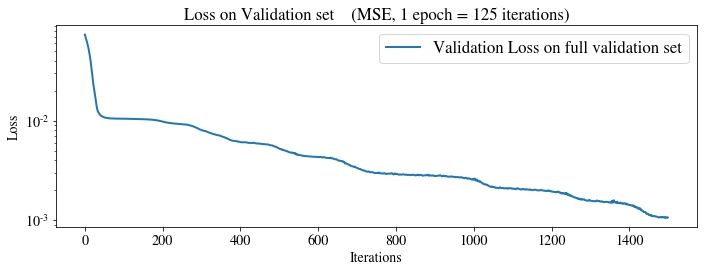

0.0010489546849081913
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120754/ 2qubit_FindMinDim 10000.0 100 18 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=18, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=18, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [02:28<00:00, 12.37s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.06658996 0.06445827 0.06245288 ... 0.00165838 0.00152999 0.00183608]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


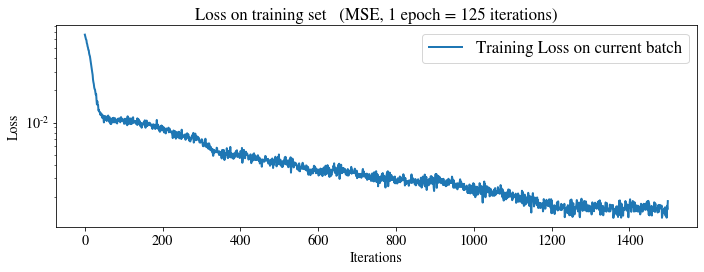

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


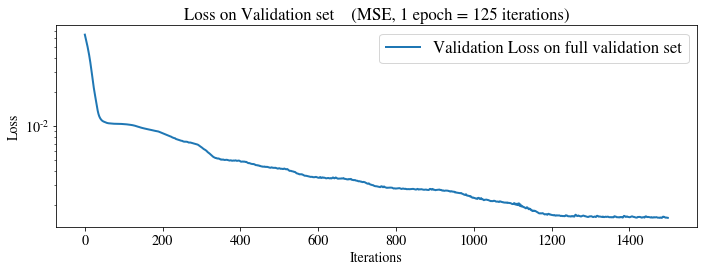

0.0015147432607288162
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120754/ 2qubit_FindMinDim 10000.0 100 20 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [02:33<00:00, 12.76s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08230843 0.07914814 0.07697445 ... 0.00182094 0.00169641 0.00168409]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


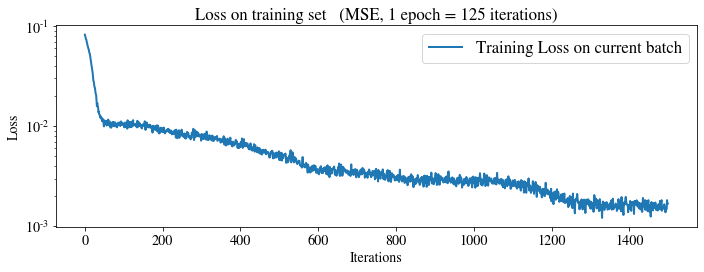

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


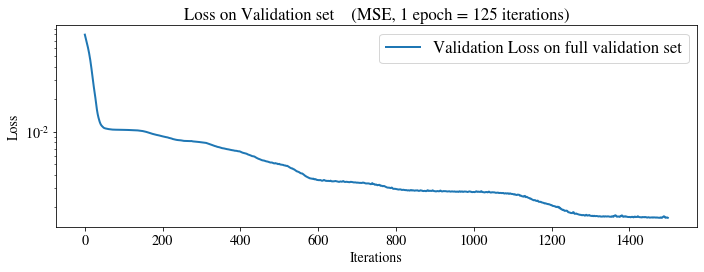

0.0015295390893394747
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120754/ 2qubit_FindMinDim 10000.0 100 25 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=25, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=25, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [02:24<00:00, 12.04s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08190513 0.07903113 0.07692466 ... 0.00185237 0.00176371 0.0017418 ]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


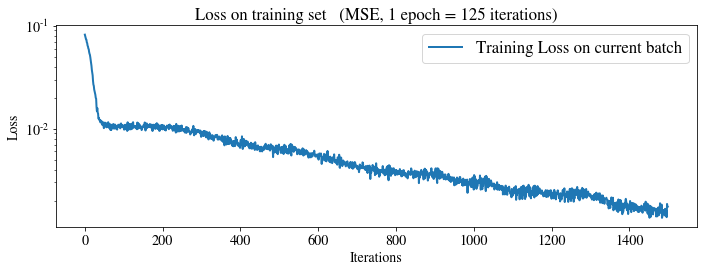

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


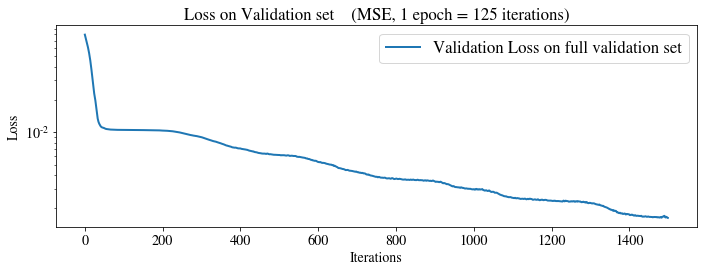

0.0015407948521897197
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120754/ 2qubit_FindMinDim 10000.0 100 30 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=30, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=30, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [02:24<00:00, 12.04s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08032203 0.07772658 0.07603398 ... 0.00124545 0.00111981 0.00129896]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


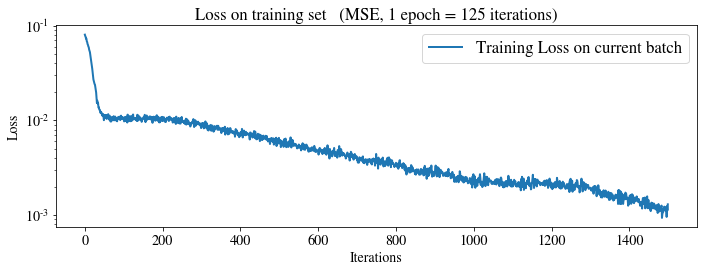

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


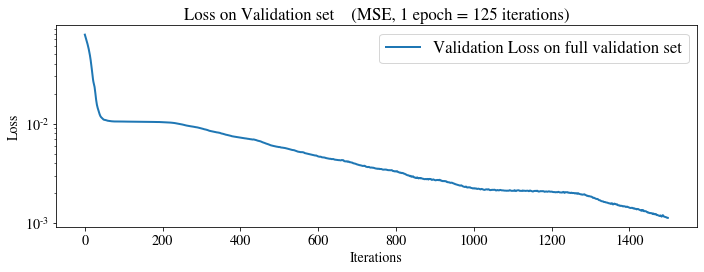

0.001089602456583331
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120819/ 2qubit_FindMinDim 10000.0 100 1 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [02:25<00:00, 12.12s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.09094934 0.08772512 0.08441747 ... 0.00906984 0.00979934 0.00889571]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


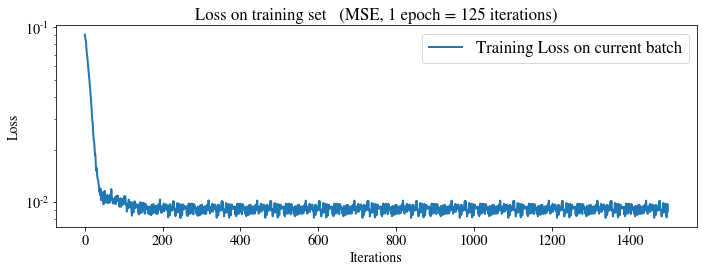

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


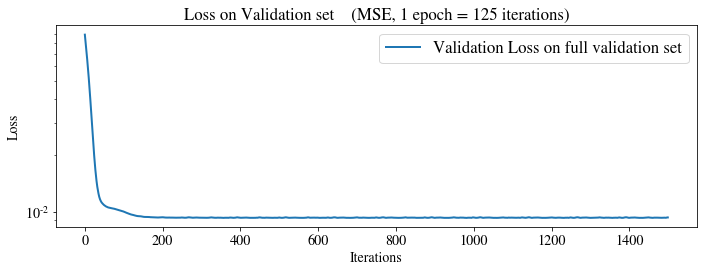

0.009072282227377097
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120819/ 2qubit_FindMinDim 10000.0 100 5 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=5, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=5, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [02:25<00:00, 12.15s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.07969926 0.07749896 0.07546928 ... 0.00451337 0.00474015 0.00484017]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


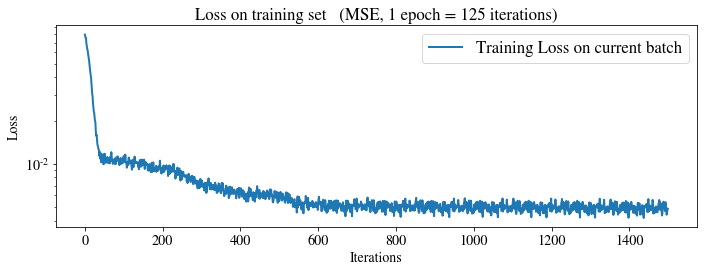

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


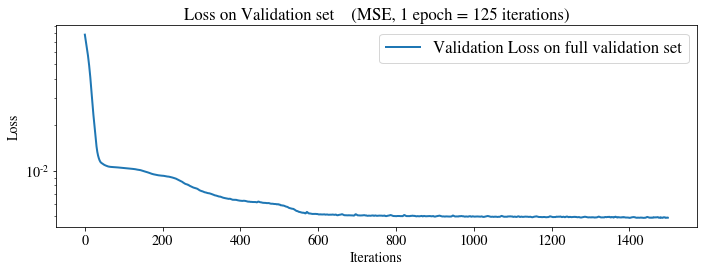

0.004822790281226238
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120819/ 2qubit_FindMinDim 10000.0 100 10 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [02:25<00:00, 12.10s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.07139321 0.06960206 0.06814197 ... 0.00196712 0.00217768 0.00214036]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


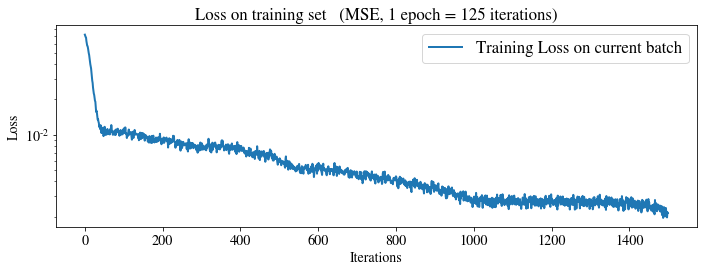

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


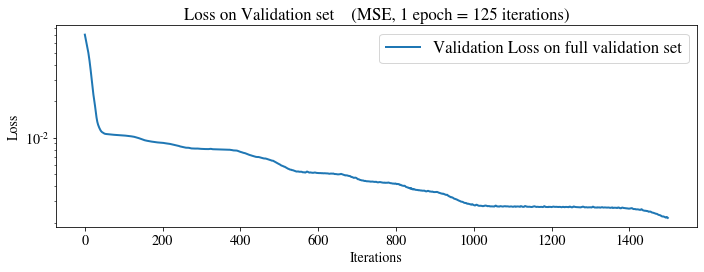

0.002208589700361093
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120819/ 2qubit_FindMinDim 10000.0 100 12 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=12, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=12, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [17:31<00:00, 87.59s/it] 
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.07382242 0.07192128 0.07163295 ... 0.00179041 0.00183422 0.00204867]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


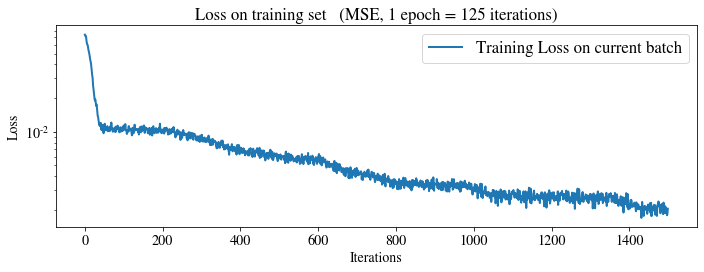

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


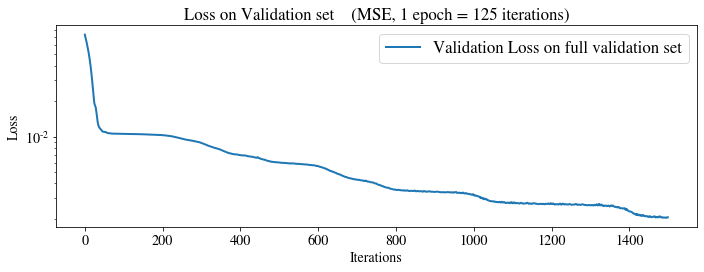

0.0020098544269179304
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120819/ 2qubit_FindMinDim 10000.0 100 14 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=14, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=14, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [30:52<00:00, 154.36s/it]  
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.09037641 0.08710194 0.08507271 ... 0.00190909 0.0018644  0.00204819]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


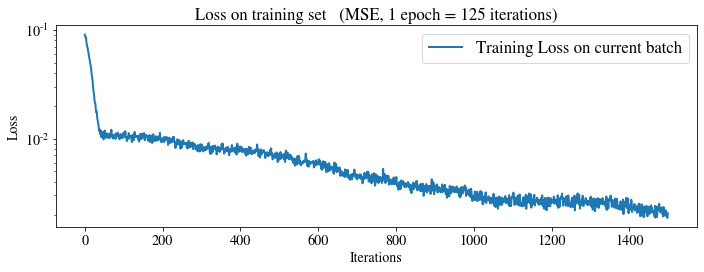

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


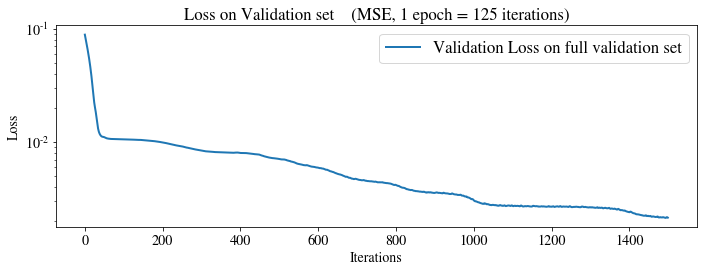

0.0020938622998073696
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120819/ 2qubit_FindMinDim 10000.0 100 15 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=15, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=15, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:27<00:00,  7.32s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.07317135 0.07082219 0.07021309 ... 0.00129757 0.00123589 0.00138398]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


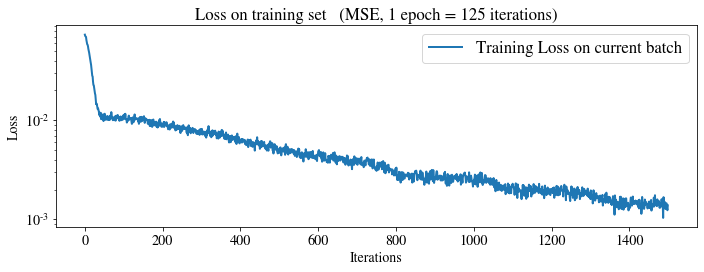

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


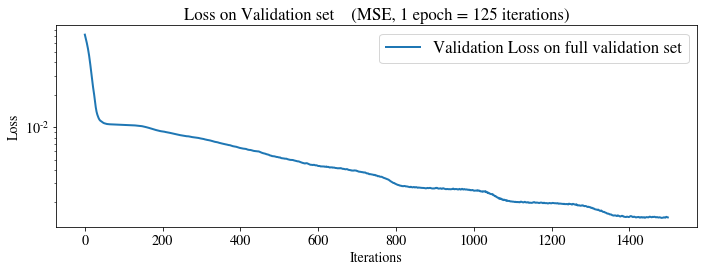

0.0014457819517701865
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120819/ 2qubit_FindMinDim 10000.0 100 16 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:27<00:00,  7.32s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08148129 0.07902707 0.07705076 ... 0.00123287 0.00110761 0.00112705]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


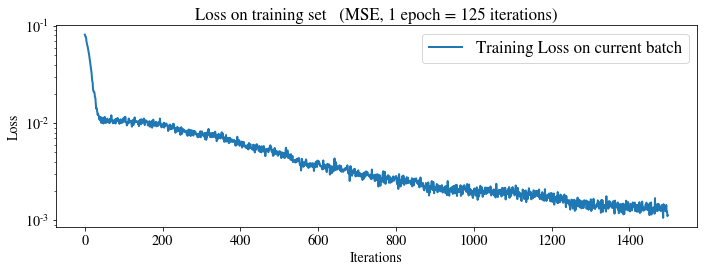

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


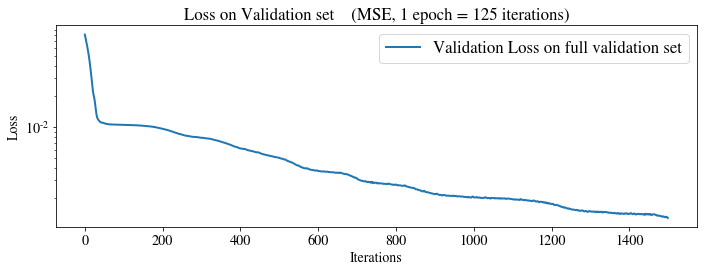

0.0012709172908216715
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120819/ 2qubit_FindMinDim 10000.0 100 18 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=18, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=18, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:27<00:00,  7.32s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.07294293 0.07146373 0.07083277 ... 0.00089811 0.00083601 0.0009174 ]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


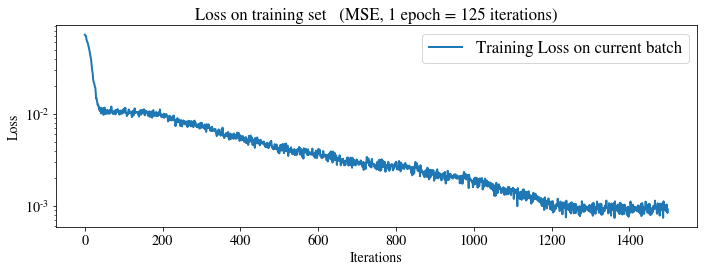

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


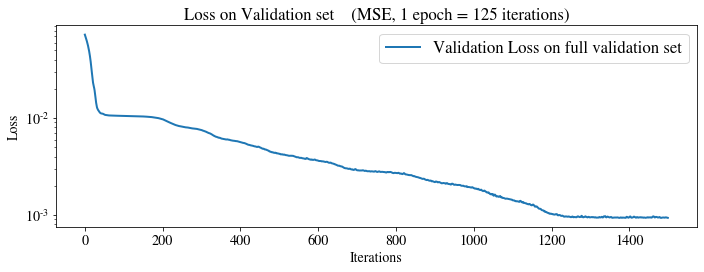

0.0009186934834967057
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120819/ 2qubit_FindMinDim 10000.0 100 20 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:27<00:00,  7.26s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.07619327 0.07496289 0.07406849 ... 0.00215615 0.00225777 0.00249178]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


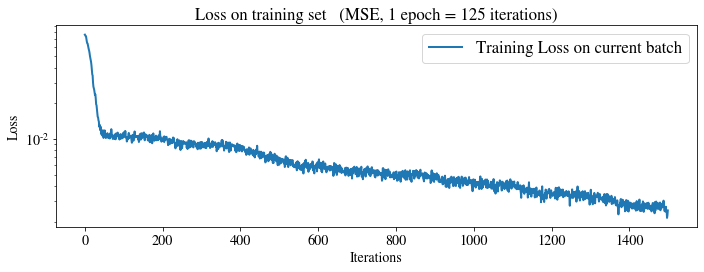

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


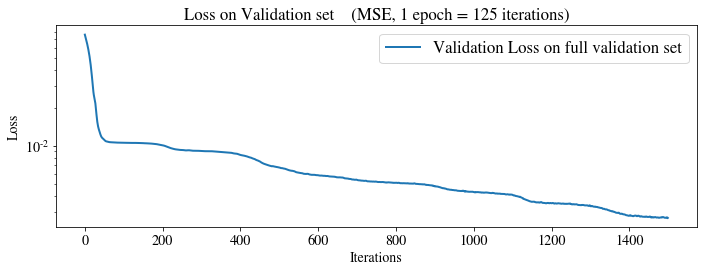

0.002615730324760079
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120819/ 2qubit_FindMinDim 10000.0 100 25 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=25, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=25, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:24<00:00,  7.08s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08314287 0.08105057 0.08002462 ... 0.00131361 0.00113414 0.00128957]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


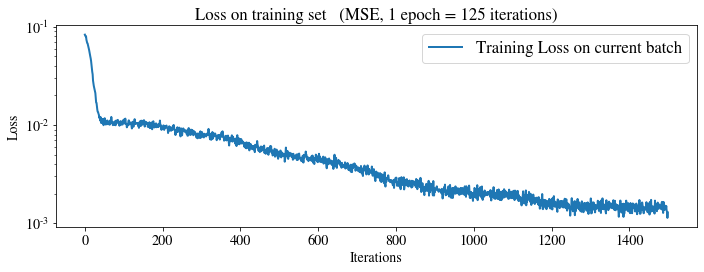

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


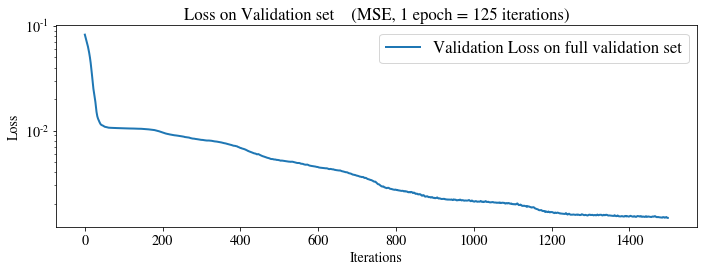

0.0014121895811210075
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120819/ 2qubit_FindMinDim 10000.0 100 30 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=30, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=30, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:25<00:00,  7.11s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08033982 0.07857892 0.07724802 ... 0.0009403  0.00092581 0.00096705]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


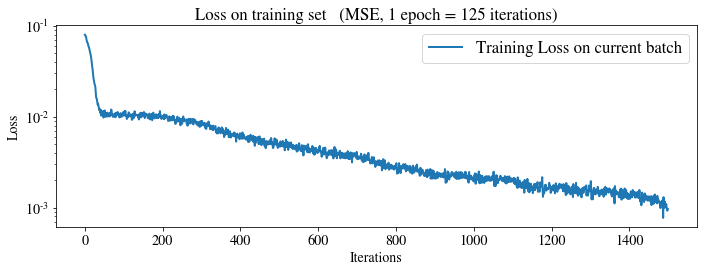

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


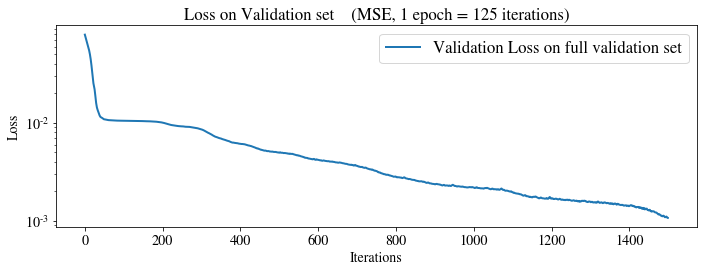

0.0010399344416024785
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120829/ 2qubit_FindMinDim 10000.0 100 1 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:26<00:00,  7.17s/it]


[0.08881705 0.08625826 0.08170533 ... 0.00896918 0.00861854 0.00851534]


/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


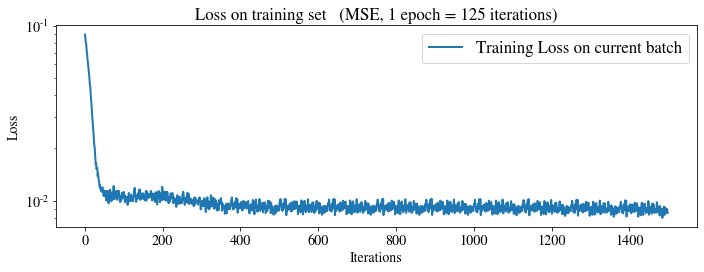

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


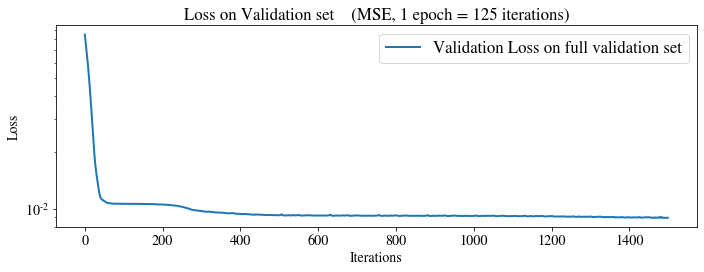

0.008850962047775586
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120829/ 2qubit_FindMinDim 10000.0 100 5 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=5, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=5, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:25<00:00,  7.13s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.082624   0.0816737  0.07868505 ... 0.00503917 0.00420424 0.0047822 ]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


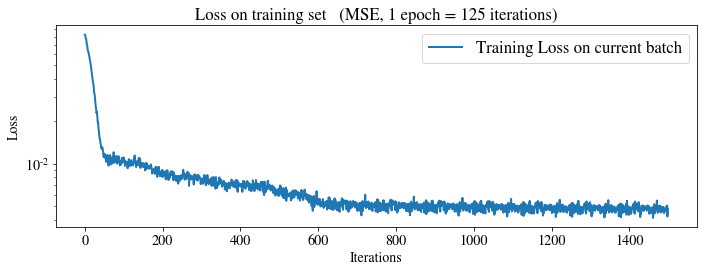

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


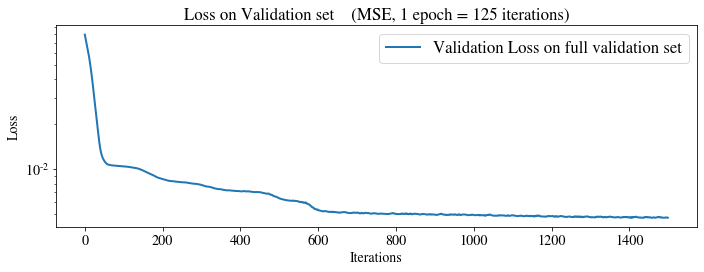

0.004709187553574642
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120829/ 2qubit_FindMinDim 10000.0 100 10 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:25<00:00,  7.10s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08374333 0.08233078 0.08011511 ... 0.00269944 0.00214772 0.00291537]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


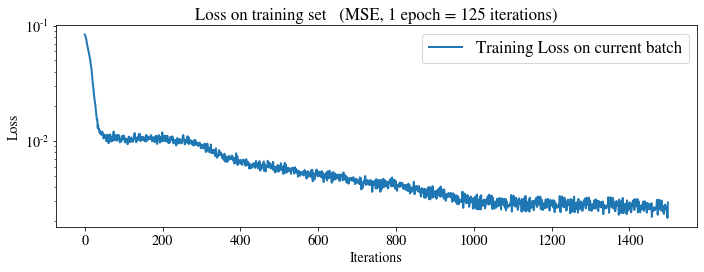

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


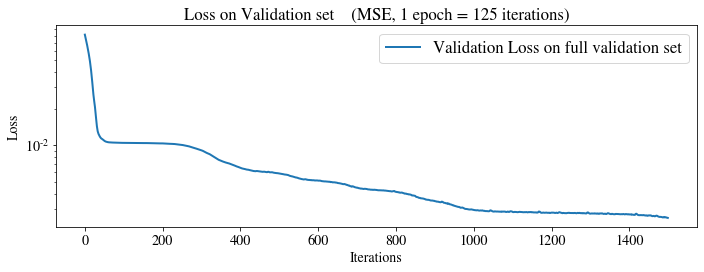

0.002555961006631454
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120829/ 2qubit_FindMinDim 10000.0 100 12 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=12, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=12, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:25<00:00,  7.11s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.07934447 0.07876231 0.07633587 ... 0.00231894 0.0016412  0.00226279]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


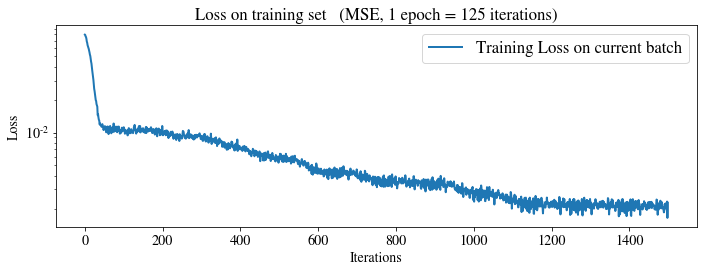

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


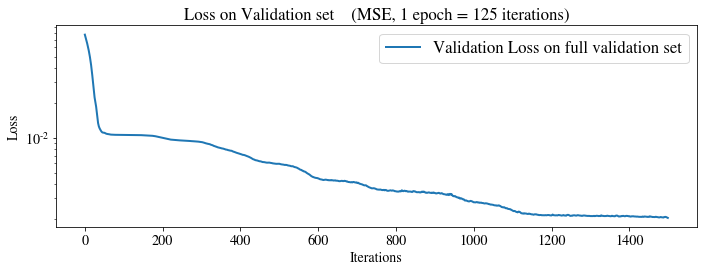

0.002088066275852422
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120829/ 2qubit_FindMinDim 10000.0 100 14 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=14, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=14, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:25<00:00,  7.11s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.07532758 0.07485494 0.07152922 ... 0.00239063 0.00172707 0.00224017]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


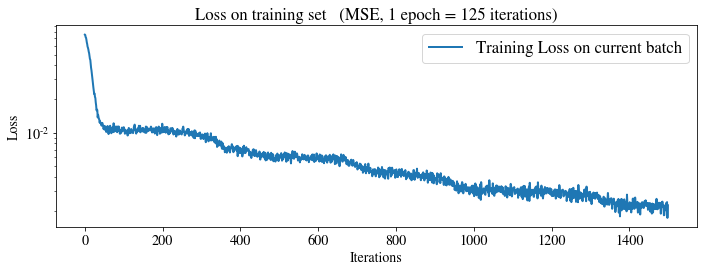

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


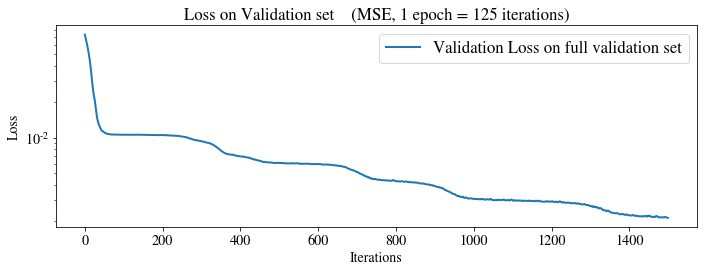

0.00215736615161101
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120829/ 2qubit_FindMinDim 10000.0 100 15 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=15, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=15, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:25<00:00,  7.10s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08159104 0.07952063 0.07745939 ... 0.00156396 0.00115719 0.00168102]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


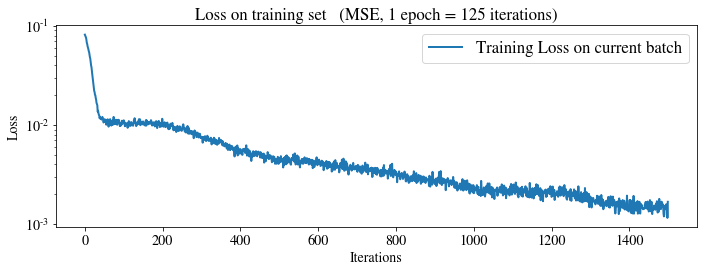

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


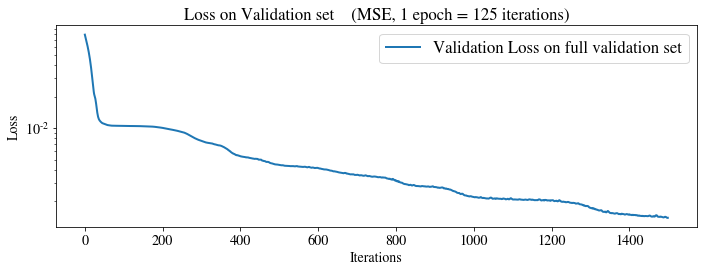

0.0014175268278146782
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120829/ 2qubit_FindMinDim 10000.0 100 16 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:25<00:00,  7.14s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.07490943 0.07395655 0.07228798 ... 0.00236881 0.00187907 0.00228063]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


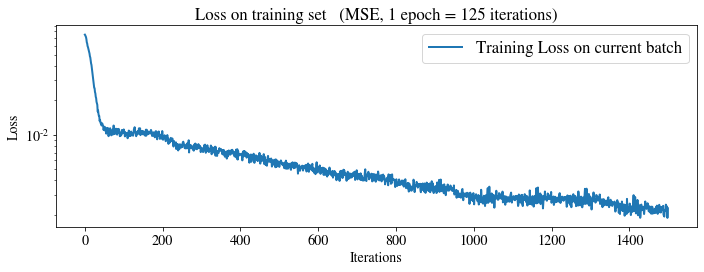

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


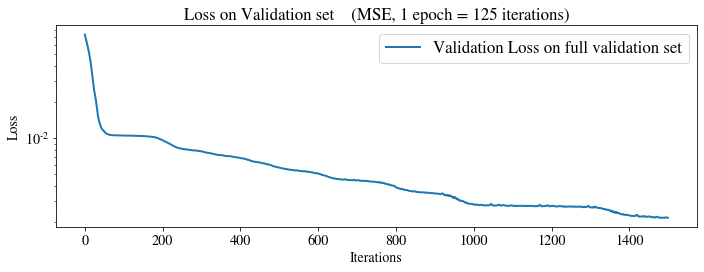

0.0022545730927959083
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120829/ 2qubit_FindMinDim 10000.0 100 18 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=18, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=18, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:25<00:00,  7.15s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.07790341 0.07717523 0.07484629 ... 0.00111812 0.000934   0.00116912]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


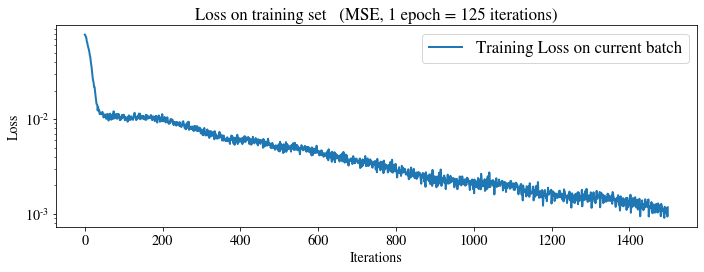

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


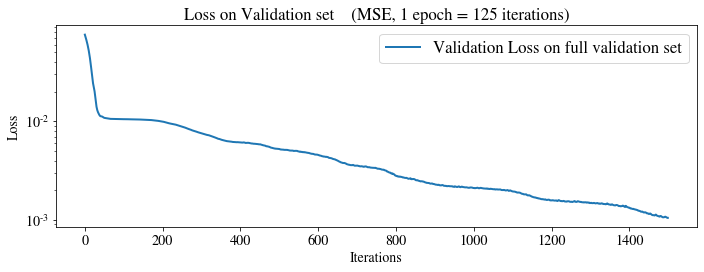

0.001081416899493585
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120829/ 2qubit_FindMinDim 10000.0 100 20 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:25<00:00,  7.09s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08478555 0.08374047 0.08037242 ... 0.00157473 0.00122497 0.00162128]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


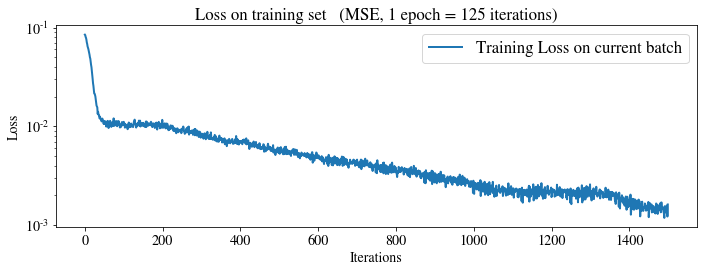

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


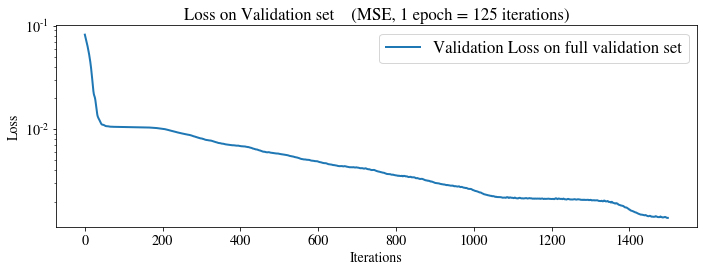

0.001437837389918665
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120829/ 2qubit_FindMinDim 10000.0 100 25 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=25, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=25, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:25<00:00,  7.16s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.07504684 0.0736703  0.07058602 ... 0.00098585 0.00081622 0.00102624]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


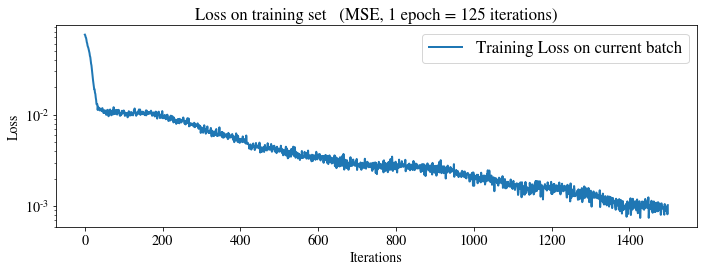

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


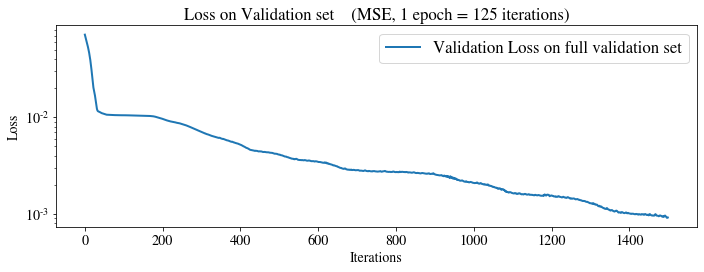

0.0009367601790775856
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120829/ 2qubit_FindMinDim 10000.0 100 30 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=30, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=30, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:25<00:00,  7.12s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.07792571 0.07674041 0.07456584 ... 0.0009442  0.00081272 0.00098765]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


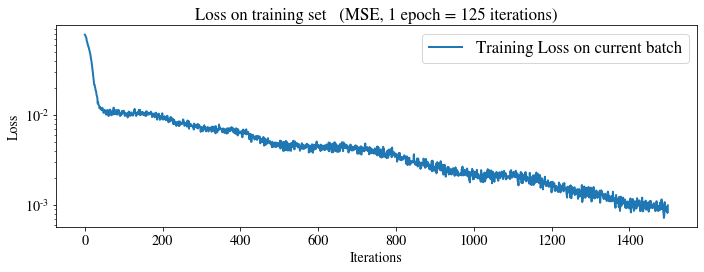

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


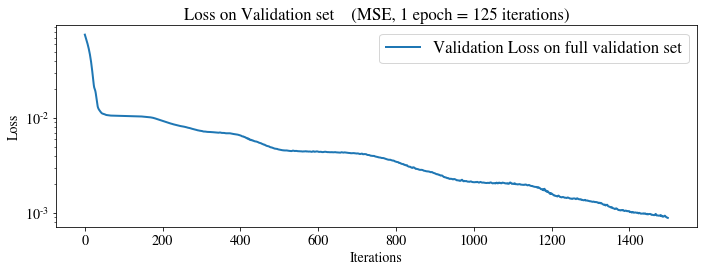

0.0008963345744026203
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120804/ 2qubit_FindMinDim 10000.0 100 1 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:25<00:00,  7.13s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08383621 0.08049802 0.07507399 ... 0.00829173 0.00839251 0.00885111]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


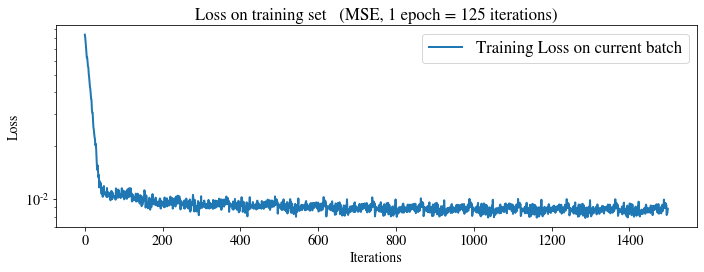

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


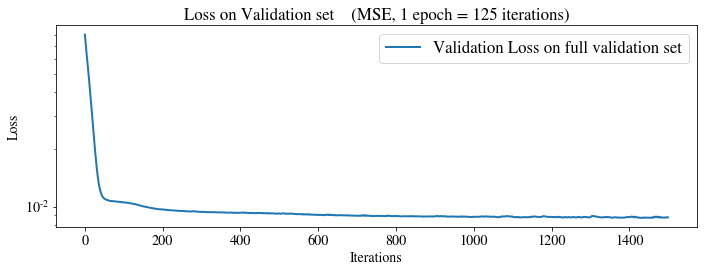

0.00875795657436053
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120804/ 2qubit_FindMinDim 10000.0 100 5 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=5, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=5, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:25<00:00,  7.12s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.07622308 0.07544265 0.07125144 ... 0.00430575 0.0049514  0.00502423]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


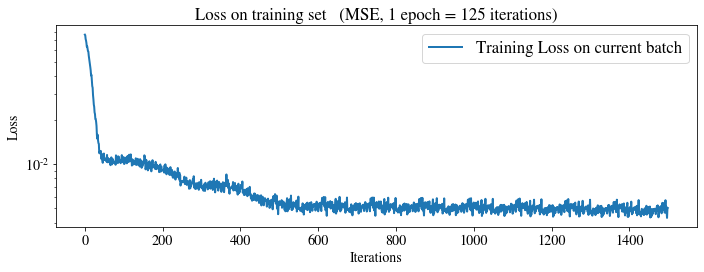

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


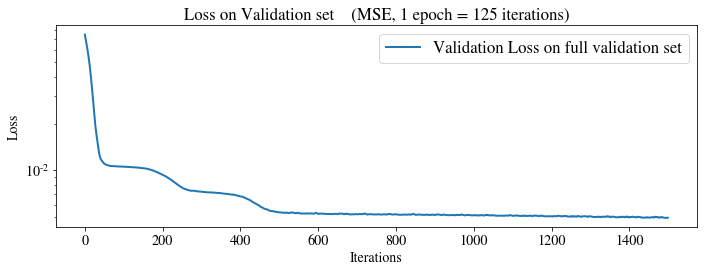

0.004951336917777856
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120804/ 2qubit_FindMinDim 10000.0 100 10 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:26<00:00,  7.21s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.07859566 0.07753596 0.0732986  ... 0.00229583 0.00227418 0.00260195]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


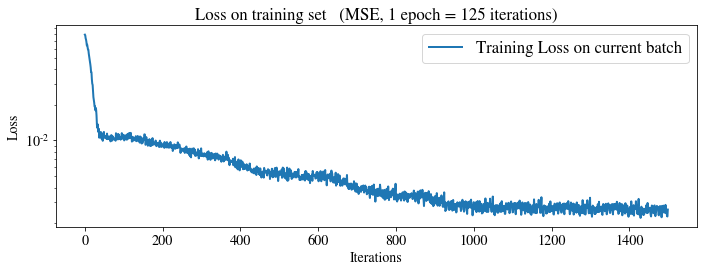

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


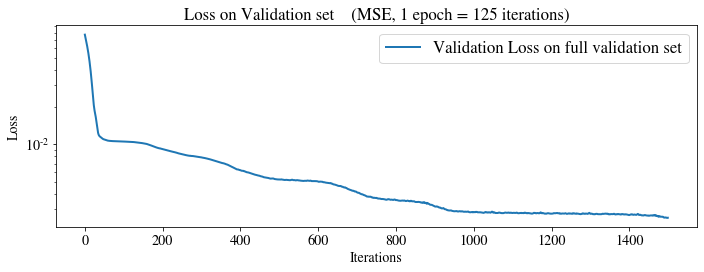

0.002475162222981453
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120804/ 2qubit_FindMinDim 10000.0 100 12 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=12, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=12, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:25<00:00,  7.13s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.0841407  0.08346152 0.07934913 ... 0.00266349 0.00245891 0.00277081]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


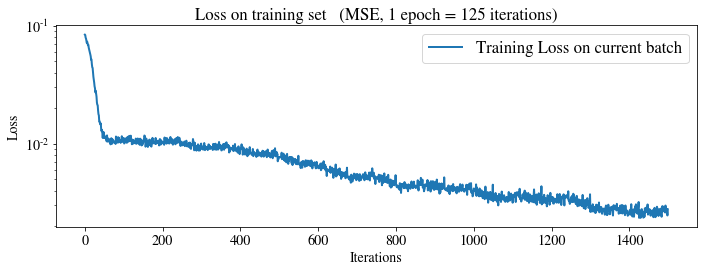

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


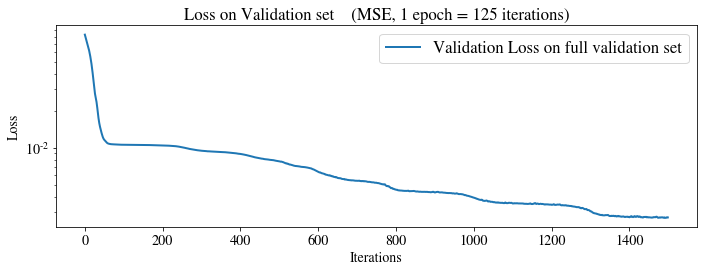

0.0026280214233944813
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120804/ 2qubit_FindMinDim 10000.0 100 14 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=14, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=14, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:25<00:00,  7.16s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08097314 0.07881173 0.07405964 ... 0.00128872 0.0014033  0.00162717]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


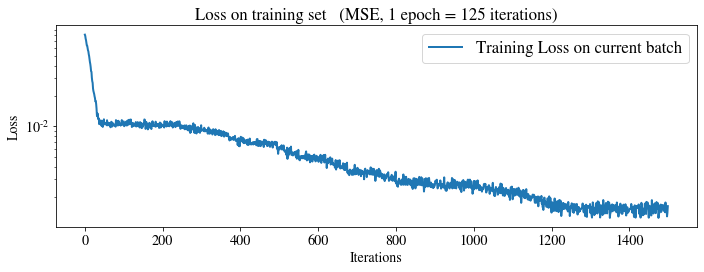

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


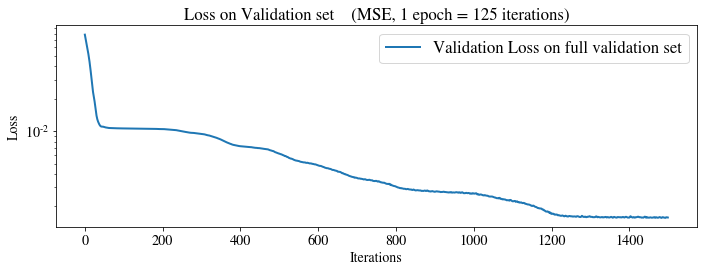

0.0015324389018739264
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120804/ 2qubit_FindMinDim 10000.0 100 15 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=15, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=15, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:28<00:00,  7.36s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08189297 0.08089106 0.07634813 ... 0.00197678 0.00197018 0.00224024]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


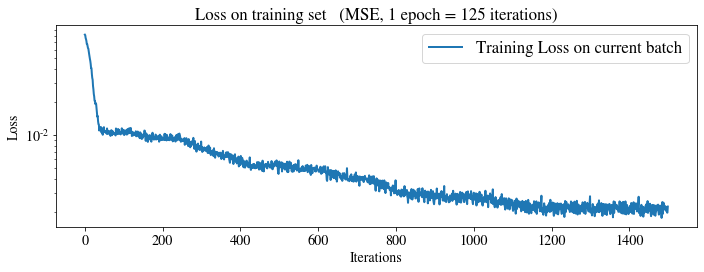

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


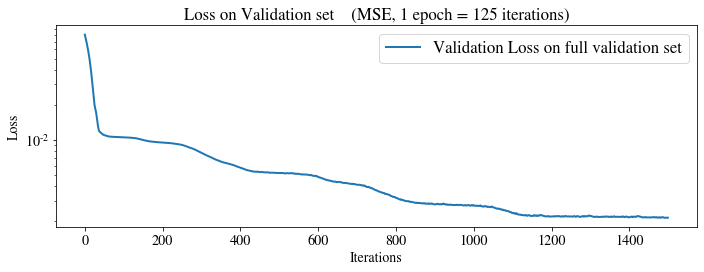

0.0021465923171490433
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120804/ 2qubit_FindMinDim 10000.0 100 16 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:26<00:00,  7.19s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.07881342 0.07749142 0.07364828 ... 0.00179254 0.00181518 0.00218648]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


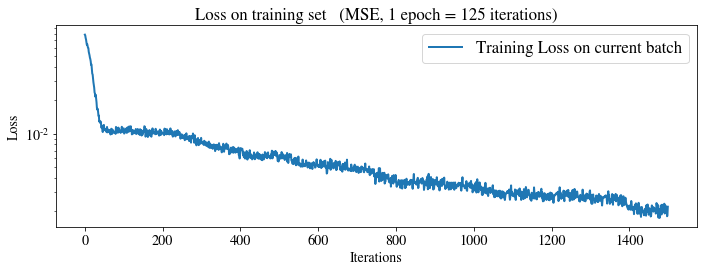

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


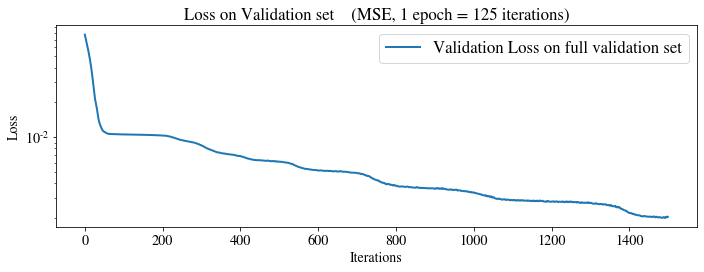

0.0020140589292471606
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120804/ 2qubit_FindMinDim 10000.0 100 18 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=18, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=18, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:25<00:00,  7.16s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.07541286 0.07455807 0.07067452 ... 0.0013445  0.00136595 0.00157352]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


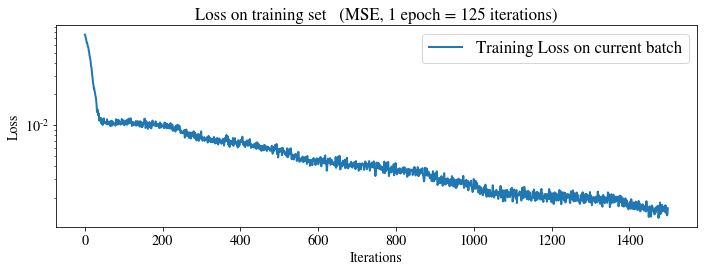

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


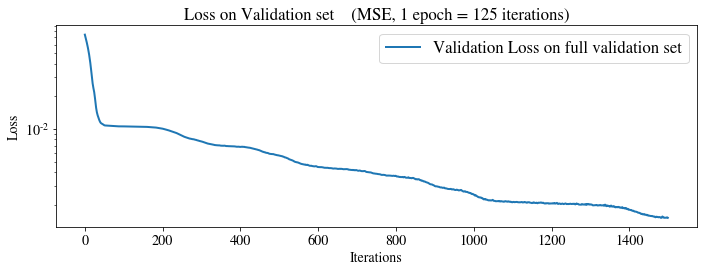

0.0014499002446730933
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120804/ 2qubit_FindMinDim 10000.0 100 20 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:25<00:00,  7.13s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.0867423  0.08565487 0.08062921 ... 0.00124105 0.00140561 0.00162057]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


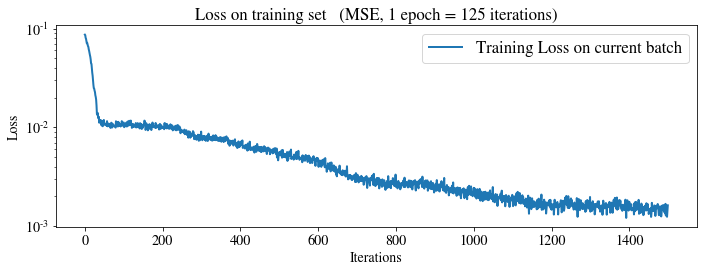

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


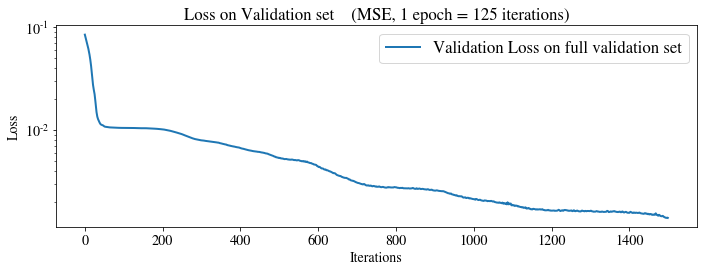

0.001344920632739862
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120804/ 2qubit_FindMinDim 10000.0 100 25 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=25, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=25, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:26<00:00,  7.17s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.07870421 0.0779799  0.07380955 ... 0.00089598 0.00103945 0.00111148]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


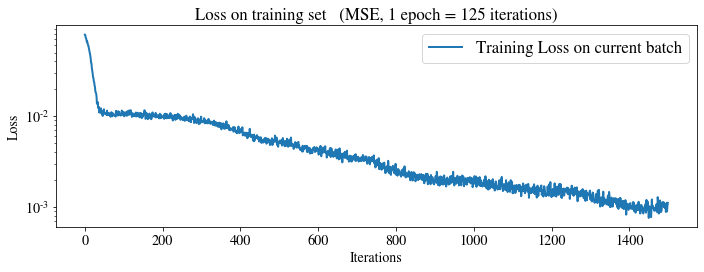

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


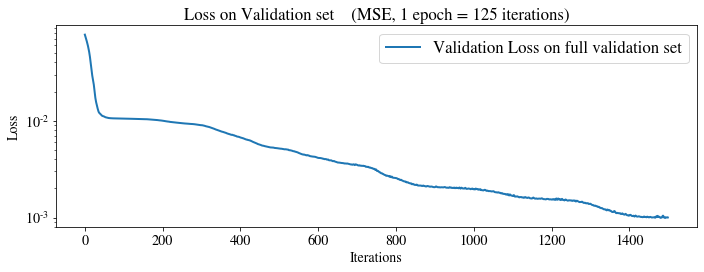

0.0009709211027560135
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120804/ 2qubit_FindMinDim 10000.0 100 30 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=30, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=30, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:25<00:00,  7.14s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08020913 0.07853678 0.07462893 ... 0.00055933 0.00067378 0.00065493]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


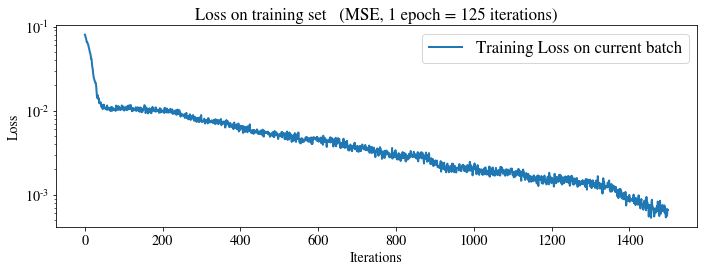

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


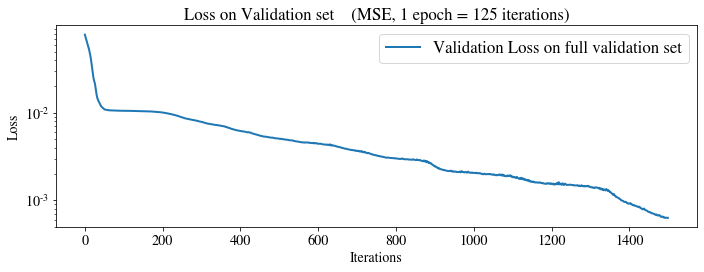

0.0006234881506922345
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120749/ 2qubit_FindMinDim 10000.0 100 1 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:25<00:00,  7.12s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.09295797 0.08893802 0.08191293 ... 0.00854687 0.00845722 0.00861099]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


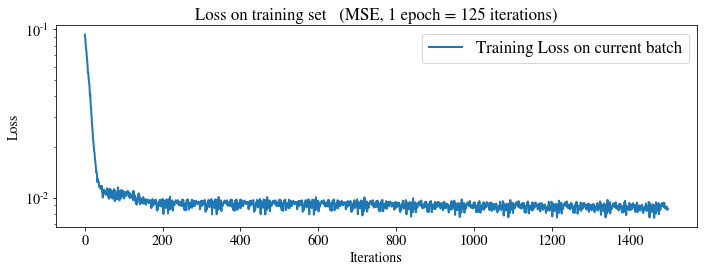

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


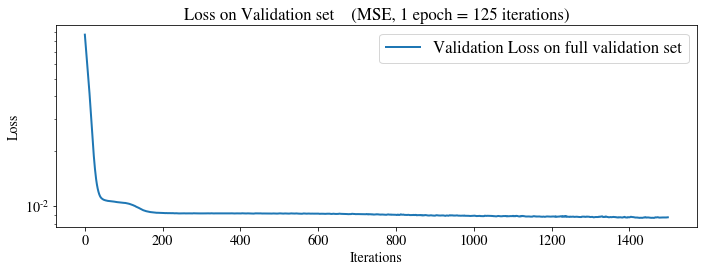

0.008863173052668571
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120749/ 2qubit_FindMinDim 10000.0 100 5 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=5, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=5, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:25<00:00,  7.13s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.07970425 0.0774455  0.07390649 ... 0.00538392 0.00484324 0.00478337]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


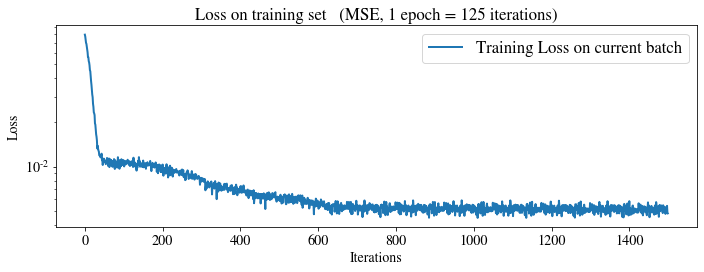

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


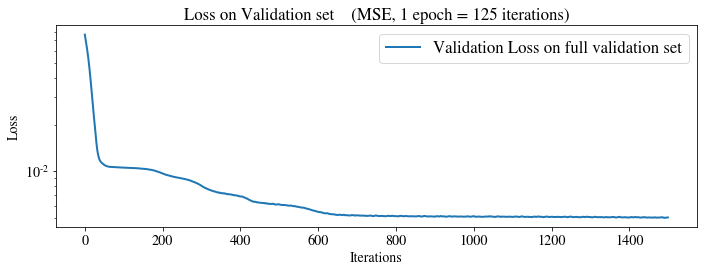

0.005136617179960013
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120749/ 2qubit_FindMinDim 10000.0 100 10 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:25<00:00,  7.12s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08298279 0.08250359 0.07852191 ... 0.00268835 0.00240323 0.00257923]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


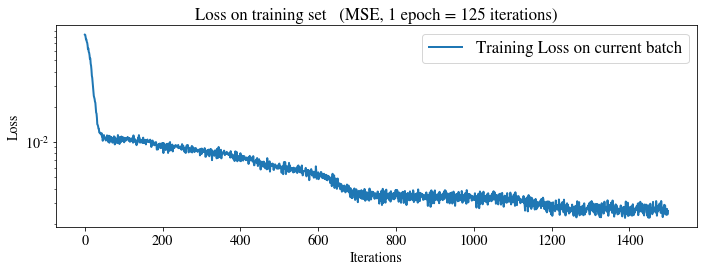

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


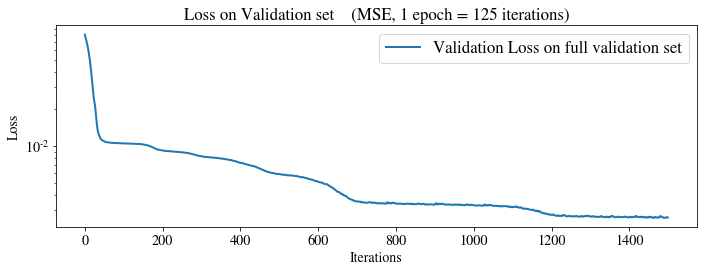

0.002695331551755468
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120749/ 2qubit_FindMinDim 10000.0 100 12 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=12, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=12, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:25<00:00,  7.11s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08172986 0.08011131 0.07636038 ... 0.00265321 0.00235126 0.00247499]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


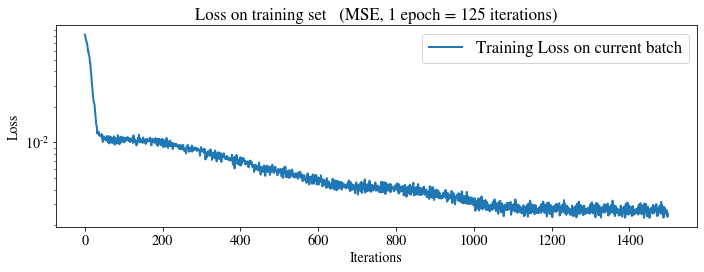

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


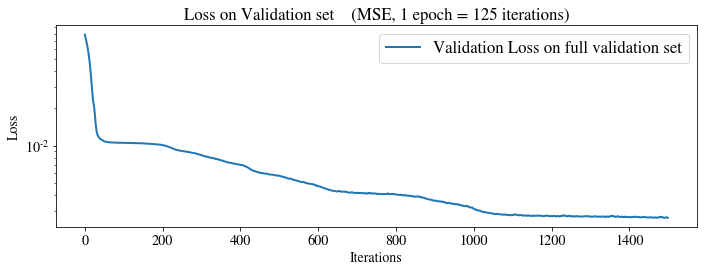

0.0026745783630758523
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120749/ 2qubit_FindMinDim 10000.0 100 14 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=14, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=14, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:27<00:00,  7.27s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.07484829 0.07380716 0.07010102 ... 0.00209094 0.00186948 0.00201736]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


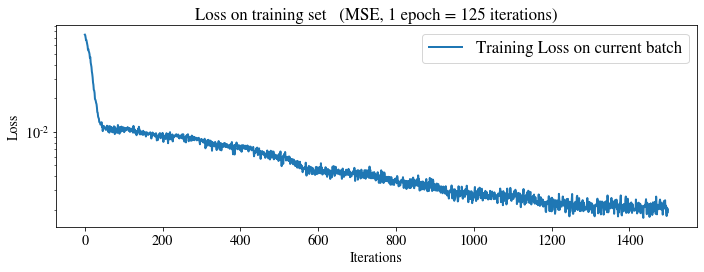

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


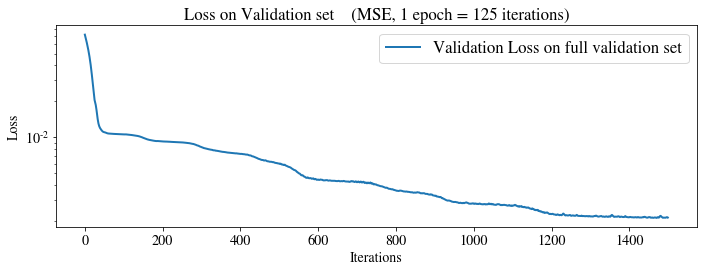

0.0021804747482140857
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120749/ 2qubit_FindMinDim 10000.0 100 15 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=15, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=15, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:28<00:00,  7.36s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.0881313  0.08623624 0.08260566 ... 0.00259014 0.00220815 0.00237745]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


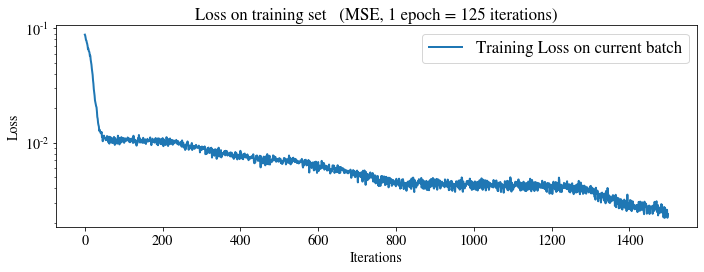

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


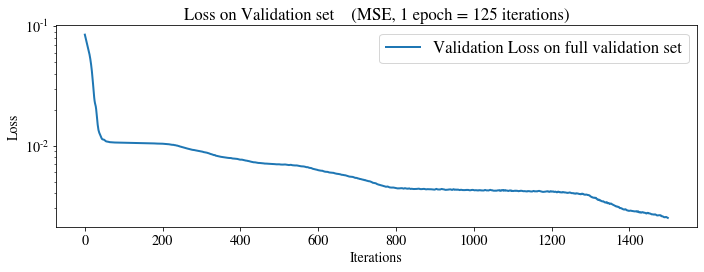

0.002508053199077646
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120749/ 2qubit_FindMinDim 10000.0 100 16 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:26<00:00,  7.23s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08537014 0.08302398 0.07857911 ... 0.00135496 0.00128676 0.00144609]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


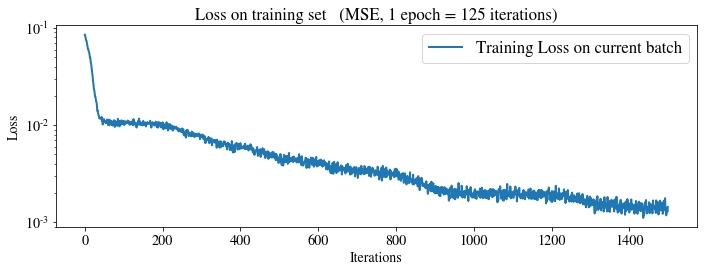

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


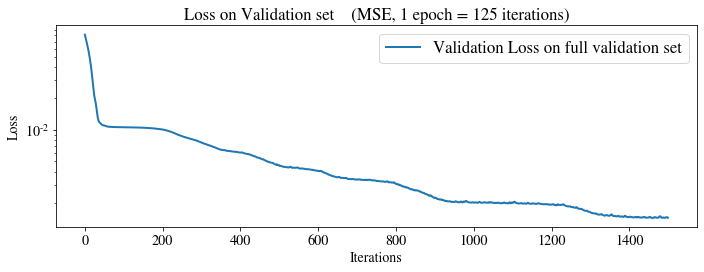

0.0014911538998906811
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120749/ 2qubit_FindMinDim 10000.0 100 18 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=18, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=18, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:25<00:00,  7.12s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.07844494 0.07678833 0.07269525 ... 0.00136228 0.00128687 0.0014206 ]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


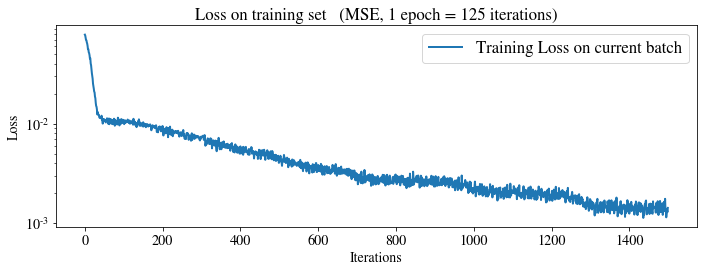

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


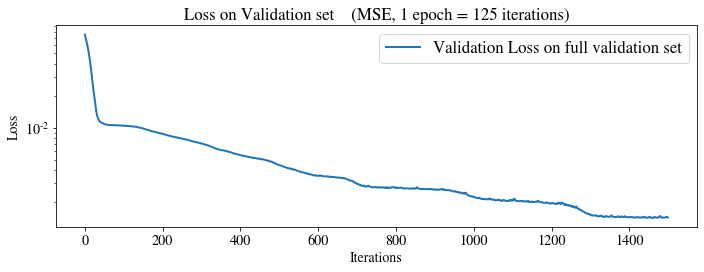

0.0014855999499559403
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120749/ 2qubit_FindMinDim 10000.0 100 20 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:25<00:00,  7.16s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.07894452 0.07718262 0.07352767 ... 0.00145845 0.00132781 0.00148768]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


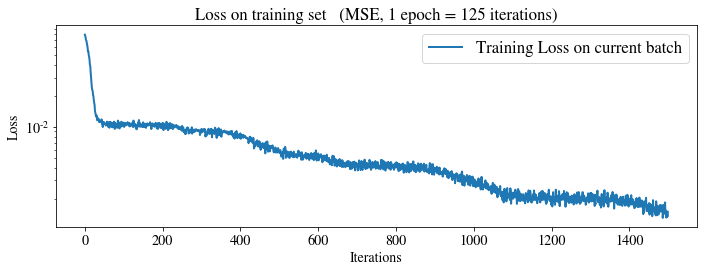

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


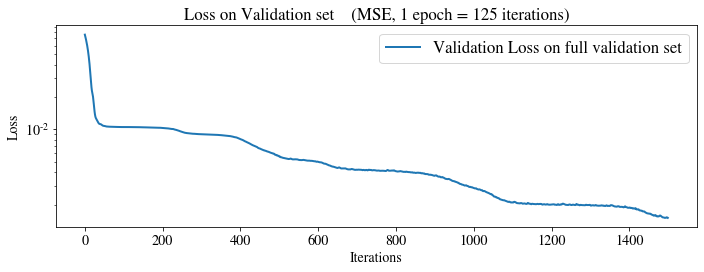

0.0015673666028305888
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120749/ 2qubit_FindMinDim 10000.0 100 25 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=25, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=25, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:25<00:00,  7.16s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08358438 0.0825489  0.07830834 ... 0.00106199 0.00091584 0.00098405]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


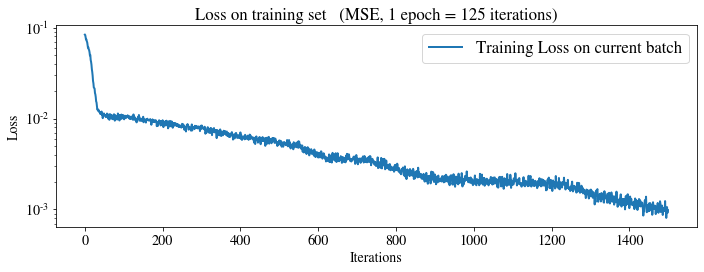

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


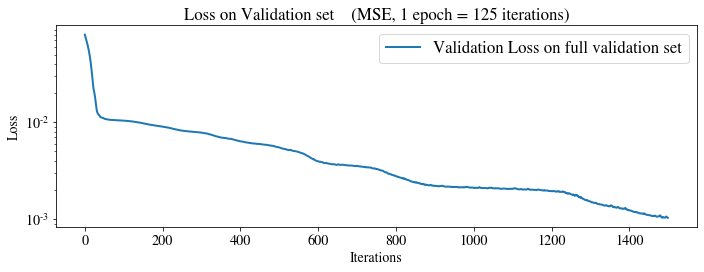

0.0010770379565656185
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120749/ 2qubit_FindMinDim 10000.0 100 30 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=30, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=30, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:25<00:00,  7.12s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08035226 0.07873865 0.07443455 ... 0.00150462 0.00126184 0.00134421]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


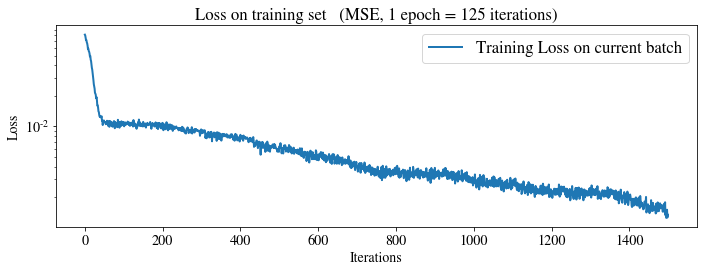

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


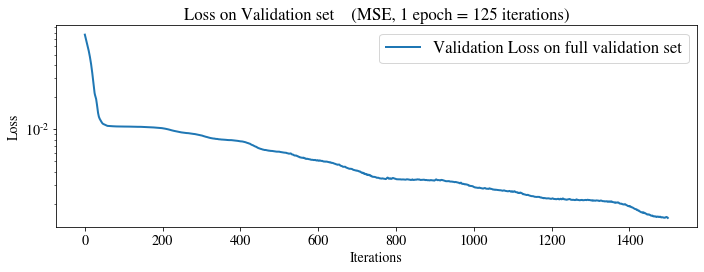

0.0015638964250683784
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120759/ 2qubit_FindMinDim 10000.0 100 1 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:25<00:00,  7.13s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.07750421 0.07495762 0.07025452 ... 0.00860015 0.00852023 0.00900509]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


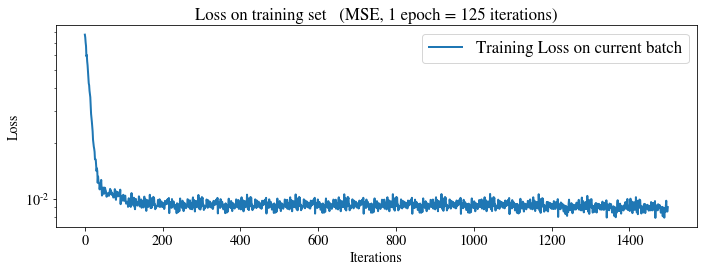

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


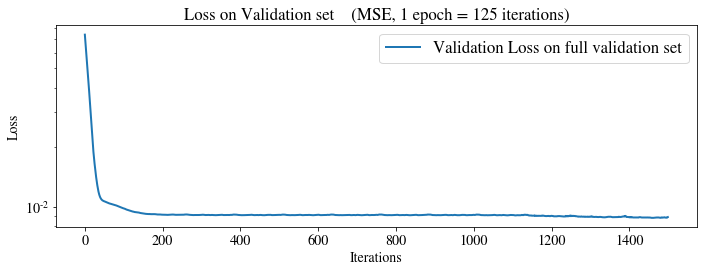

0.008862213790416717
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120759/ 2qubit_FindMinDim 10000.0 100 5 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=5, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=5, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:26<00:00,  7.24s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08703127 0.08495076 0.08074903 ... 0.00444901 0.00432328 0.00464993]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


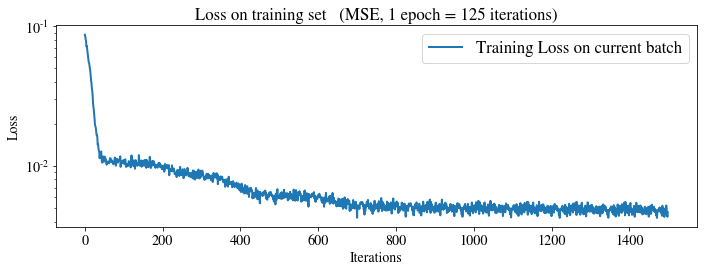

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


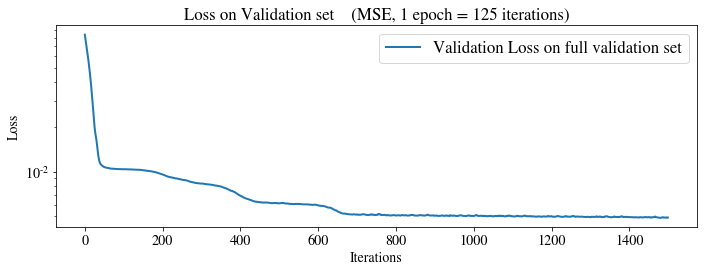

0.004809967552622159
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120759/ 2qubit_FindMinDim 10000.0 100 10 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:25<00:00,  7.14s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08815853 0.08708645 0.08289379 ... 0.00257293 0.00251388 0.00258902]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


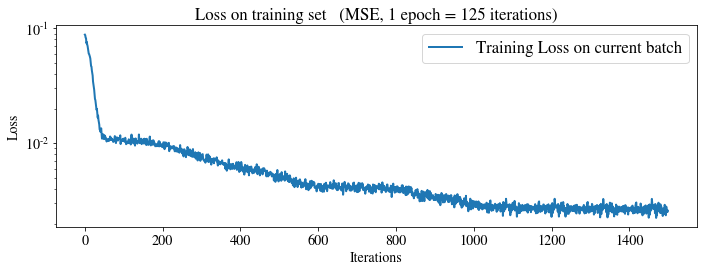

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


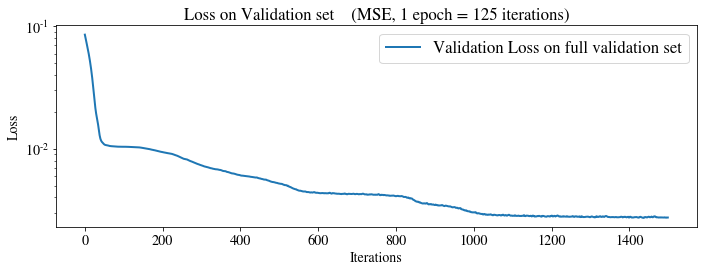

0.0026842704974114895
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120759/ 2qubit_FindMinDim 10000.0 100 12 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=12, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=12, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:26<00:00,  7.22s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.07943544 0.07844643 0.07507789 ... 0.00197629 0.00187948 0.0020807 ]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


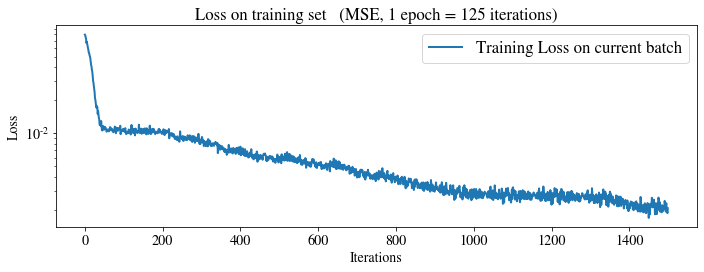

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


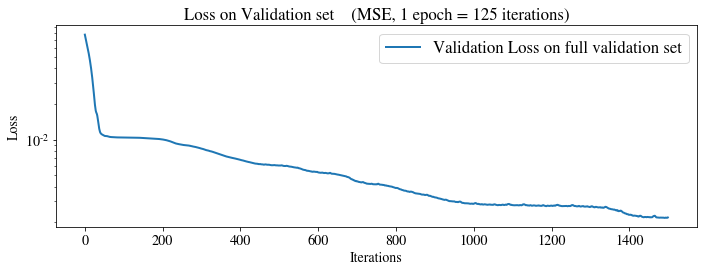

0.0021671975807597238
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120759/ 2qubit_FindMinDim 10000.0 100 14 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=14, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=14, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:26<00:00,  7.20s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08118629 0.08032774 0.07741564 ... 0.00151922 0.00152583 0.0015596 ]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


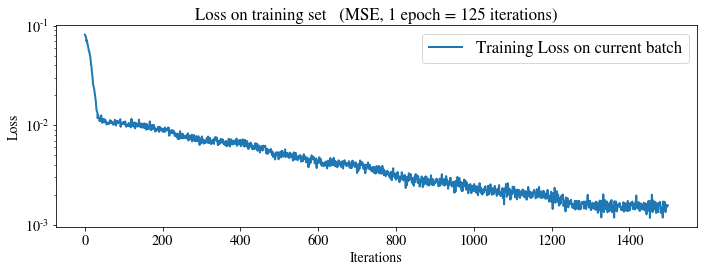

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


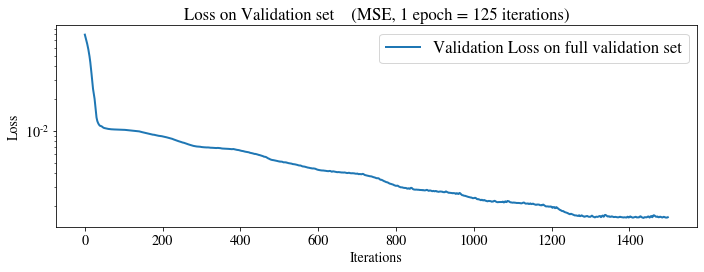

0.0014978169774015745
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120759/ 2qubit_FindMinDim 10000.0 100 15 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=15, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=15, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:26<00:00,  7.17s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08729836 0.08624724 0.08205339 ... 0.00253029 0.00241457 0.00259381]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


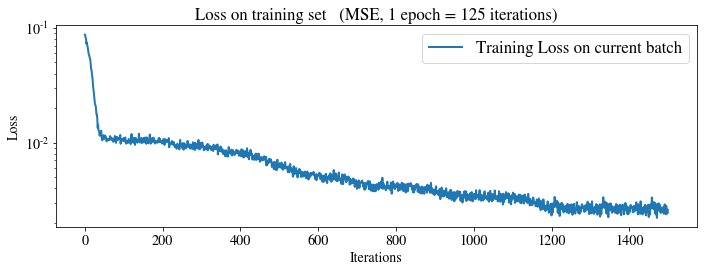

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


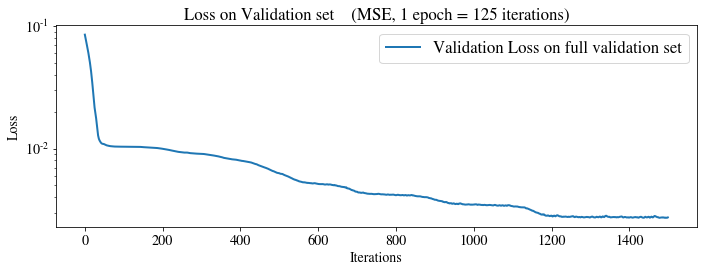

0.00270438267228504
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120759/ 2qubit_FindMinDim 10000.0 100 16 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:26<00:00,  7.17s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08205651 0.08214307 0.07954539 ... 0.00197469 0.00188847 0.0020511 ]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


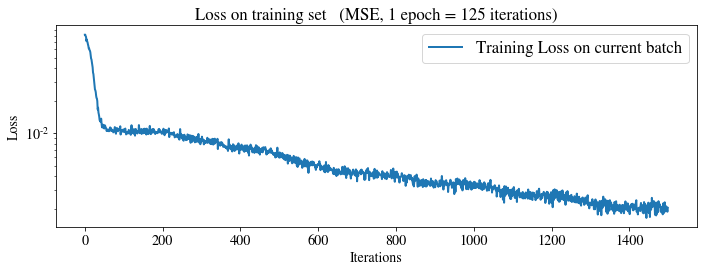

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


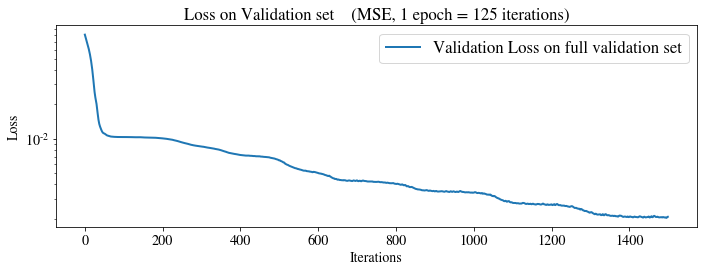

0.0020824090112000703
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120759/ 2qubit_FindMinDim 10000.0 100 18 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=18, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=18, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:25<00:00,  7.16s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08105085 0.07985936 0.07673249 ... 0.00185652 0.00183071 0.00199601]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


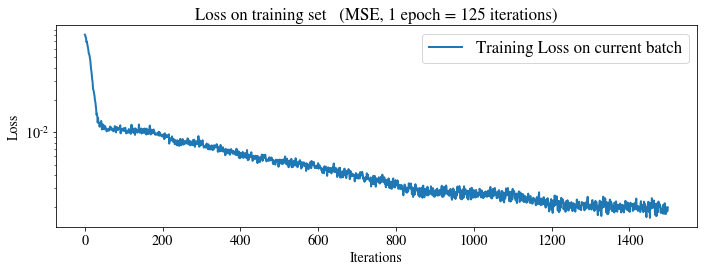

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


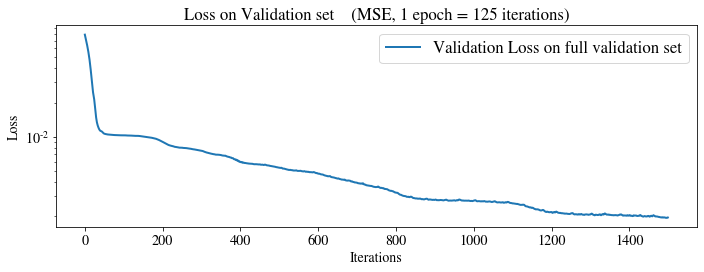

0.0019633512555932006
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120759/ 2qubit_FindMinDim 10000.0 100 20 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:25<00:00,  7.10s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.07213493 0.07148244 0.06830811 ... 0.00153072 0.0015739  0.00171022]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


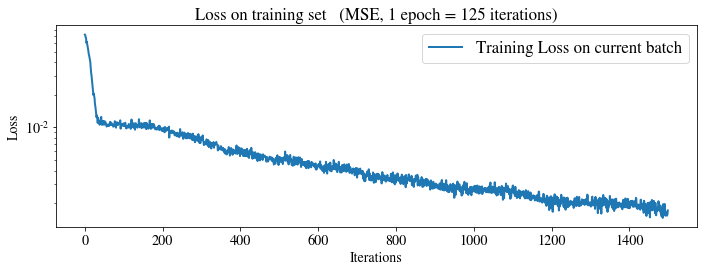

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


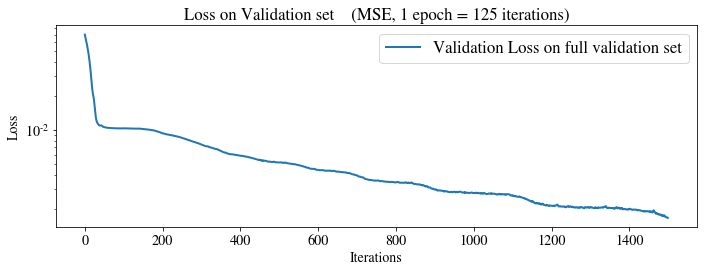

0.001649279915727675
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120759/ 2qubit_FindMinDim 10000.0 100 25 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=25, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=25, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:25<00:00,  7.15s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08214714 0.08106983 0.07751803 ... 0.00050762 0.00062172 0.00059323]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


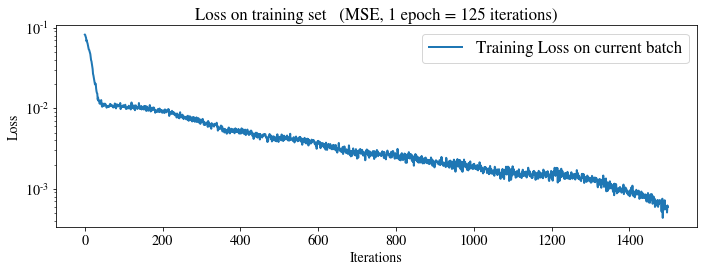

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


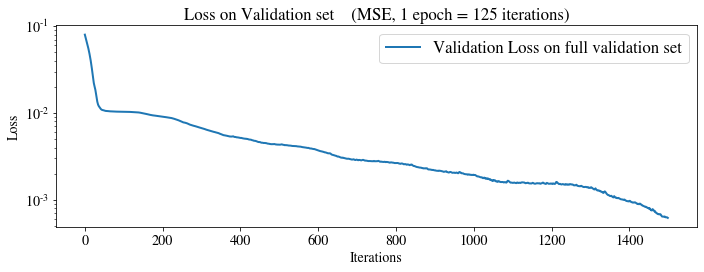

0.0005929903922757755
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120759/ 2qubit_FindMinDim 10000.0 100 30 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=30, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=30, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:25<00:00,  7.13s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.0824956  0.08159829 0.07817373 ... 0.00121677 0.00129139 0.00138425]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


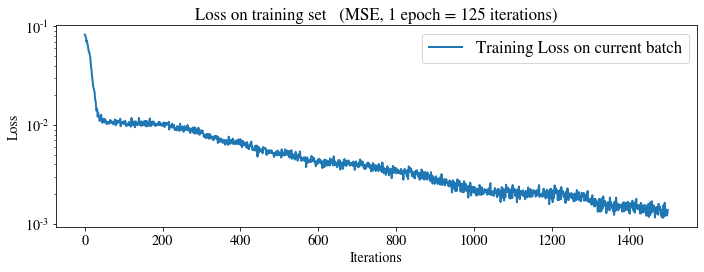

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


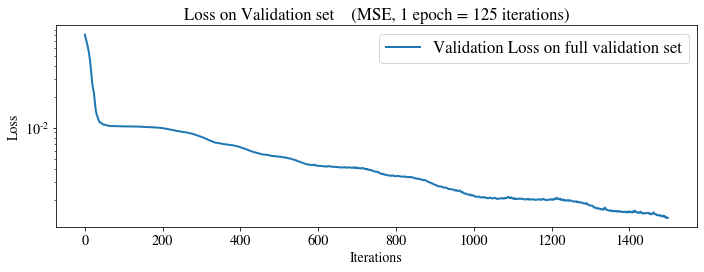

0.0012941442197188734
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120814/ 2qubit_FindMinDim 10000.0 100 1 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:25<00:00,  7.14s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.09464753 0.08760885 0.08066466 ... 0.00973612 0.00845928 0.00887066]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


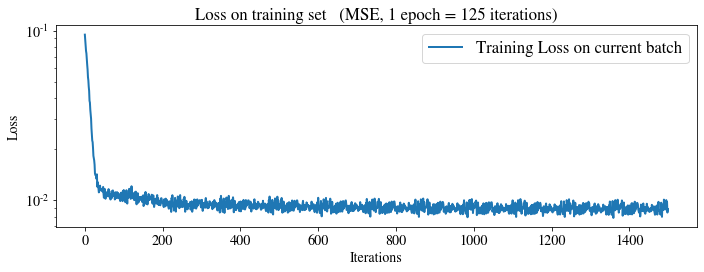

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


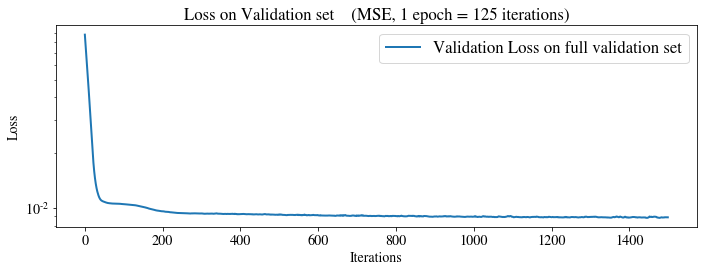

0.009072969170908133
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120814/ 2qubit_FindMinDim 10000.0 100 5 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=5, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=5, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:25<00:00,  7.16s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08443046 0.08188245 0.07815304 ... 0.00482389 0.00507433 0.00498978]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


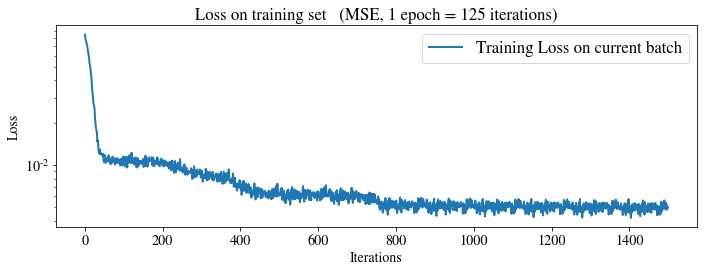

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


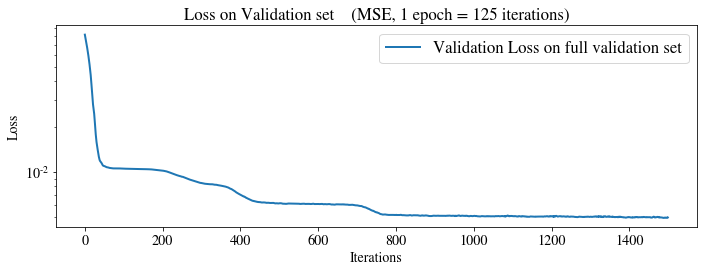

0.004987063134709994
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120814/ 2qubit_FindMinDim 10000.0 100 10 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:25<00:00,  7.12s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08089115 0.07794241 0.07442065 ... 0.00343549 0.00343822 0.0034451 ]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


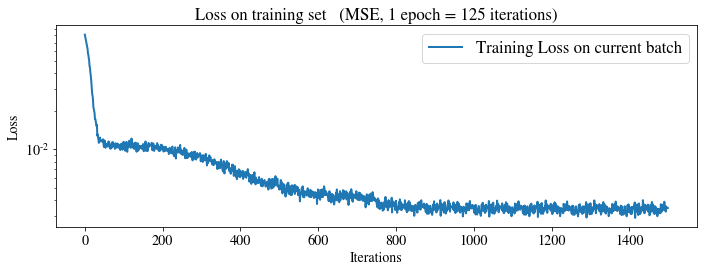

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


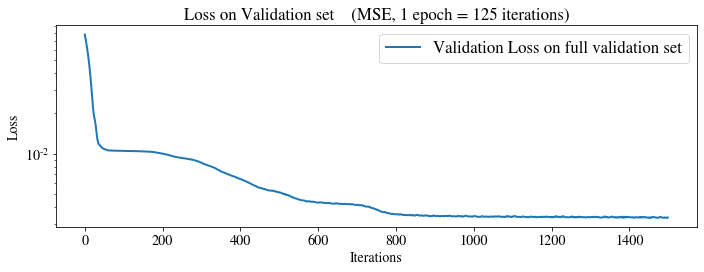

0.003391798570131262
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120814/ 2qubit_FindMinDim 10000.0 100 12 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=12, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=12, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:26<00:00,  7.19s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08103037 0.07862271 0.07476624 ... 0.00152384 0.00167046 0.00149848]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


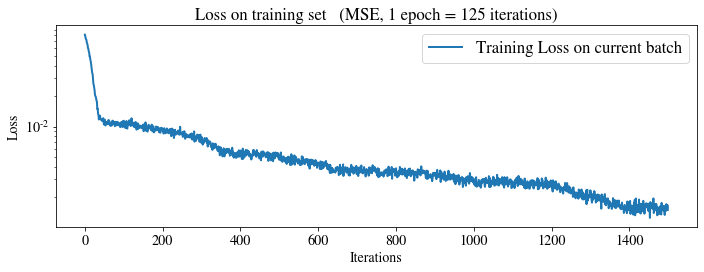

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


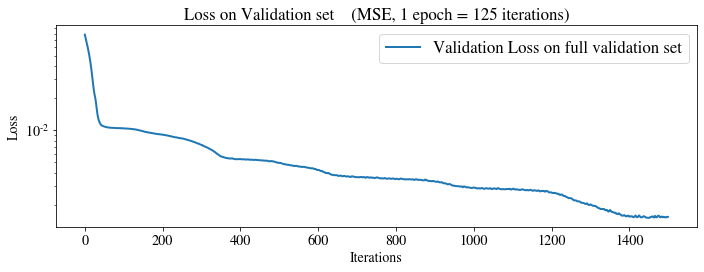

0.0015435106664275129
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120814/ 2qubit_FindMinDim 10000.0 100 14 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=14, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=14, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:26<00:00,  7.17s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.0840871  0.08239578 0.0788164  ... 0.00192118 0.00167647 0.00186874]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


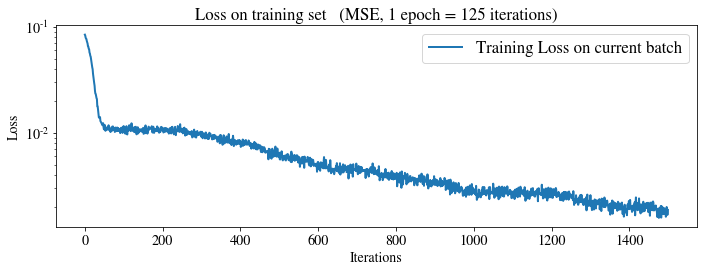

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


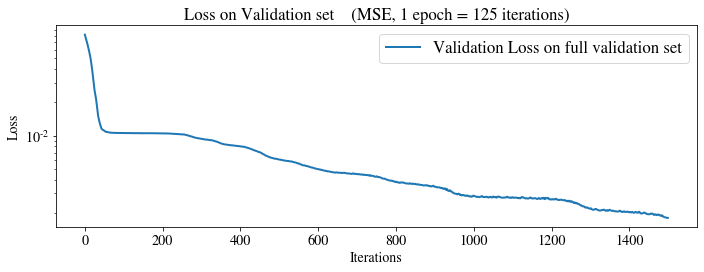

0.001758939951347808
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120814/ 2qubit_FindMinDim 10000.0 100 15 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=15, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=15, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:25<00:00,  7.15s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08639676 0.08387091 0.07987768 ... 0.00185791 0.00141256 0.00170676]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


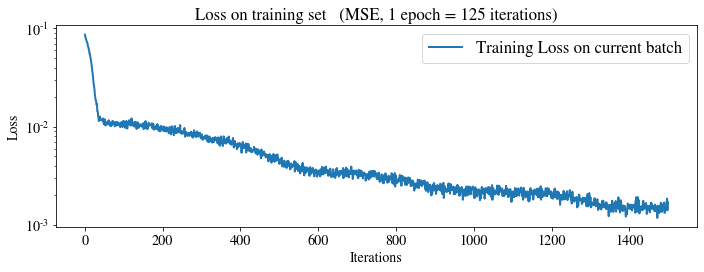

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


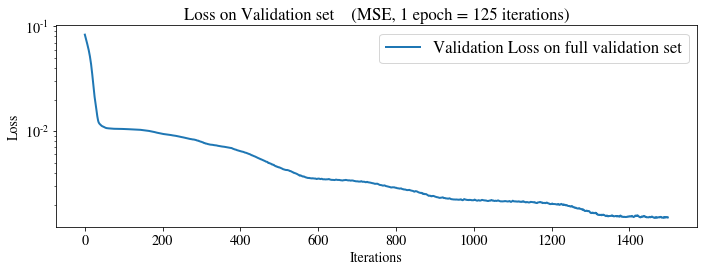

0.001498812638844053
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120814/ 2qubit_FindMinDim 10000.0 100 16 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:26<00:00,  7.19s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.09073925 0.08880153 0.0850487  ... 0.00218668 0.00196893 0.00216811]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


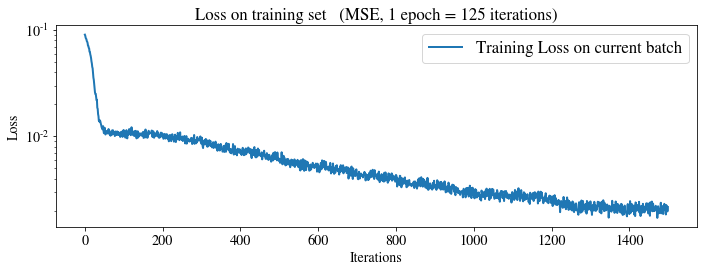

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


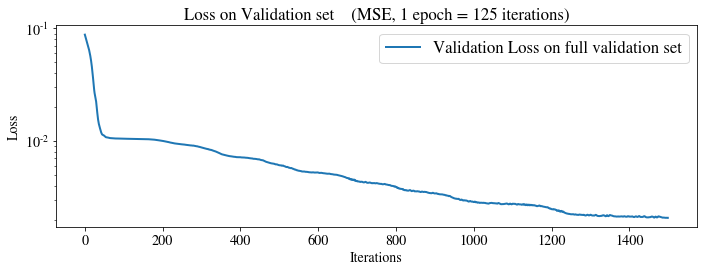

0.002055981072286765
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120814/ 2qubit_FindMinDim 10000.0 100 18 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=18, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=18, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:25<00:00,  7.15s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08671159 0.08423106 0.08072185 ... 0.00214572 0.00228122 0.00205191]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


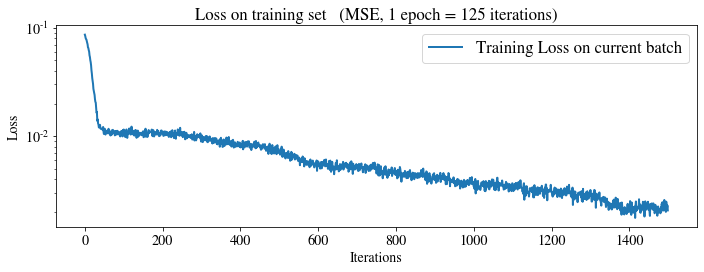

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


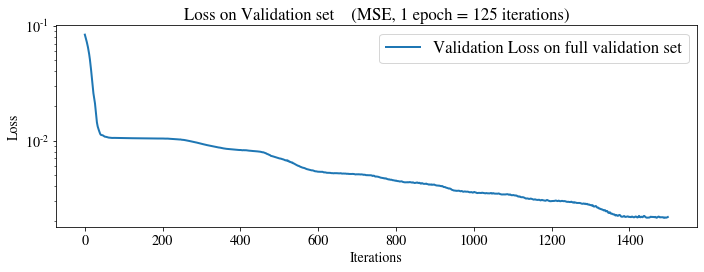

0.0021168051986023783
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120814/ 2qubit_FindMinDim 10000.0 100 20 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:36<00:00,  8.07s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08224289 0.08034804 0.07683057 ... 0.00203661 0.00191127 0.00188523]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


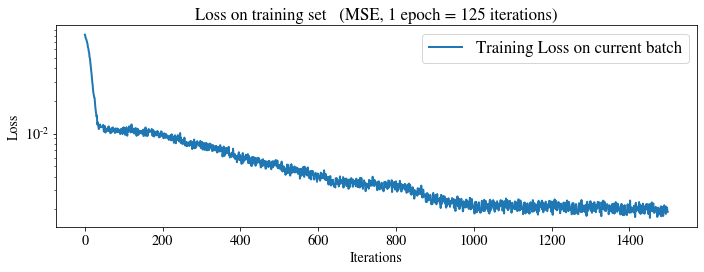

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


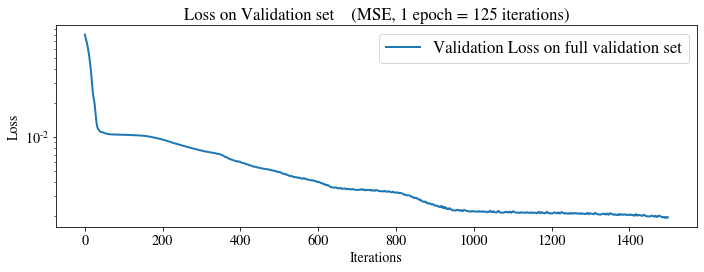

0.0019451796387632688
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120814/ 2qubit_FindMinDim 10000.0 100 25 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=25, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=25, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:26<00:00,  7.21s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08099322 0.07939924 0.07599555 ... 0.00172866 0.00130664 0.00159269]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


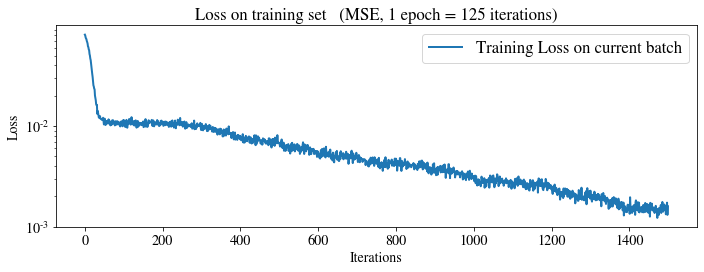

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


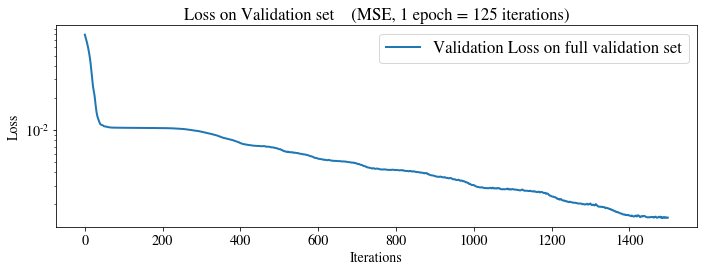

0.001475019535670678
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120814/ 2qubit_FindMinDim 10000.0 100 30 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=30, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=30, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:25<00:00,  7.11s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.07453938 0.07257645 0.06908178 ... 0.00166167 0.00164027 0.00150728]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


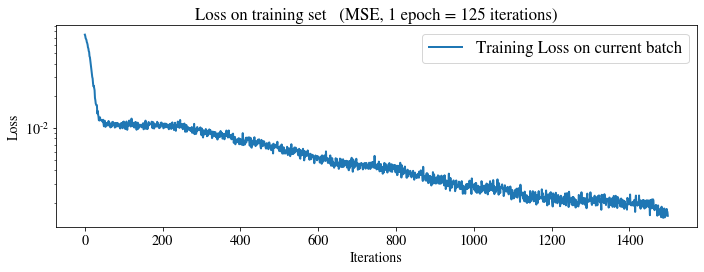

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


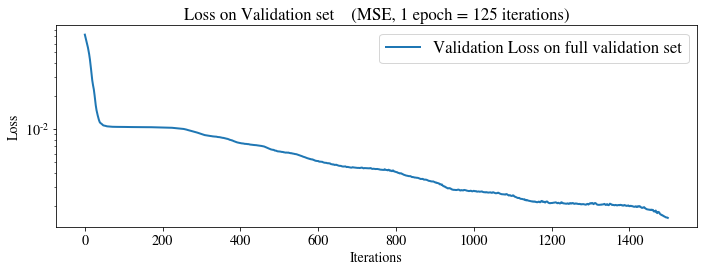

0.001550803224866589
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120824/ 2qubit_FindMinDim 10000.0 100 1 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:25<00:00,  7.14s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.10497258 0.09776078 0.09319746 ... 0.00868719 0.00894964 0.00938789]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


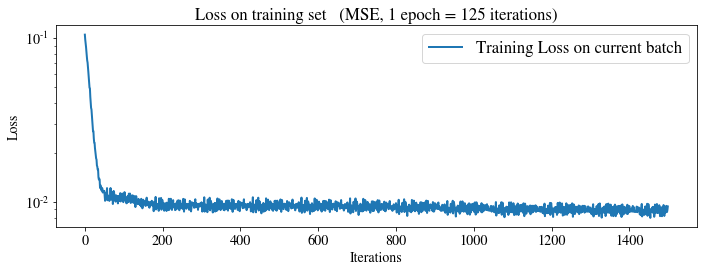

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


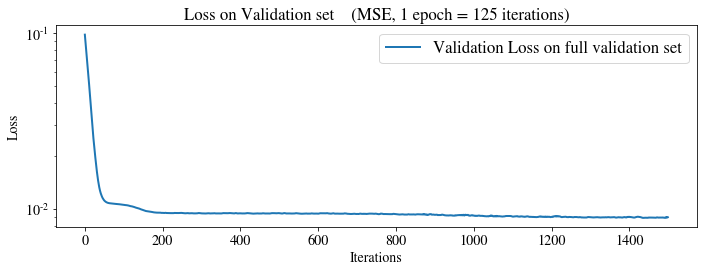

0.009155542962253094
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120824/ 2qubit_FindMinDim 10000.0 100 5 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=5, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=5, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:26<00:00,  7.18s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08352949 0.08113527 0.07941615 ... 0.00498634 0.00476098 0.00484201]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


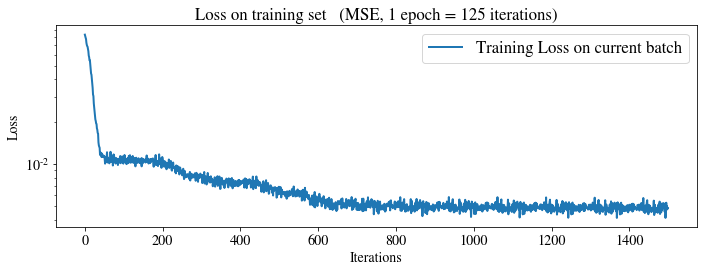

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


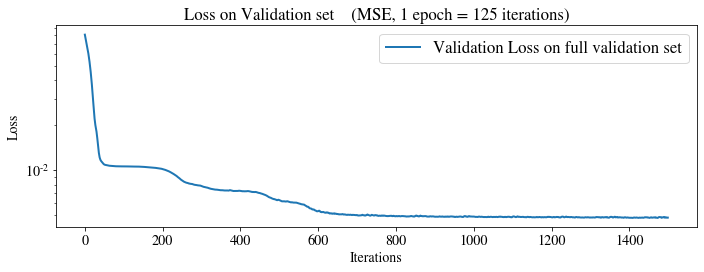

0.004934926424175501
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120824/ 2qubit_FindMinDim 10000.0 100 10 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:25<00:00,  7.16s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.0879755  0.08531392 0.08360258 ... 0.00318788 0.00307231 0.00315446]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


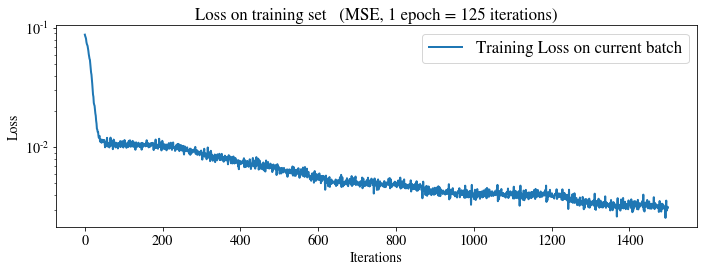

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


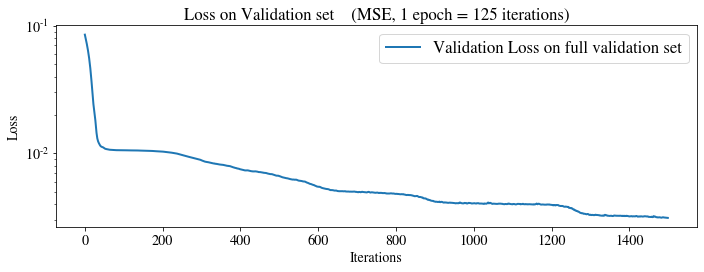

0.0032272746941695613
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120824/ 2qubit_FindMinDim 10000.0 100 12 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=12, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=12, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:25<00:00,  7.15s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.07307784 0.07051376 0.06911883 ... 0.00147164 0.00135268 0.00132112]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


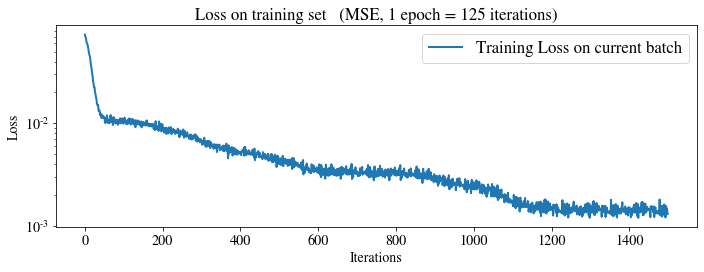

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


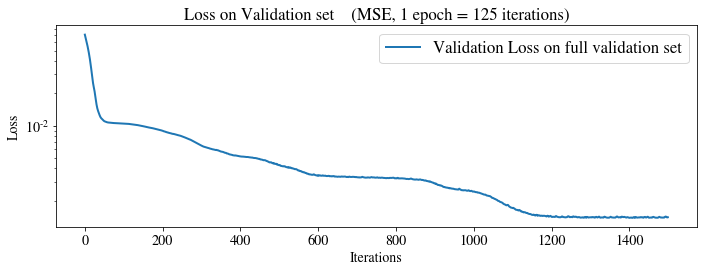

0.001477434579282999
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120824/ 2qubit_FindMinDim 10000.0 100 14 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=14, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=14, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:26<00:00,  7.19s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08190846 0.08004995 0.07825062 ... 0.00159084 0.00141663 0.00133084]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


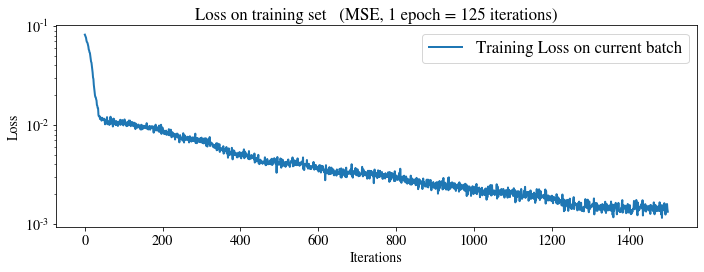

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


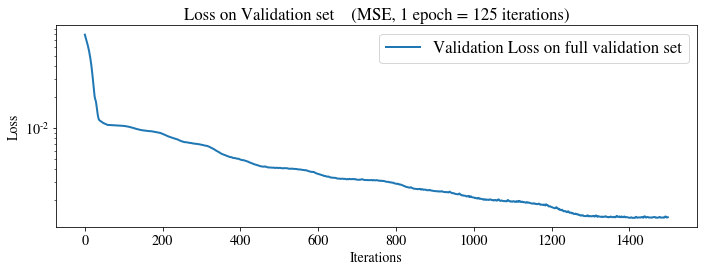

0.0015091794387747843
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120824/ 2qubit_FindMinDim 10000.0 100 15 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=15, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=15, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:25<00:00,  7.15s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08572203 0.08250367 0.08007959 ... 0.00139883 0.00127277 0.00133601]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


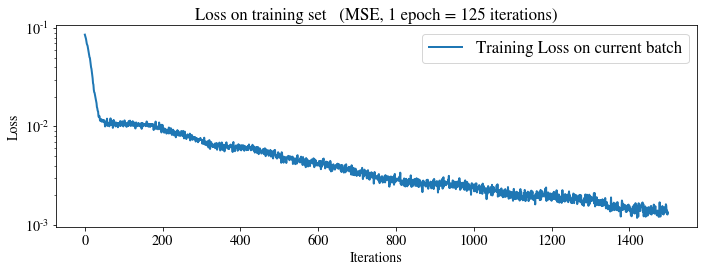

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


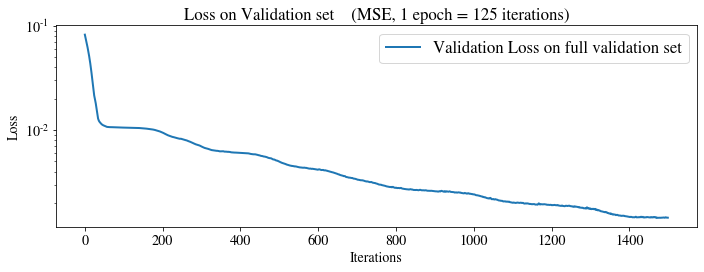

0.0014609428976352016
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120824/ 2qubit_FindMinDim 10000.0 100 16 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:25<00:00,  7.16s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.07794517 0.07513336 0.07353438 ... 0.00102678 0.00095345 0.00090065]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


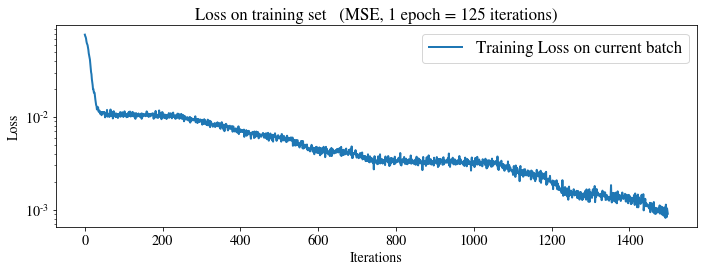

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


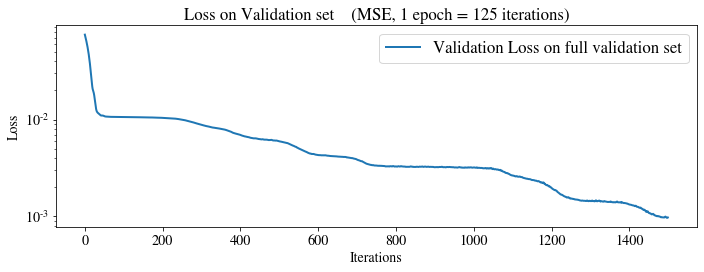

0.0009939749453527233
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120824/ 2qubit_FindMinDim 10000.0 100 18 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=18, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=18, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:28<00:00,  7.36s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.06938698 0.06776696 0.06639752 ... 0.00089221 0.00092253 0.0008977 ]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


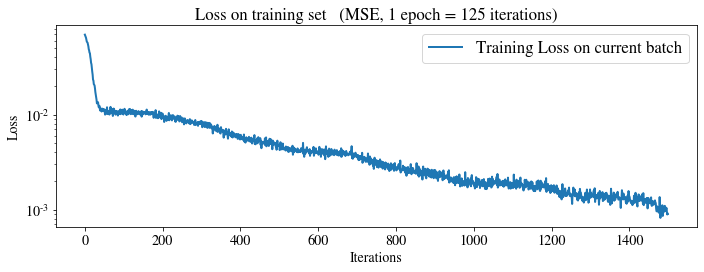

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


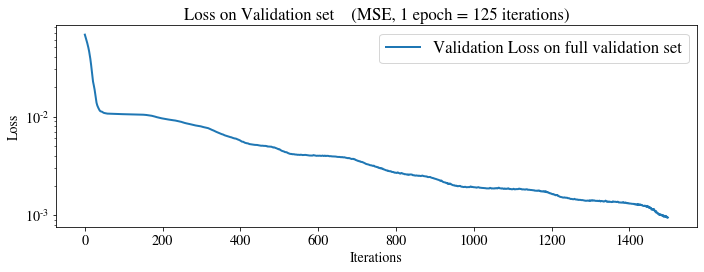

0.0009843395634864768
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120824/ 2qubit_FindMinDim 10000.0 100 20 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:25<00:00,  7.15s/it]


[0.09086201 0.0881     0.08565722 ... 0.00129387 0.00139829 0.00138144]


/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


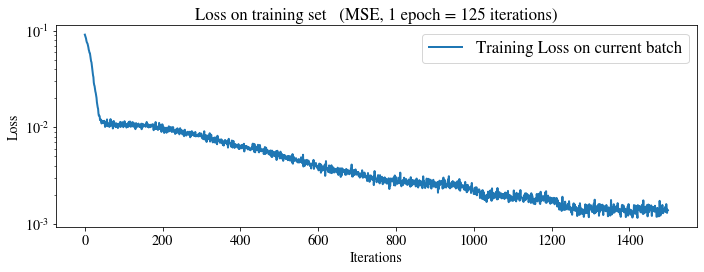

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


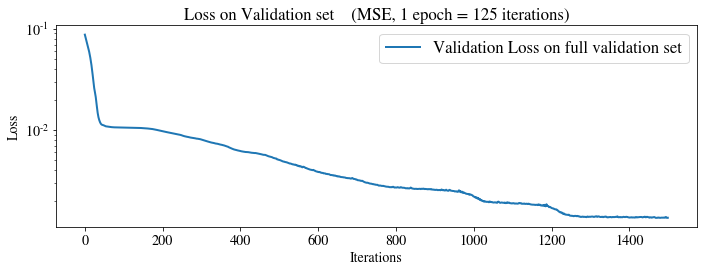

0.0013963376016666491
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120824/ 2qubit_FindMinDim 10000.0 100 25 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=25, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=25, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:25<00:00,  7.11s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08157948 0.07979029 0.07831758 ... 0.00122306 0.00126889 0.00128082]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


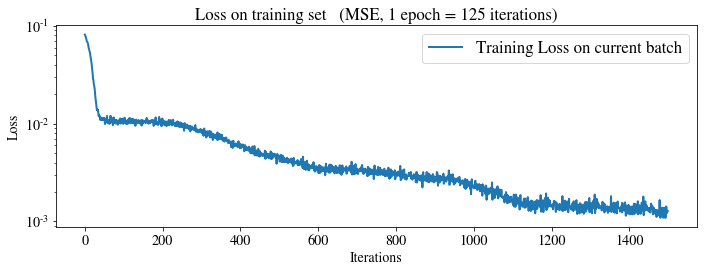

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


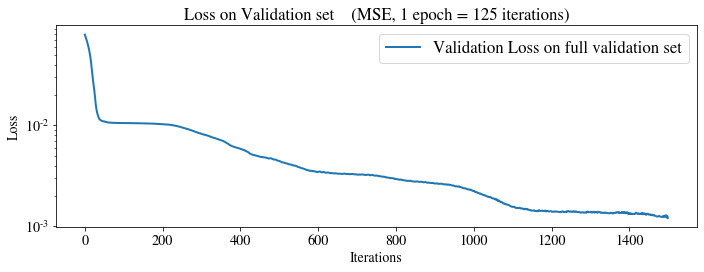

0.0012475612030054132
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120824/ 2qubit_FindMinDim 10000.0 100 30 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=30, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=30, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:25<00:00,  7.14s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08160745 0.07929849 0.07774943 ... 0.0010801  0.00097121 0.00093733]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


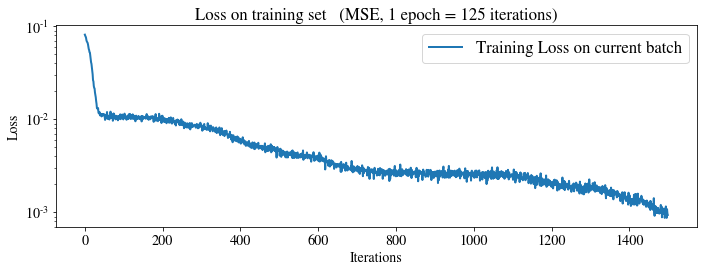

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


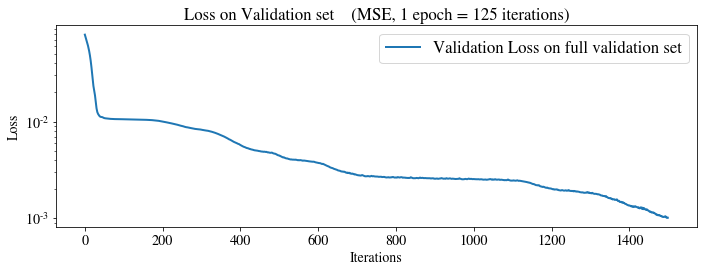

0.0010297758194307487
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120809/ 2qubit_FindMinDim 10000.0 100 1 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:25<00:00,  7.13s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08590949 0.08180013 0.07702252 ... 0.0087083  0.00853392 0.00899499]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


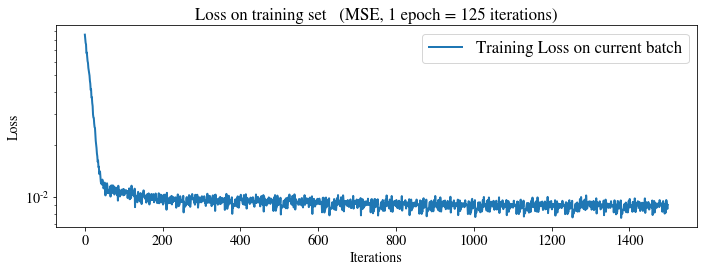

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


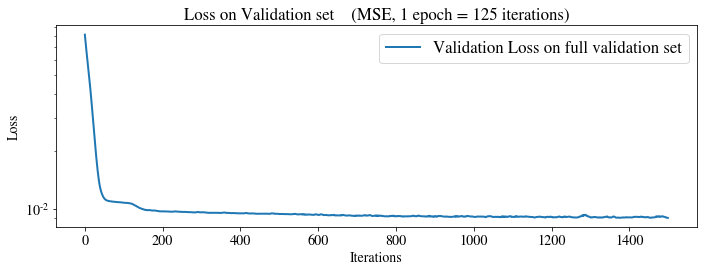

0.008592535307010015
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120809/ 2qubit_FindMinDim 10000.0 100 5 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=5, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=5, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:25<00:00,  7.12s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.07977682 0.07783918 0.07439238 ... 0.0044289  0.00491189 0.00447877]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


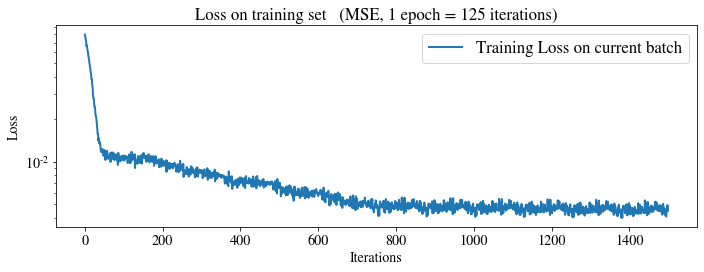

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


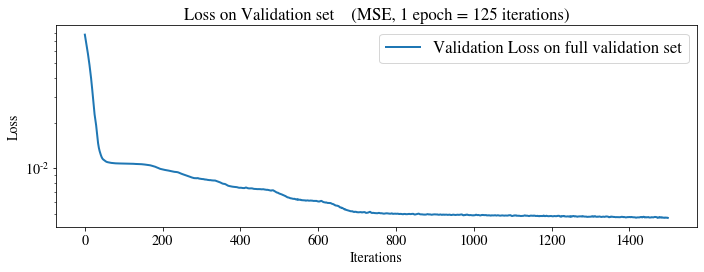

0.004430475520590941
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120809/ 2qubit_FindMinDim 10000.0 100 10 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:25<00:00,  7.13s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.07637052 0.0745949  0.07164779 ... 0.00186669 0.00192218 0.00183259]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


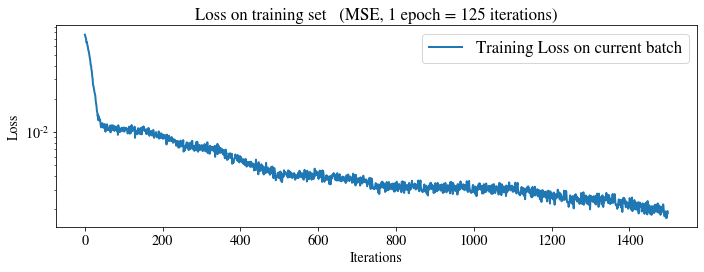

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


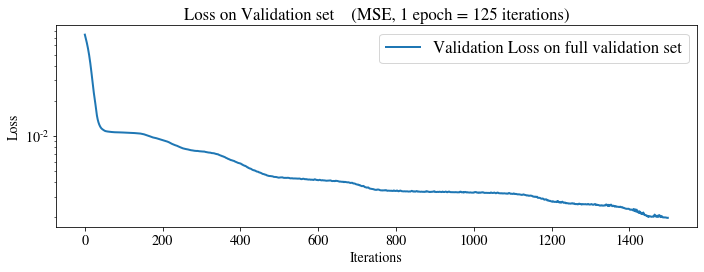

0.001838081058425208
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120809/ 2qubit_FindMinDim 10000.0 100 12 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=12, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=12, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:25<00:00,  7.15s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.07631095 0.07530378 0.0725445  ... 0.00237283 0.00268749 0.00243567]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


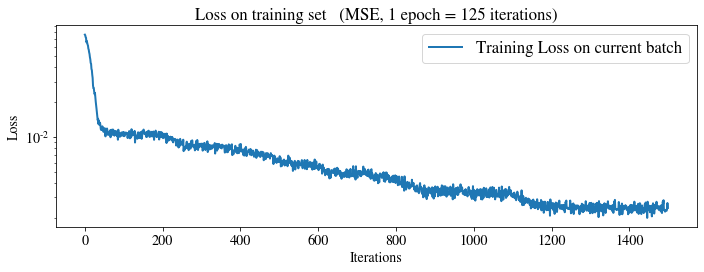

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


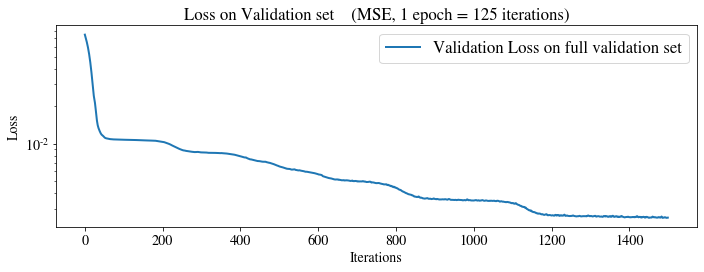

0.0023561306297779083
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120809/ 2qubit_FindMinDim 10000.0 100 14 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=14, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=14, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:26<00:00,  7.19s/it]


[0.06938735 0.06753033 0.06392697 ... 0.00075788 0.00086911 0.00083386]


/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


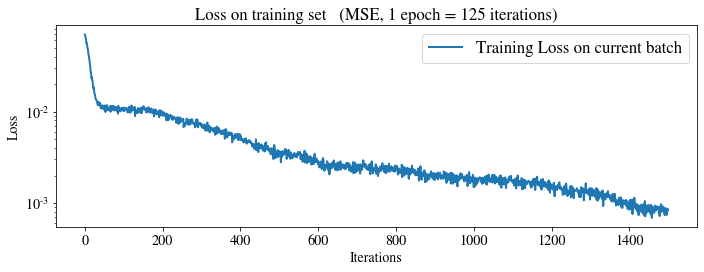

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


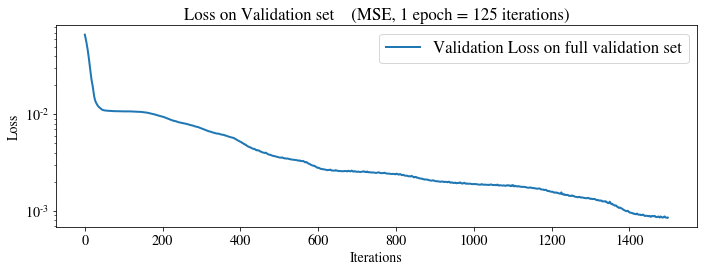

0.0008283689074839155
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120809/ 2qubit_FindMinDim 10000.0 100 15 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=15, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=15, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:26<00:00,  7.20s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.07611608 0.07430066 0.07040818 ... 0.00096876 0.00117582 0.00106632]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


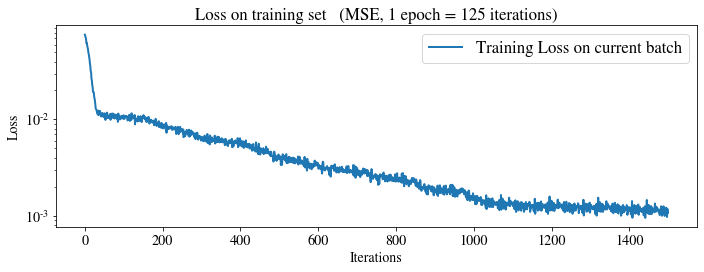

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


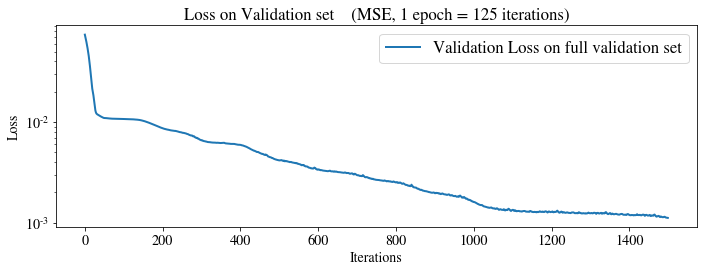

0.0010757266776636244
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120809/ 2qubit_FindMinDim 10000.0 100 16 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:26<00:00,  7.18s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.07710934 0.07546187 0.07240736 ... 0.00147811 0.00177645 0.00169849]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


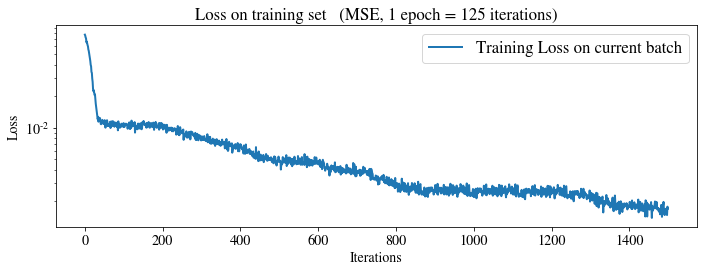

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


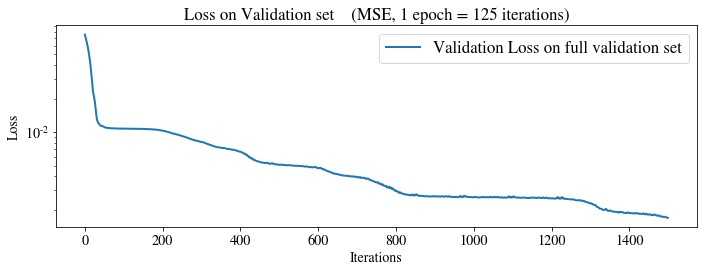

0.001609584758989513
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120809/ 2qubit_FindMinDim 10000.0 100 18 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=18, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=18, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:25<00:00,  7.15s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.07720773 0.07561178 0.07255153 ... 0.00076481 0.00088647 0.00081353]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


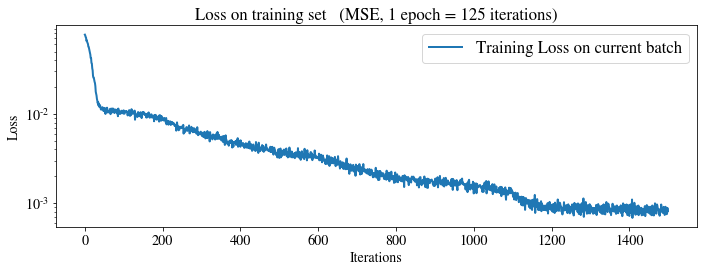

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


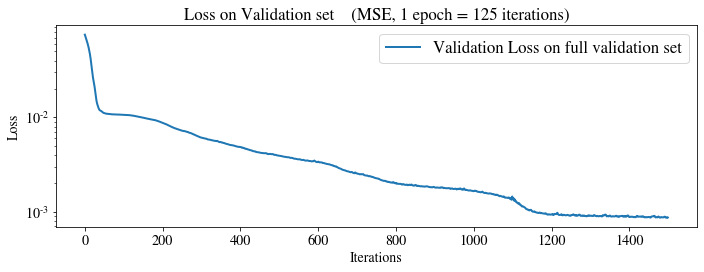

0.0008257747938235601
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120809/ 2qubit_FindMinDim 10000.0 100 20 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:25<00:00,  7.17s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.0789457  0.07742905 0.07453929 ... 0.00112933 0.00134958 0.00120754]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


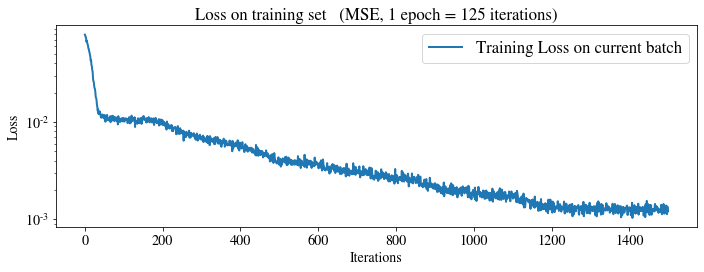

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


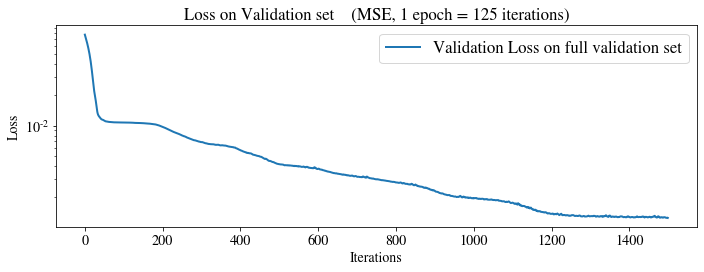

0.0012397287723918756
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120809/ 2qubit_FindMinDim 10000.0 100 25 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=25, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=25, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:26<00:00,  7.19s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.0835767  0.08202318 0.07928326 ... 0.00106493 0.00126536 0.00112414]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


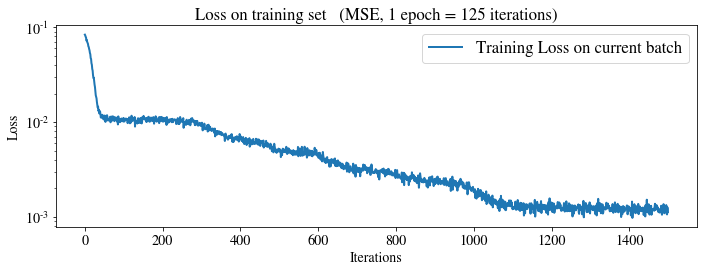

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


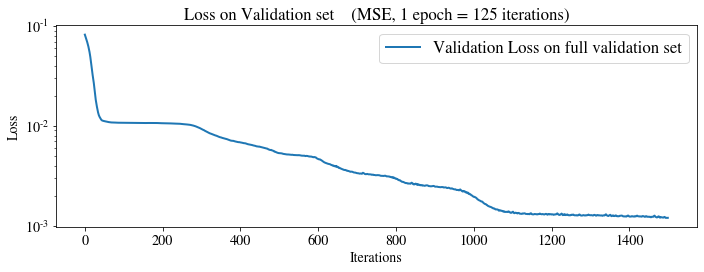

0.001170250439705948
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120809/ 2qubit_FindMinDim 10000.0 100 30 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=30, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=30, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:26<00:00,  7.21s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08105411 0.07908452 0.07564644 ... 0.00080496 0.00092761 0.00084945]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


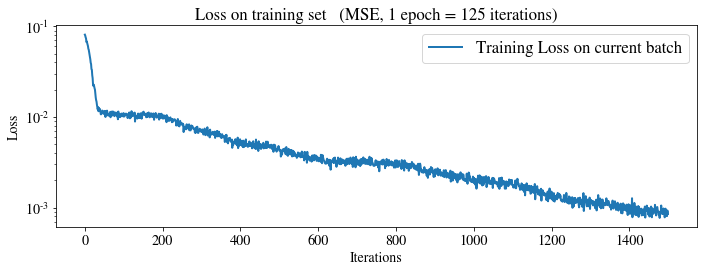

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


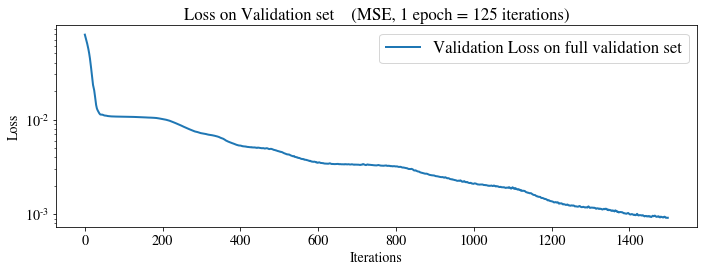

0.0008751866834548612
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120744/ 2qubit_FindMinDim 10000.0 100 1 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:26<00:00,  7.17s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08799621 0.08291197 0.0797646  ... 0.00891258 0.00922734 0.00923781]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


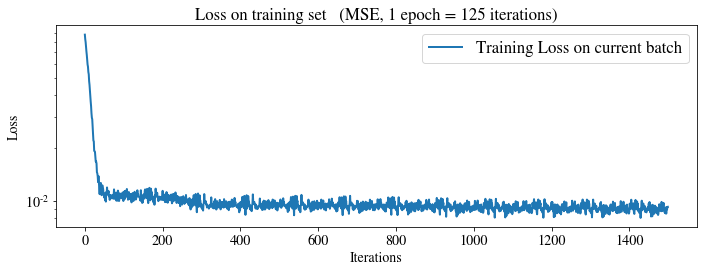

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


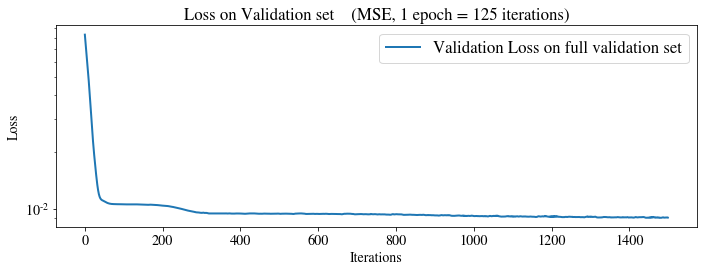

0.008909183740615844
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120744/ 2qubit_FindMinDim 10000.0 100 5 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=5, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=5, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:26<00:00,  7.21s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.07735839 0.07359947 0.07320805 ... 0.00446139 0.0053575  0.00539345]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


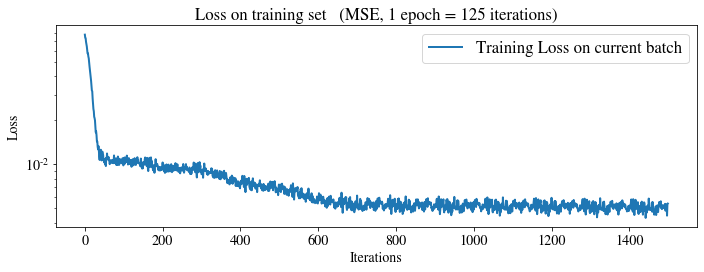

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


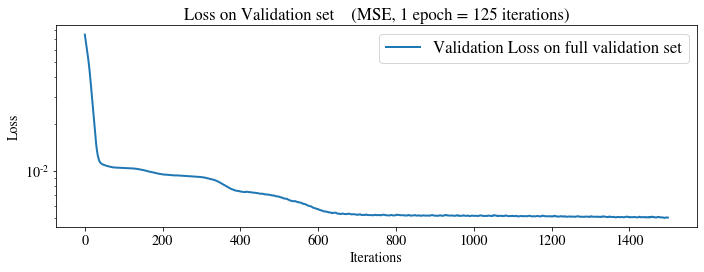

0.005092610915501912
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120744/ 2qubit_FindMinDim 10000.0 100 10 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:26<00:00,  7.21s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.0845322  0.08156408 0.08042198 ... 0.00223343 0.00262665 0.00250016]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


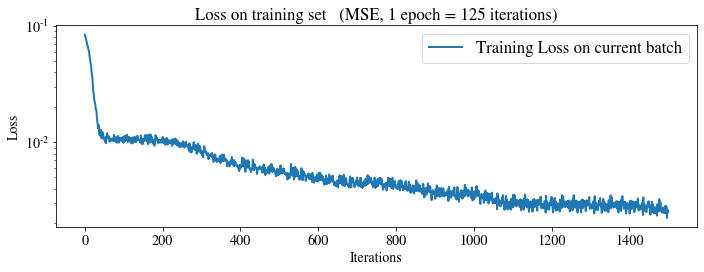

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


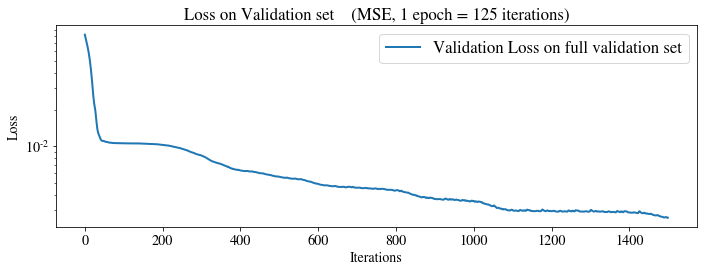

0.002602710466211041
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120744/ 2qubit_FindMinDim 10000.0 100 12 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=12, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=12, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:25<00:00,  7.15s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.07312062 0.06942056 0.06879836 ... 0.00104143 0.00112969 0.00112843]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


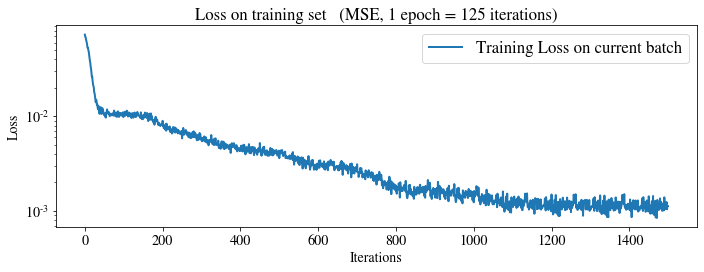

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


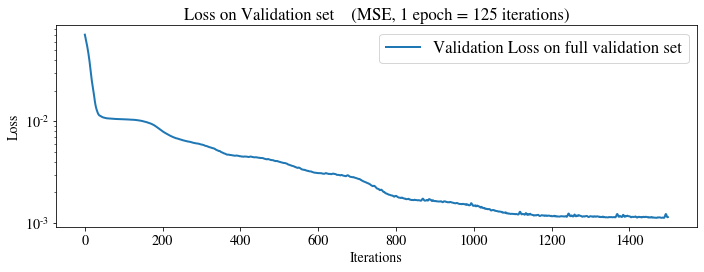

0.001181046268902719
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120744/ 2qubit_FindMinDim 10000.0 100 14 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=14, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=14, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:26<00:00,  7.19s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.07792521 0.07465809 0.07382462 ... 0.00141376 0.00166927 0.00149845]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


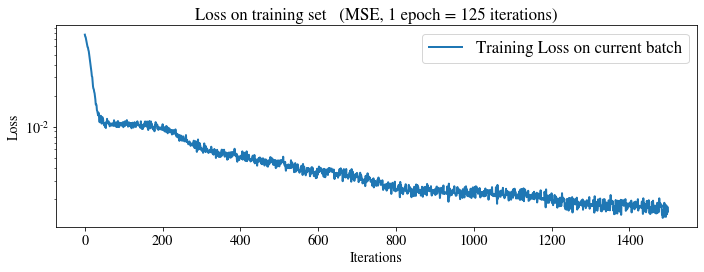

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


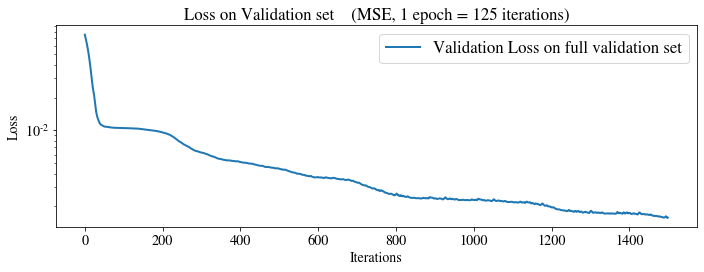

0.0016222720344861348
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120744/ 2qubit_FindMinDim 10000.0 100 15 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=15, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=15, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:26<00:00,  7.17s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.07894001 0.07615447 0.0756521  ... 0.00195566 0.00245269 0.00221351]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


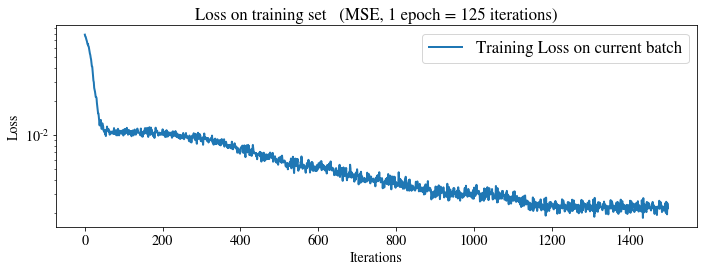

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


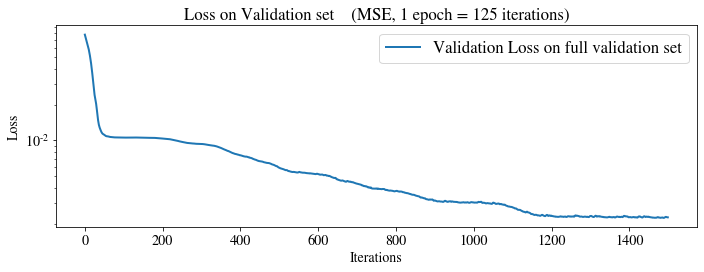

0.00228586772767206
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120744/ 2qubit_FindMinDim 10000.0 100 16 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:25<00:00,  7.12s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08965549 0.08614454 0.08515396 ... 0.00083984 0.00094768 0.00089404]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


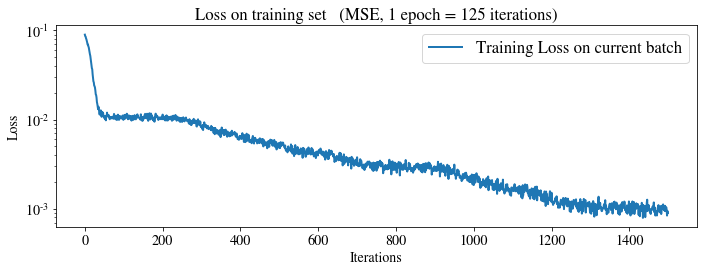

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


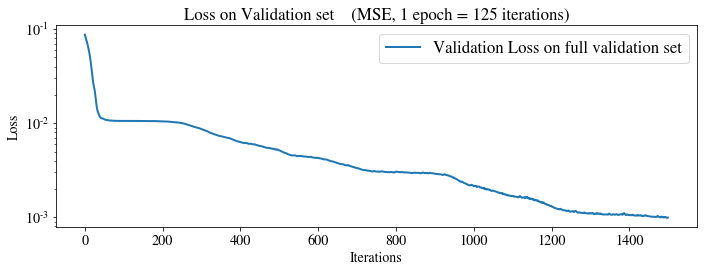

0.000985865411348641
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120744/ 2qubit_FindMinDim 10000.0 100 18 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=18, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=18, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:25<00:00,  7.14s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08285477 0.07964495 0.07942467 ... 0.00148761 0.00175088 0.00175599]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


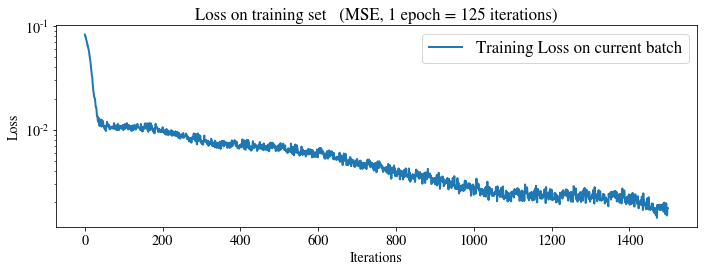

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


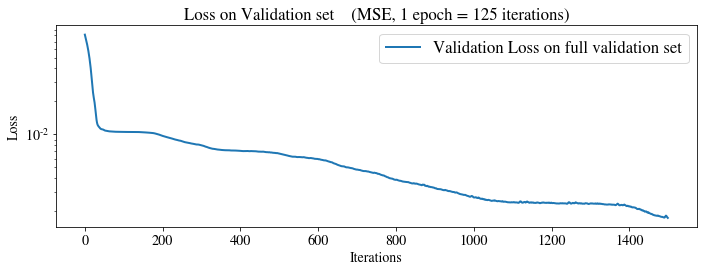

0.001727040911403795
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120744/ 2qubit_FindMinDim 10000.0 100 20 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:25<00:00,  7.14s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.08561567 0.08195357 0.08138037 ... 0.0010201  0.00114319 0.00120748]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


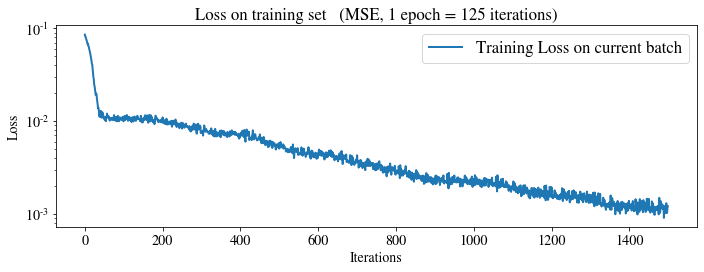

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


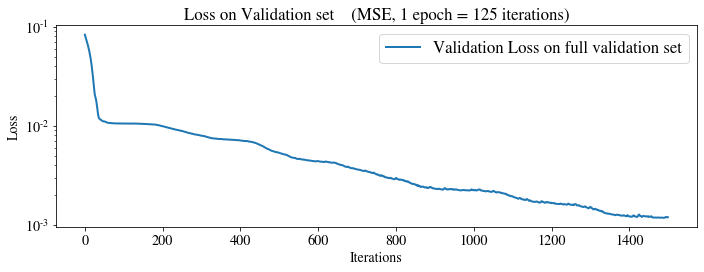

0.0011713174520991743
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120744/ 2qubit_FindMinDim 10000.0 100 25 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=25, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=25, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:26<00:00,  7.18s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.0886835  0.08483239 0.08381656 ... 0.00085061 0.00084573 0.00087125]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


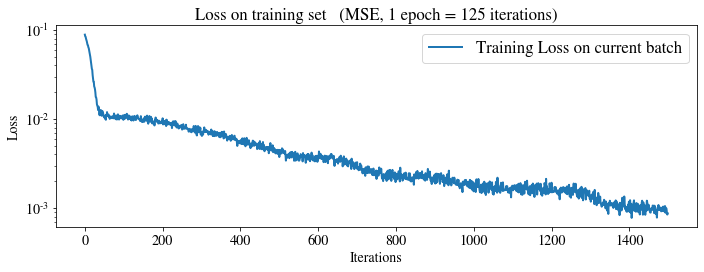

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


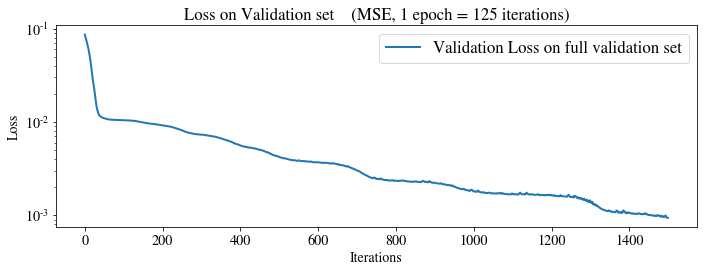

0.0009482839455207189
./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100/run_20220609_120744/ 2qubit_FindMinDim 10000.0 100 30 0.001 12
AutoencoderNet(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=30, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=30, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
  )
)


100%|██████████| 12/12 [01:25<00:00,  7.12s/it]
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:9: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/train_losses.png', dpi=150)


[0.07230815 0.06973813 0.0690673  ... 0.00093919 0.00105276 0.00102856]


/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


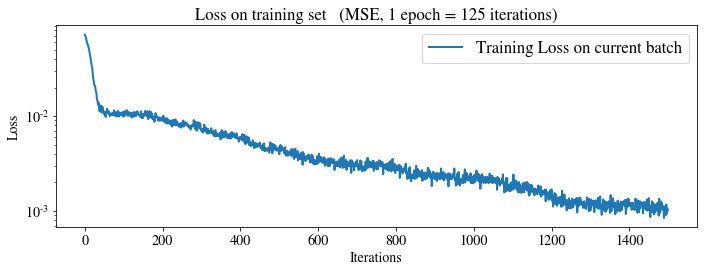

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_33088/863207960.py:19: UserWarning: Glyph 9 (	) missing from current font.
  a=plt.savefig(path + '/valid_losses.png', dpi=150)
/Users/canrager/.pyenv/versions/3.9.11/envs/thenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


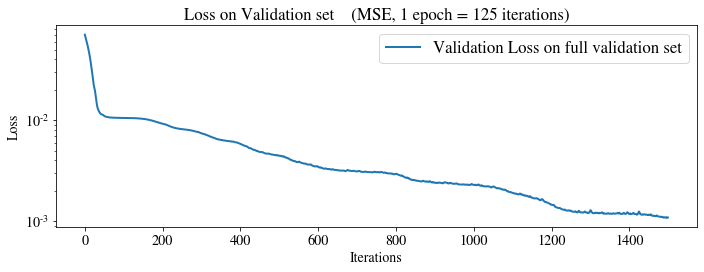

0.001065647330445548


In [65]:
ae_perf = ae_train_multiple_runs(data_path='./data/tomo0607_2qubit_random_uniform_vector/states10000_obs100',
                                    model_title='2qubit_FindMinDim', 
                                    latent_dims=[1, 5, 10, 12, 14, 15, 16, 18, 20, 25, 30], 
                                    nstat=1e4, 
                                    nobs=100, 
                                    lr=1e-3, 
                                    nepochs=12)

## Evaluation

In [114]:
def ae_eval_multiple_runs(dataexp_path, model_title, latent_dims, nstat, nobs, nruns):
    performances = np.empty((0, nruns))

    all_model_paths = [f for f in os.listdir('./models') if model_title in f]
    for ldim in latent_dims:
        ldim_perf = np.array([])
        ldim_model_paths = [f for f in all_model_paths if f'latentdim{ldim}_' in f][:nruns]
        print(f'{len(ldim_model_paths)} trained {model_title} models found with latent dim = {ldim}.')
        for run in ldim_model_paths:
            model_path = './models/' + run
            run_name = re.search('([^(run)]+$)', model_path).group(0)
            data_run_path = dataexp_path + f'/states{int(nstat)}_obs{nobs}/run{run_name}/'
            _, _, treasure_dataloader = load_dataset(data_run_path, nstat)

            loaded_model = AutoencoderNet(measurement_dim=nobs, latent_dim=ldim).to(device)
            loaded_model.load_state_dict(torch.load(model_path+'/model.model'))
            treasure_mse = evaluate_mse_ae(loaded_model, treasure_dataloader, nn.MSELoss(), device)
            ldim_perf = np.append(ldim_perf, treasure_mse)
        performances = np.vstack((performances, ldim_perf))

    ldim_means = np.mean(performances, axis=1)
    ldim_merrs = np.std(performances, axis=1) / np.sqrt(nruns)
    plt.figure(dpi=150)
    plt.errorbar(latent_dims, ldim_means, yerr=ldim_merrs, fmt='o', markersize = 2, capsize = 4)
    plt.xlabel('Dimension des latenten Vekors')
    plt.ylabel('Mittlerer quadratischer Fehler')
    plt.yscale('log')
    plt.grid()
    return performances

In [ ]:
print(ae_perf)

[0.04702447]


## Latent Representation Bloch?

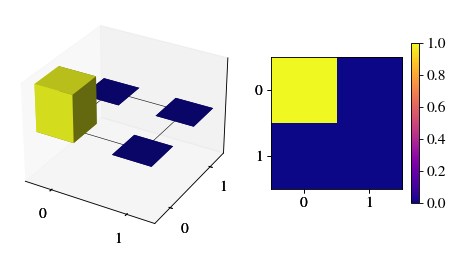

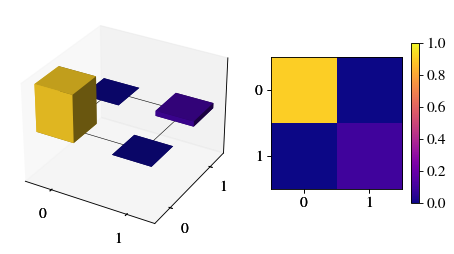

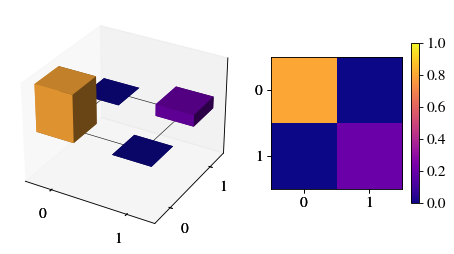

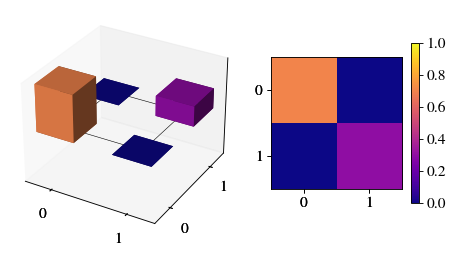

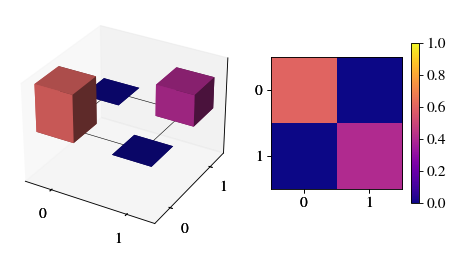

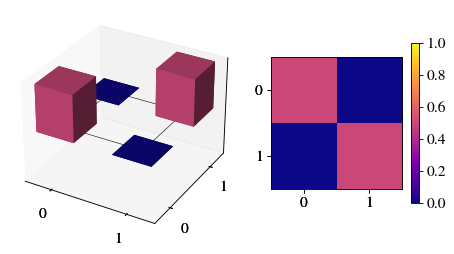

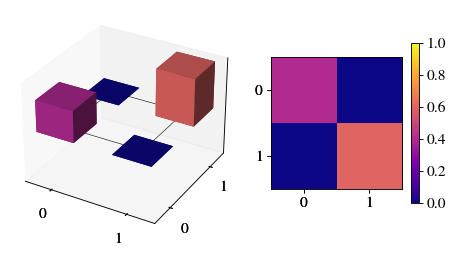

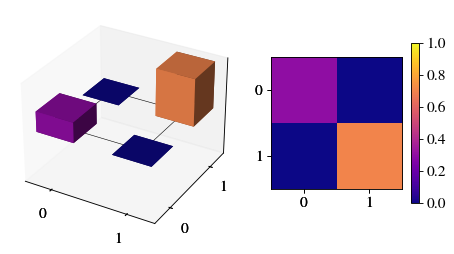

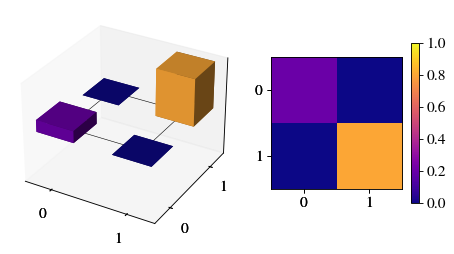

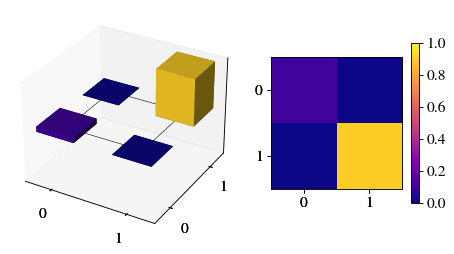

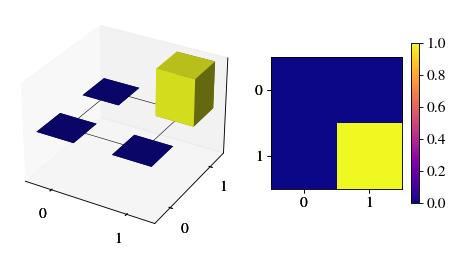

In [179]:
tspace = np.arange(11)/10
P_plus = np.array([[1,0], [0,0]])
P_minus = np.array([[0,0], [0,1]])
P_tseries = [(1-t) * P_plus + t * P_minus for t in tspace]

for Pt in P_tseries: 
    plot_dm(np.real(Pt), fixed_scale=(0,1))

In [180]:
def ae_encode_inference(rho, model_path, data_path, nobs):
    # Load observables
    dim = 2**NQ
    data_obs = np.zeros((0,dim,dim))
    with open(data_path+'/observables.csv', 'r') as f:
        reader = csv.reader(f)
        for line in tqdm(reader):
            data_obs = np.vstack((data_obs, np.array([np.array(line).reshape(dim,dim).astype('complex128')])))

    # Make measurements on state
    m_infer = torch.Tensor(perform_measurements(rho, data_obs))

    # Load Model
    load_net = AutoencoderNet(measurement_dim=nobs, latent_dim=3).to(device)
    load_net.load_state_dict(torch.load(model_path+'/model.model'))

    # Encode measurements with ae
    bloch_rep = load_net.encode(m_infer).detach().cpu().numpy()
    rho_encoded = torch2rho(bloch_rep)
    return rho_encoded

100it [00:00, 37981.56it/s]
100it [00:00, 38360.20it/s]
100it [00:00, 46101.38it/s]
100it [00:00, 42551.53it/s]
100it [00:00, 36061.42it/s]
100it [00:00, 37365.74it/s]
100it [00:00, 30535.12it/s]
100it [00:00, 41185.23it/s]
100it [00:00, 36602.71it/s]
100it [00:00, 29770.06it/s]
100it [00:00, 26781.84it/s]


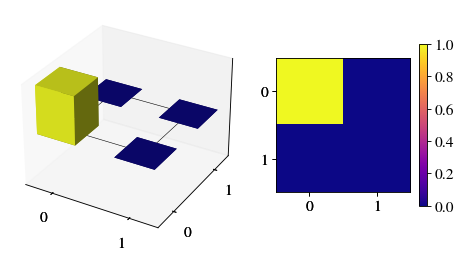

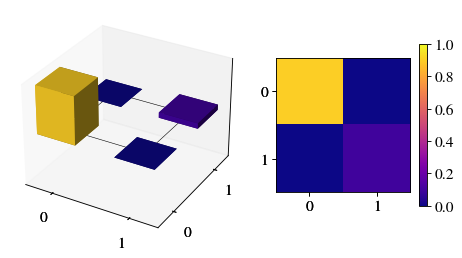

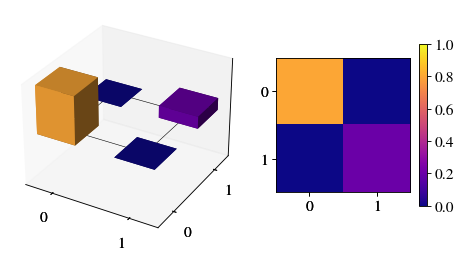

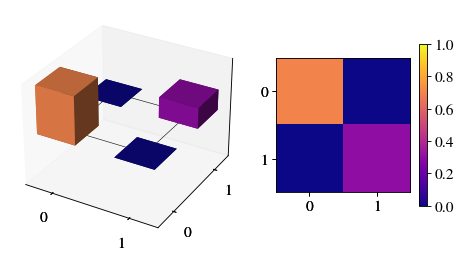

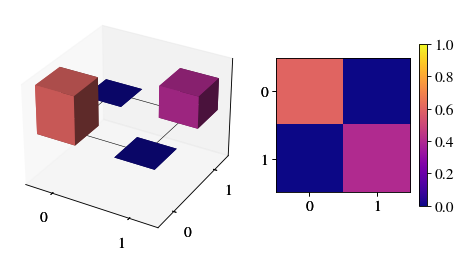

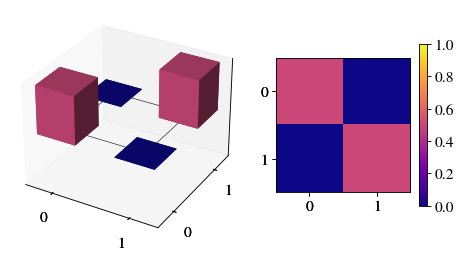

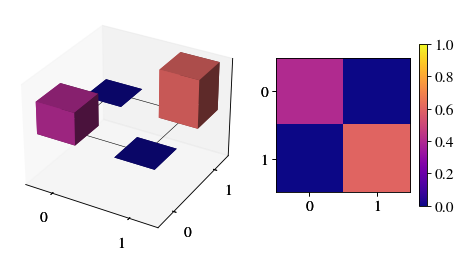

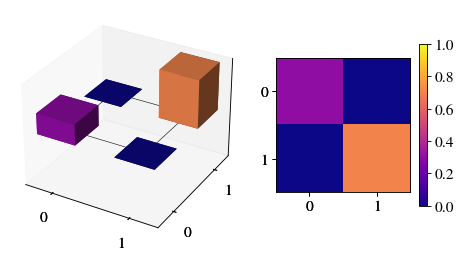

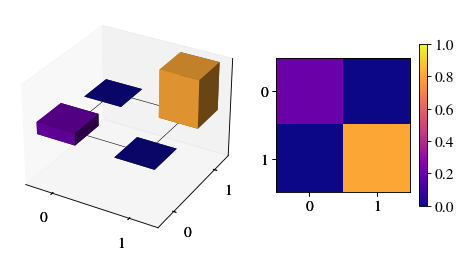

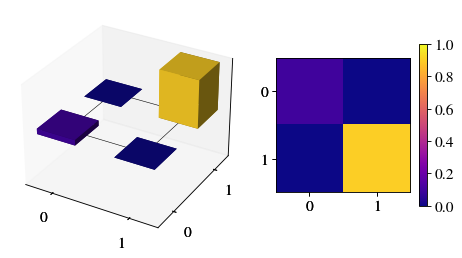

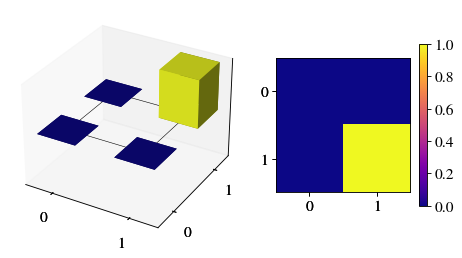

In [185]:
# ae_test_model_path = './models/AE_states10000_obs100_latentdim3_epochs20_lr0.001_FindMinDim_run_20220604_092852'
# ae_test_data_path = './data/tomo0604_1qubit_random_uniform_vector/states10000_obs100/run_20220604_092852'

# ae_test_model_path = './models/AE_states10000_obs100_latentdim3_epochs20_lr0.001_FindMinDim_run_20220604_092841'
# ae_test_data_path = './data/tomo0604_1qubit_random_uniform_vector/states10000_obs100/run_20220604_092841'

ae_test_model_path = './models/AE_states10000_obs100_latentdim3_epochs20_lr0.001_FindMinDim_run_20220604_092837'
ae_test_data_path = './data/tomo0604_1qubit_random_uniform_vector/states10000_obs100/run_20220604_092837'

Encoded_tseries = [ae_encode_inference(rho_infer, ae_test_model_path, ae_test_data_path, nobs=100) for rho_infer in P_tseries]
Encoded_tseries = np.real(Encoded_tseries)


for i, (rho_infer, rho_encoded) in enumerate(zip(P_tseries, Encoded_tseries)):
    plot_dm(np.real(rho_infer),
            save_path = f'./results/rep_series/Ptseries/{i}.png', fixed_scale=(np.min(P_tseries), np.max(P_tseries)))
    # plot_dm(np.real(rho_encoded), title='', save_path=f'./results/rep_series/enc37series/{i}.png', fixed_scale=(np.min(Encoded_tseries), np.max(Encoded_tseries)))
